In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from tqdm import tqdm_notebook as tqdm

# Introduction

This submission pertains to the Monet GAN Kaggle competition, which involves the development of a GAN model with the ability to generate dog images based on real images. The objective of this undertaking is to utilize deep learning and computer vision techniques to fabricate artificial images that closely resemble actual dog pictures.

GANs comprise of two neural networks engaged in a competitive manner: the generator, which generates synthetic images, and the discriminator, which discerns between real and generated images. Through an adversarial training process, the generator progressively improves its ability to create convincing images, while the discriminator enhances its capacity to distinguish between genuine and fake samples.

The primary objective of this project is to construct a proficient GAN architecture capable of accurately capturing the distinctive traits exhibited in dog pictures.

# EDA

We visually analyze various aspects of the dataset, including the number of images, image dimensions, color channels, and file formats. By visualizing a subset of the images, we aim to understand the dataset and its features.  Additionally, we perform statistical analyses to gain a deeper understanding of the distribution of pixel values, color intensities, and image features across the dataset. This exploratory process guides our subsequent data preprocessing steps, such as resizing, normalization, and augmentation techniques, to ensure that the input images are appropriately prepared for training the GAN model. By conducting a thorough EDA, we aim to extract meaningful insights, uncover potential challenges, and make informed decisions throughout the project's development phases.

# Generator and Discriminator

In [2]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )


    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        out = self.model(imgs)
        return out.view(-1, 1)

## Parameters of GAN

In [3]:
batch_size = 32
lr = 0.001
beta1 = 0.5
epochs = 200

real_label = 0.5
fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loader and Augmentations

In [5]:
import shutil

In [6]:
class DogDataset(Dataset):
    def __init__(self, img_dir, transform1=None, transform2=None):
    
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs = []
        for img_name in self.img_names:
            img = Image.open(os.path.join(img_dir, img_name))
            
            if self.transform1 is not None:
                img = self.transform1(img)
                
            self.imgs.append(img)

    def __getitem__(self, index):
        img = self.imgs[index]
        
        if self.transform2 is not None:
            img = self.transform2(img)
        
        return img

    def __len__(self):
        return len(self.imgs)

In [7]:
transform1 = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64)])

# Data augmentation and converting to tensors
random_transforms = [transforms.RandomRotation(degrees=5)]
transform2 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomApply(random_transforms, p=0.3), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                 
train_dataset = DogDataset(img_dir='working/all-dogs/',
                           transform1=transform1,
                           transform2=transform2)

'''train_dataset = DogDataset(img_dir='/kaggle/working/all-dogs/',
                           transform1=transform1,
                           transform2=transform2)'''
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

                                           
imgs = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

### Examples of Dog Images

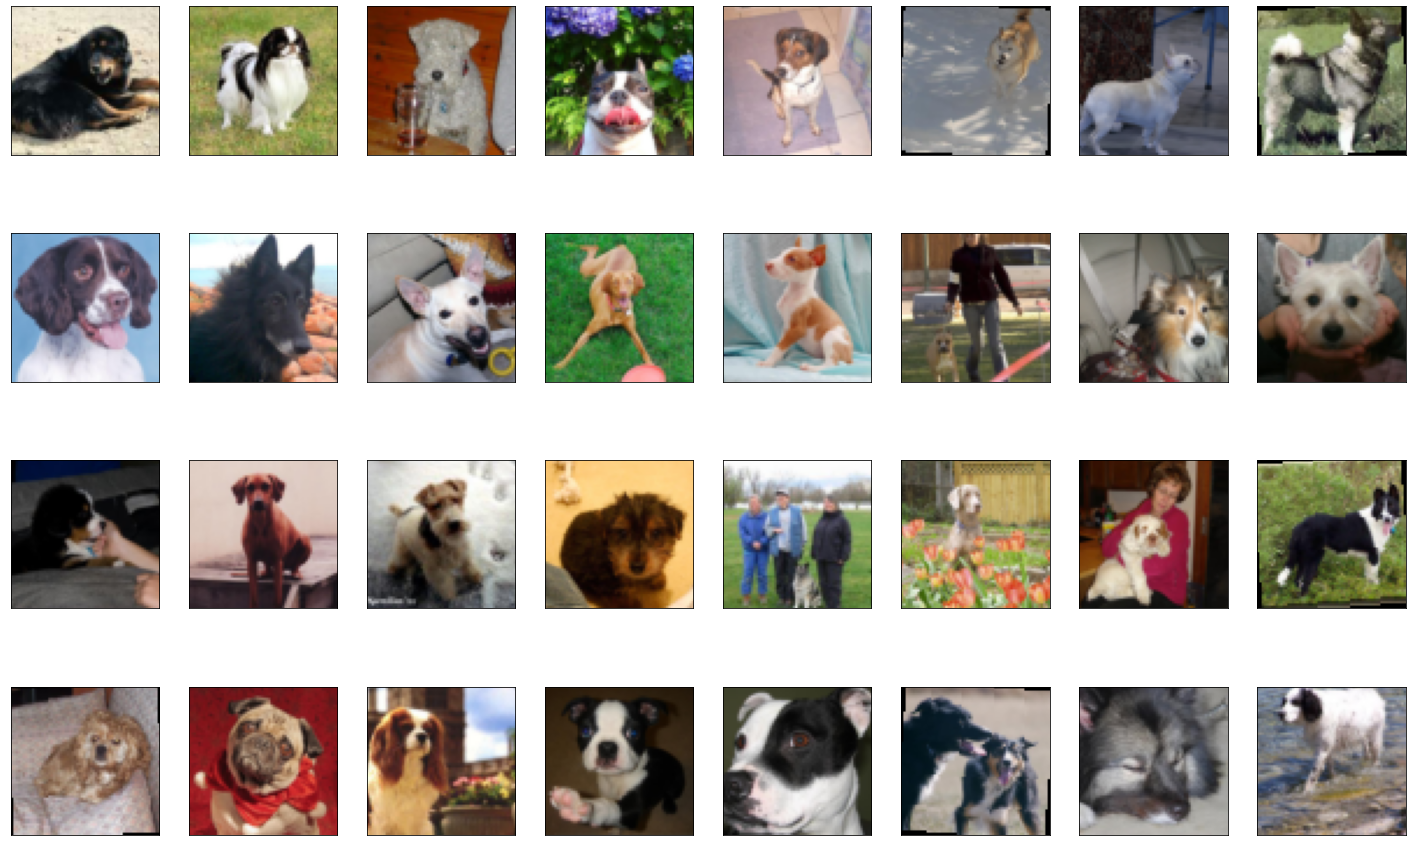

In [8]:
fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(imgs):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    
    plt.imshow((img+1)/2)

# Model building and training


Developing a successful GAN model for dog image generation involves designing the architectures of the generator and discriminator networks. The generator transforms random noise into target images, while the discriminator distinguishes between real and generated images.

For the generator, a common approach is to use a deep convolutional neural network (CNN) with convolutional layers for feature extraction and upsampling layers or transposed convolutions for image synthesis. The architecture should capture the unique details, textures, and color patterns found in dog pictures.

The GAN model's training process follows an adversarial loop, where the generator and discriminator networks compete against each other. Here's an overview of the training process:

Dataset Preparation: Preprocess real dog images and create a corresponding set of generated images using the initial generator state. Organize the data into training and validation sets.

1. Training Loop: Update the generator and discriminator networks alternately in each training iteration.

2. Discriminator Training: Provide a batch of real dog images and an equal number of generated images to the discriminator. Calculate discriminator loss by comparing predicted labels to ground truth labels. Use backpropagation to update the discriminator's weights, improving its ability to distinguish between real and generated images.

3. Generator Training: Generate a batch of new images using the current generator state. Pass these images through the discriminator and compute the generator loss based on discriminator predictions. The generator aims to generate images classified as real by the discriminator. Use backpropagation to update the generator's weights, enhancing its ability to deceive the discriminator.

4. Iteration and Evaluation: Repeat the training loop for a specified number of iterations (epochs). Periodically evaluate the generator's performance by generating sample images and assessing their fidelity to real dog images. This evaluation helps track model progress and fine-tune hyperparameters if necessary.

5. Convergence: Continue training until the GAN model converges, with the generator producing dog images closely resembling real ones, and the discriminator struggling to differentiate between real and generated images.

Maintaining a balance between the generator and discriminator is crucial during training. If the generator is too weak, the generated images lack quality. If the discriminator is too strong, it may quickly reject all generated images, leading to a non-converging GAN.

## Initialize models and optimizers

In [9]:
from torchvision.models import alexnet
netD = alexnet(pretrained=True)
netD.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=2048, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=2048, out_features=1, bias=True),
    nn.Sigmoid()
  )
netD.to(device)

/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
for name, param in netD.named_parameters():
    if param.requires_grad:
        param.requires_grad = False

In [11]:
for name, param in netD.classifier.named_parameters():
    if ('4' in name) or ('6' in name):
        param.requires_grad = True

In [12]:
len([p for p in netD.parameters() if p.requires_grad])

4

In [13]:
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

non_frozen_parameters = [p for p in netD.parameters() if p.requires_grad]
optimizerD = optim.Adam(non_frozen_parameters, lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

G_losses = []
D_losses = []
epoch_time = []

In [14]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [15]:
def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
    
    figure, axes = plt.subplots(1, len(sample), figsize = (64,64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample[index]
        axis.imshow(image_array)
        
    plt.show()
    plt.close()

## Training loop

/tmp/ipykernel_8537/3537918105.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ii, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):


  0%|          | 0/644 [00:00<?, ?it/s]

[1/300][322/644] Loss_D: 0.2384 Loss_G: 1.3317
[1/300][644/644] Loss_D: 0.0254 Loss_G: 0.9174


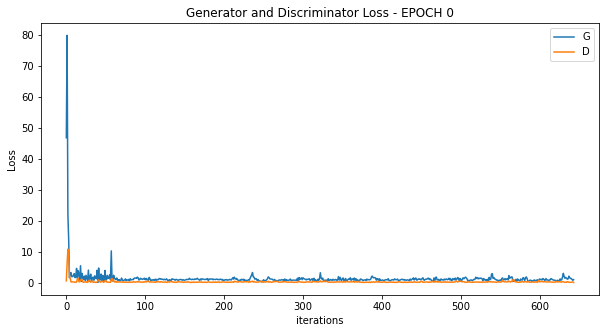

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


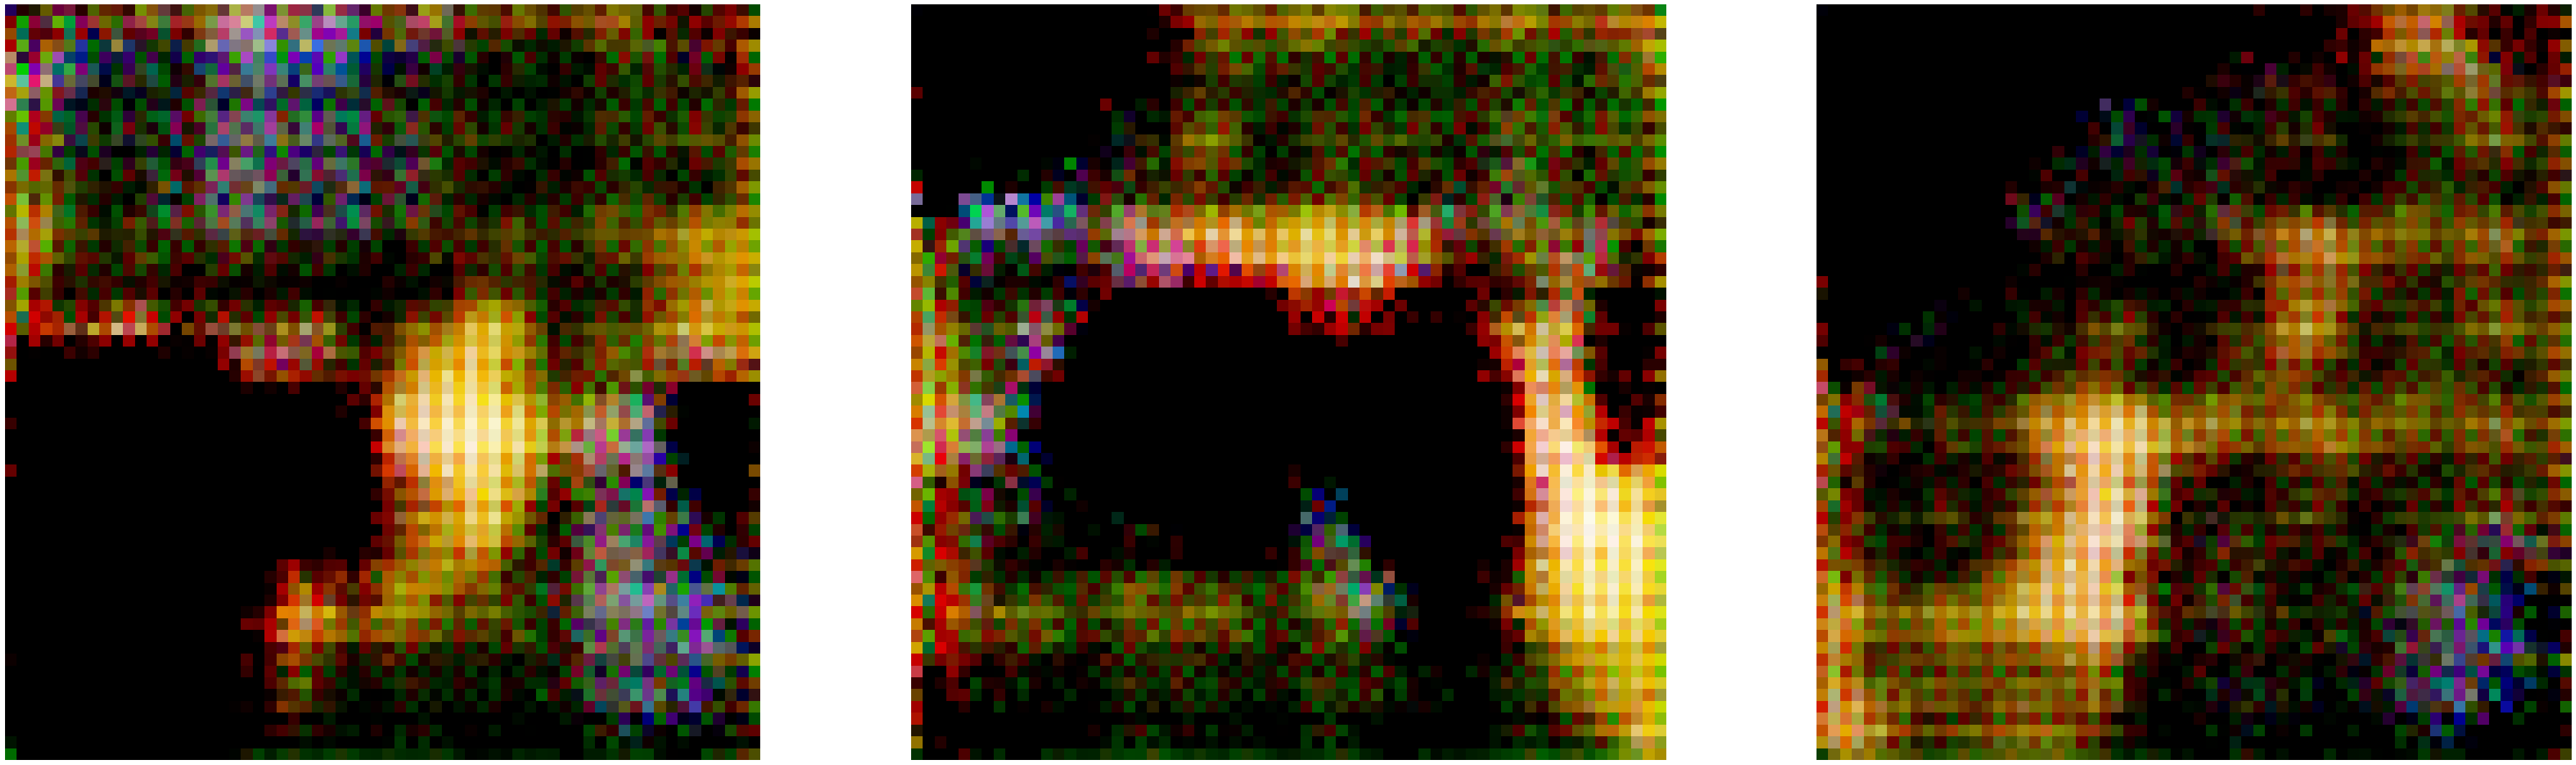

  0%|          | 0/644 [00:00<?, ?it/s]

[2/300][322/644] Loss_D: 0.1100 Loss_G: 1.1060
[2/300][644/644] Loss_D: 0.2578 Loss_G: 3.6318


  0%|          | 0/644 [00:00<?, ?it/s]

[3/300][322/644] Loss_D: 0.0553 Loss_G: 1.3940
[3/300][644/644] Loss_D: 0.8306 Loss_G: 4.4175


  0%|          | 0/644 [00:00<?, ?it/s]

[4/300][322/644] Loss_D: 0.1989 Loss_G: 0.9426
[4/300][644/644] Loss_D: 0.1018 Loss_G: 2.3578


  0%|          | 0/644 [00:00<?, ?it/s]

[5/300][322/644] Loss_D: 0.0711 Loss_G: 1.0343
[5/300][644/644] Loss_D: 0.0600 Loss_G: 0.5566


  0%|          | 0/644 [00:00<?, ?it/s]

[6/300][322/644] Loss_D: 0.2318 Loss_G: 1.2640
[6/300][644/644] Loss_D: 0.8154 Loss_G: 3.5001


  0%|          | 0/644 [00:00<?, ?it/s]

[7/300][322/644] Loss_D: 0.1470 Loss_G: 0.9622
[7/300][644/644] Loss_D: 0.1517 Loss_G: 3.2180


  0%|          | 0/644 [00:00<?, ?it/s]

[8/300][322/644] Loss_D: 0.3194 Loss_G: 0.7043
[8/300][644/644] Loss_D: 0.0404 Loss_G: 1.3615


  0%|          | 0/644 [00:00<?, ?it/s]

[9/300][322/644] Loss_D: 0.2905 Loss_G: 0.6994
[9/300][644/644] Loss_D: 0.1741 Loss_G: 1.9449


  0%|          | 0/644 [00:00<?, ?it/s]

[10/300][322/644] Loss_D: 0.2791 Loss_G: 0.9051
[10/300][644/644] Loss_D: 0.0222 Loss_G: 1.1869


  0%|          | 0/644 [00:00<?, ?it/s]

[11/300][322/644] Loss_D: 0.1920 Loss_G: 0.6057
[11/300][644/644] Loss_D: 0.2651 Loss_G: 2.4779


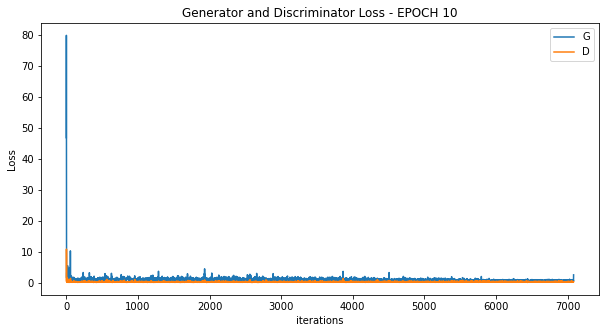

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


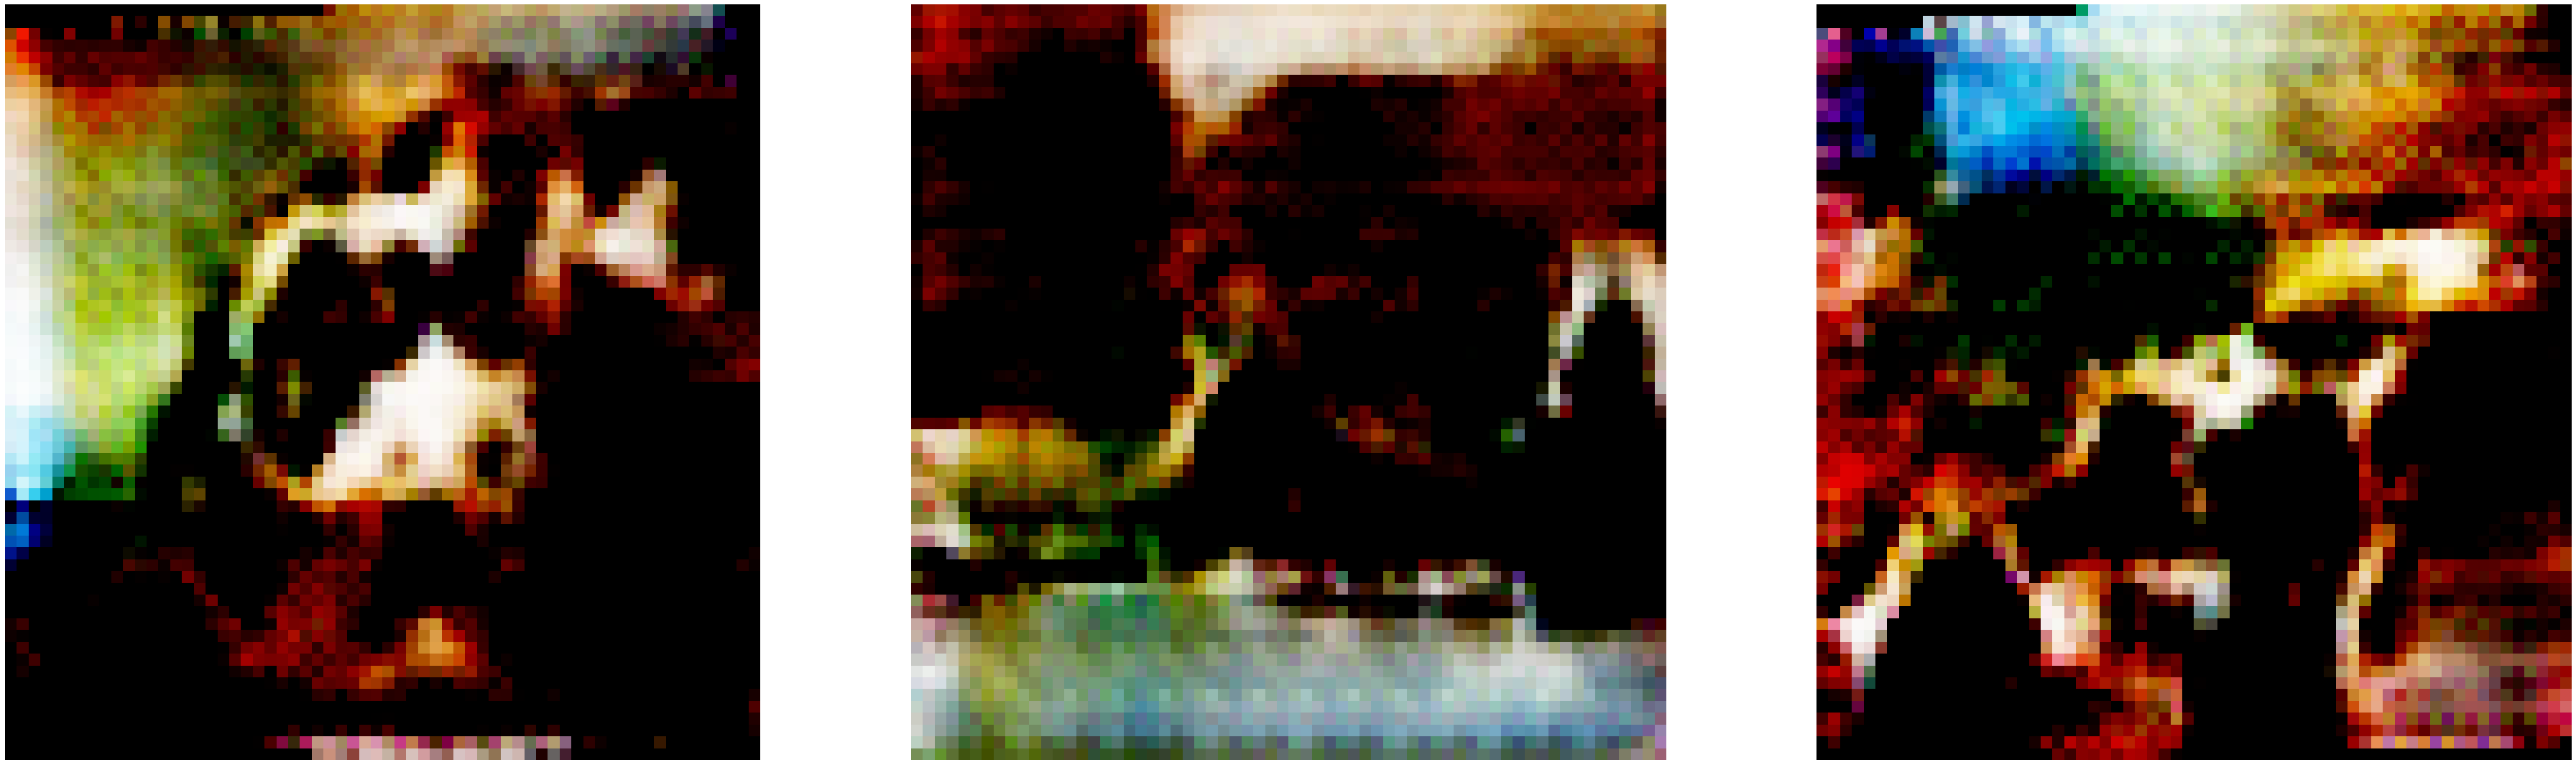

  0%|          | 0/644 [00:00<?, ?it/s]

[12/300][322/644] Loss_D: 0.1968 Loss_G: 0.7495
[12/300][644/644] Loss_D: 0.0311 Loss_G: 1.4588


  0%|          | 0/644 [00:00<?, ?it/s]

[13/300][322/644] Loss_D: 0.2416 Loss_G: 0.5549
[13/300][644/644] Loss_D: 0.1404 Loss_G: 1.9669


  0%|          | 0/644 [00:00<?, ?it/s]

[14/300][322/644] Loss_D: 0.2224 Loss_G: 0.6082
[14/300][644/644] Loss_D: 0.0444 Loss_G: 1.7032


  0%|          | 0/644 [00:00<?, ?it/s]

[15/300][322/644] Loss_D: 0.2764 Loss_G: 0.5542
[15/300][644/644] Loss_D: 0.3456 Loss_G: 1.7796


  0%|          | 0/644 [00:00<?, ?it/s]

[16/300][322/644] Loss_D: 0.1799 Loss_G: 0.5642
[16/300][644/644] Loss_D: 0.2685 Loss_G: 1.5586


  0%|          | 0/644 [00:00<?, ?it/s]

[17/300][322/644] Loss_D: 0.3381 Loss_G: 0.4214
[17/300][644/644] Loss_D: 0.0755 Loss_G: 1.7101


  0%|          | 0/644 [00:00<?, ?it/s]

[18/300][322/644] Loss_D: 0.2797 Loss_G: 0.4700
[18/300][644/644] Loss_D: 0.3217 Loss_G: 1.8703


  0%|          | 0/644 [00:00<?, ?it/s]

[19/300][322/644] Loss_D: 0.1333 Loss_G: 0.7225
[19/300][644/644] Loss_D: 0.2854 Loss_G: 1.6921


  0%|          | 0/644 [00:00<?, ?it/s]

[20/300][322/644] Loss_D: 0.1469 Loss_G: 0.6699
[20/300][644/644] Loss_D: 0.0385 Loss_G: 1.4340


  0%|          | 0/644 [00:00<?, ?it/s]

[21/300][322/644] Loss_D: 0.1930 Loss_G: 0.6090
[21/300][644/644] Loss_D: 0.2408 Loss_G: 2.1324


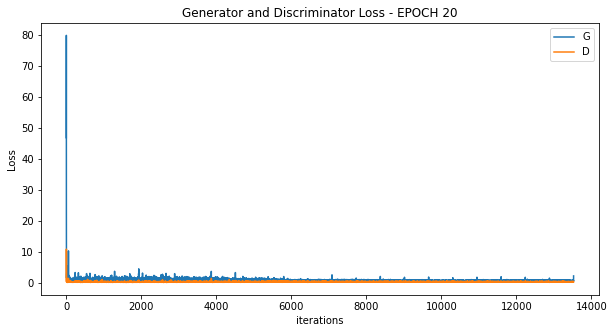

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


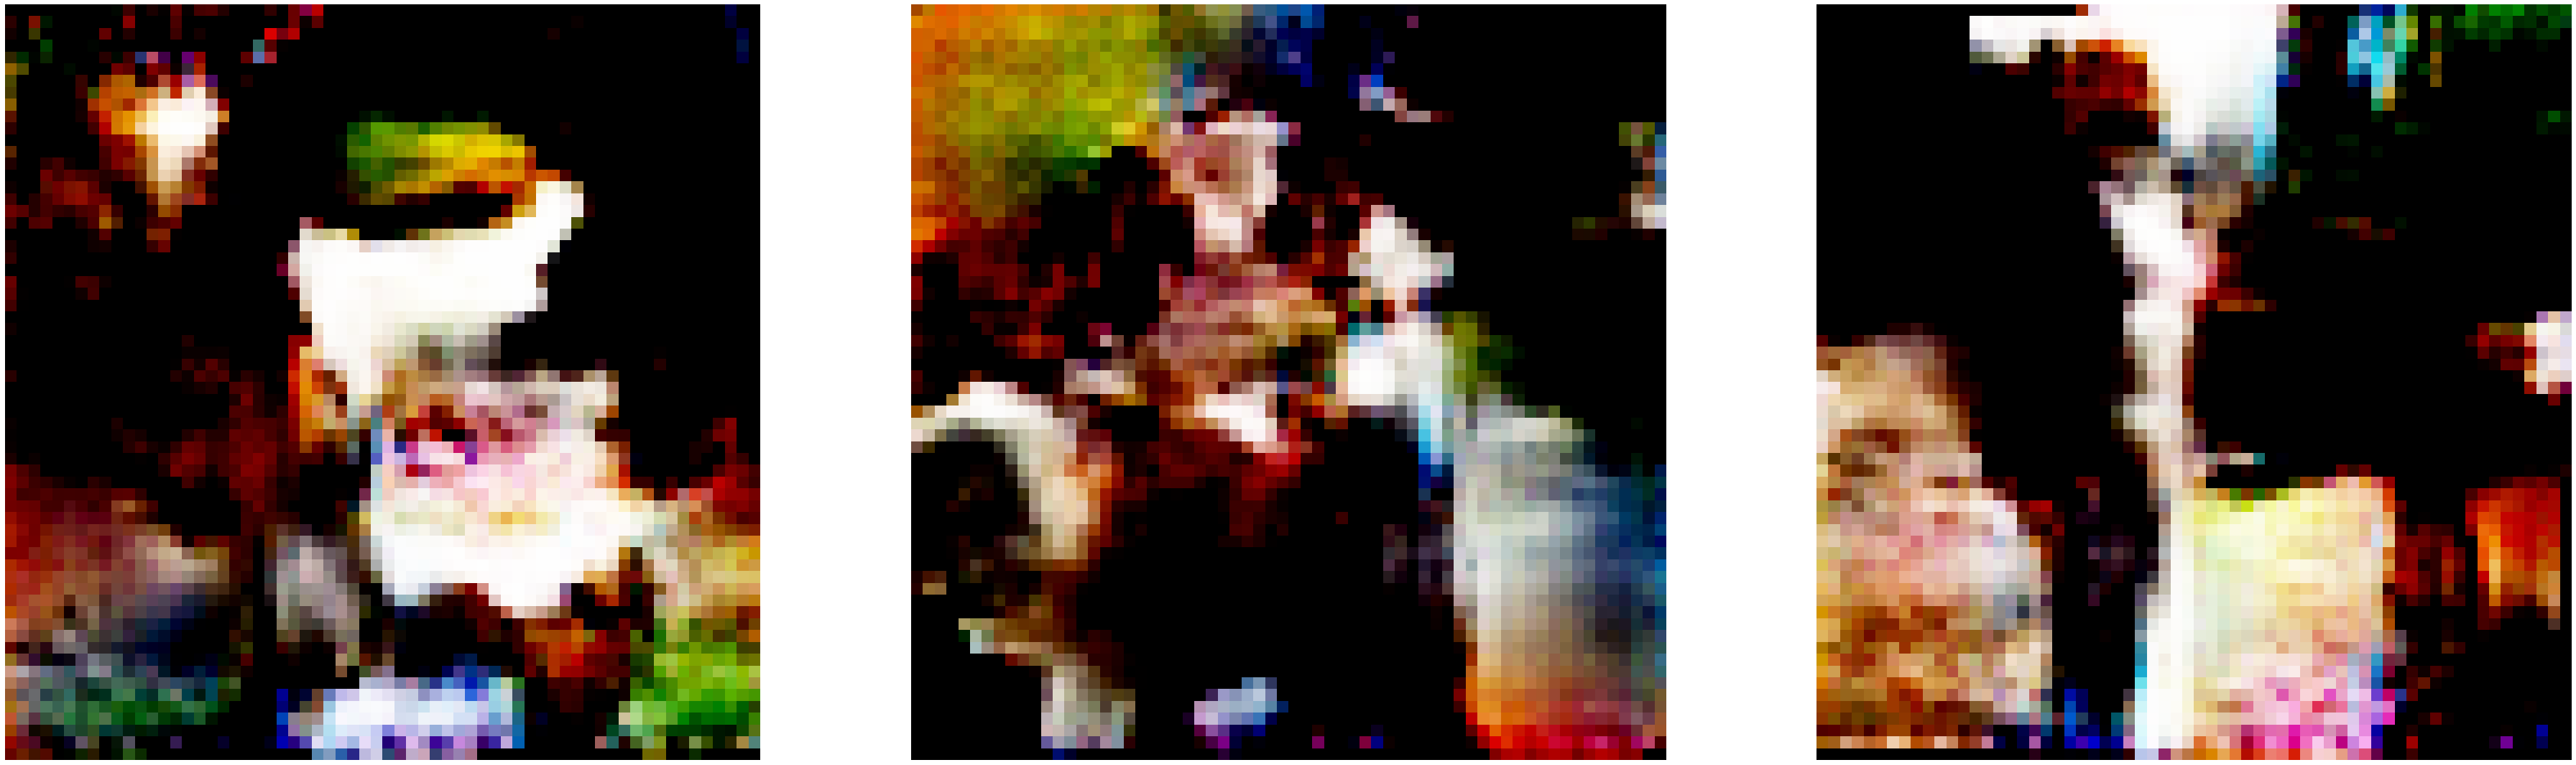

  0%|          | 0/644 [00:00<?, ?it/s]

[22/300][322/644] Loss_D: 0.1379 Loss_G: 0.5789
[22/300][644/644] Loss_D: 0.0202 Loss_G: 1.2176


  0%|          | 0/644 [00:00<?, ?it/s]

[23/300][322/644] Loss_D: 0.1214 Loss_G: 0.7473
[23/300][644/644] Loss_D: 0.0257 Loss_G: 1.2900


  0%|          | 0/644 [00:00<?, ?it/s]

[24/300][322/644] Loss_D: 0.1604 Loss_G: 0.5437
[24/300][644/644] Loss_D: 0.1537 Loss_G: 2.5846


  0%|          | 0/644 [00:00<?, ?it/s]

[25/300][322/644] Loss_D: 0.2437 Loss_G: 0.5660
[25/300][644/644] Loss_D: 0.3118 Loss_G: 2.9423


  0%|          | 0/644 [00:00<?, ?it/s]

[26/300][322/644] Loss_D: 0.1897 Loss_G: 0.4966
[26/300][644/644] Loss_D: 0.0197 Loss_G: 0.6833


  0%|          | 0/644 [00:00<?, ?it/s]

[27/300][322/644] Loss_D: 0.1293 Loss_G: 0.9014
[27/300][644/644] Loss_D: 0.3889 Loss_G: 3.8880


  0%|          | 0/644 [00:00<?, ?it/s]

[28/300][322/644] Loss_D: 0.1093 Loss_G: 0.8814
[28/300][644/644] Loss_D: 0.0636 Loss_G: 2.2447


  0%|          | 0/644 [00:00<?, ?it/s]

[29/300][322/644] Loss_D: 0.1033 Loss_G: 0.9431
[29/300][644/644] Loss_D: 0.1579 Loss_G: 2.6752


  0%|          | 0/644 [00:00<?, ?it/s]

[30/300][322/644] Loss_D: 0.0890 Loss_G: 0.8566
[30/300][644/644] Loss_D: 0.0745 Loss_G: 1.8166


  0%|          | 0/644 [00:00<?, ?it/s]

[31/300][322/644] Loss_D: 0.1995 Loss_G: 0.6841
[31/300][644/644] Loss_D: 0.4369 Loss_G: 4.4081


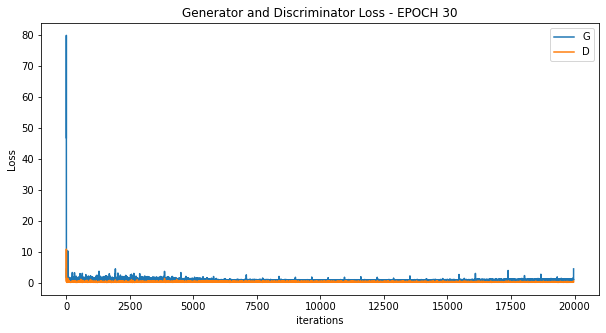

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


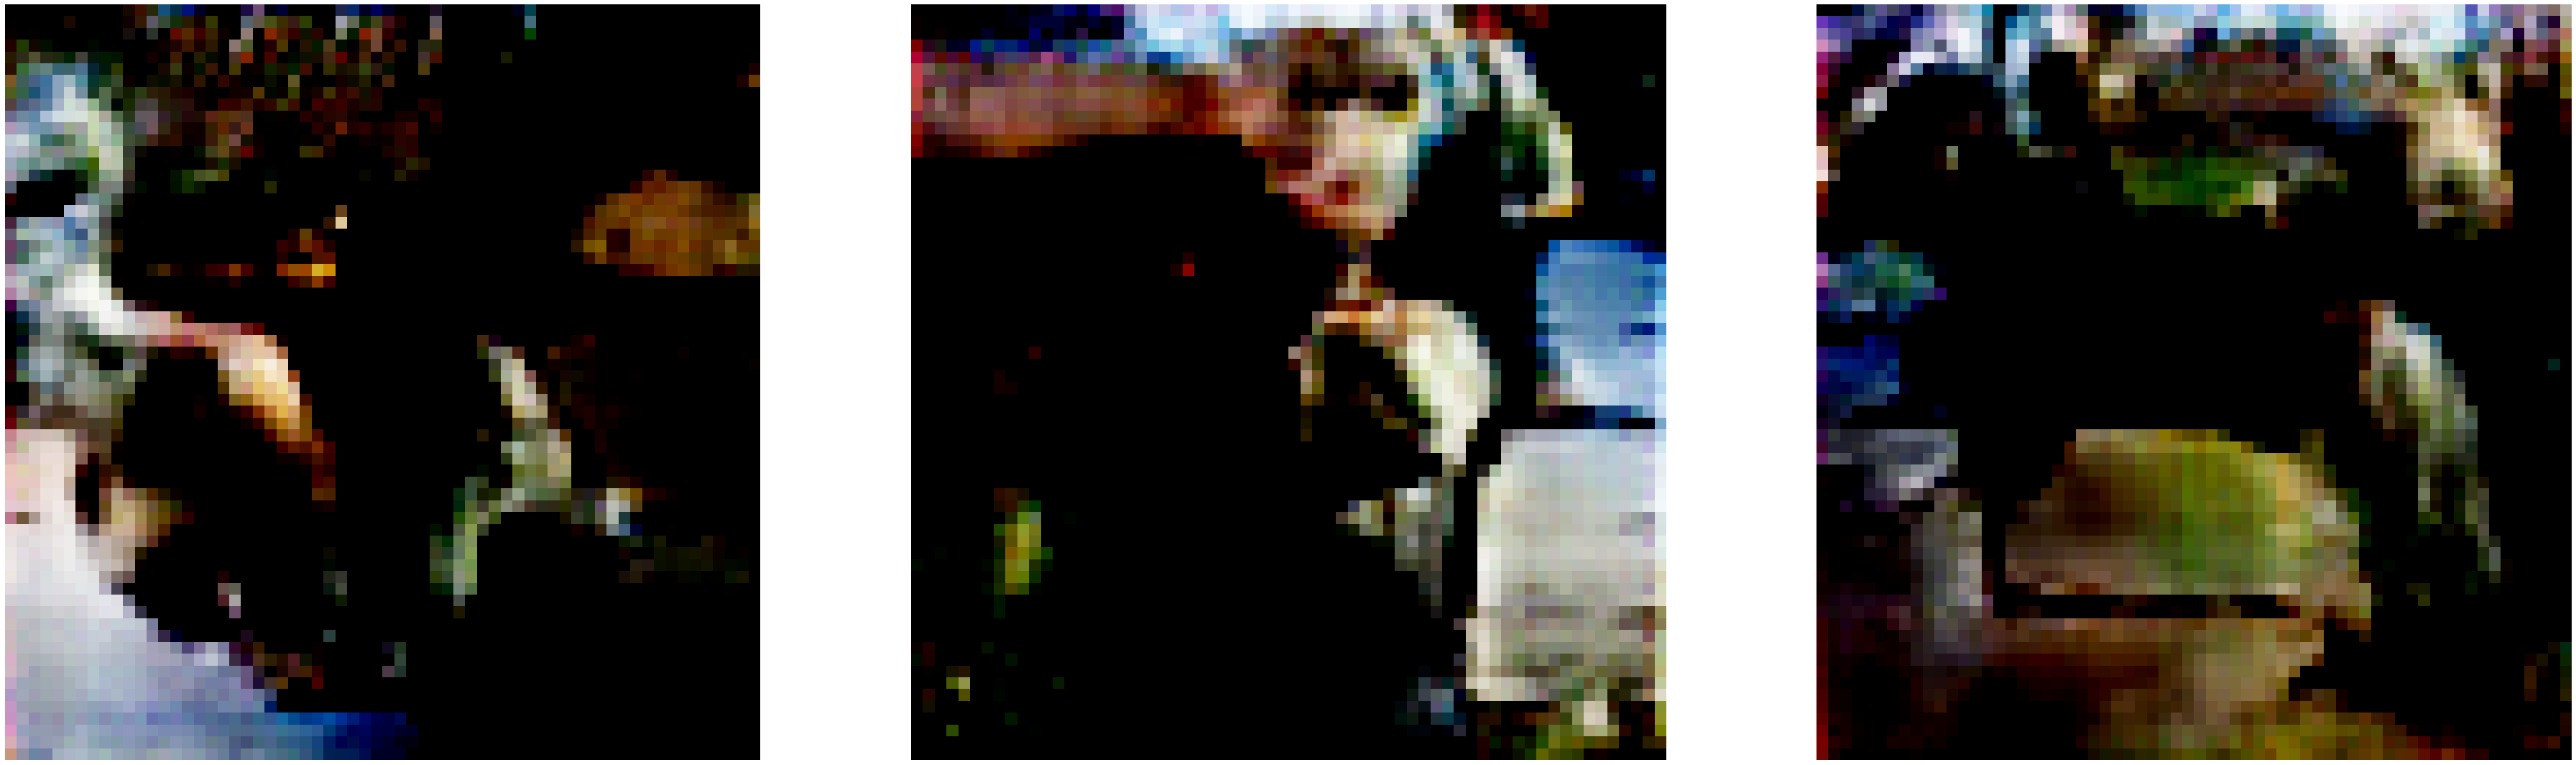

  0%|          | 0/644 [00:00<?, ?it/s]

[32/300][322/644] Loss_D: 0.1315 Loss_G: 0.8511
[32/300][644/644] Loss_D: 0.0710 Loss_G: 2.2360


  0%|          | 0/644 [00:00<?, ?it/s]

[33/300][322/644] Loss_D: 0.1105 Loss_G: 0.9021
[33/300][644/644] Loss_D: 0.2568 Loss_G: 4.4208


  0%|          | 0/644 [00:00<?, ?it/s]

[34/300][322/644] Loss_D: 0.1224 Loss_G: 0.9753
[34/300][644/644] Loss_D: 0.4521 Loss_G: 5.0820


  0%|          | 0/644 [00:00<?, ?it/s]

[35/300][322/644] Loss_D: 0.0921 Loss_G: 1.0042
[35/300][644/644] Loss_D: 0.1106 Loss_G: 2.6298


  0%|          | 0/644 [00:00<?, ?it/s]

[36/300][322/644] Loss_D: 0.1542 Loss_G: 0.8193
[36/300][644/644] Loss_D: 0.3163 Loss_G: 0.4048


  0%|          | 0/644 [00:00<?, ?it/s]

[37/300][322/644] Loss_D: 0.1995 Loss_G: 0.7915
[37/300][644/644] Loss_D: 0.2709 Loss_G: 2.8140


  0%|          | 0/644 [00:00<?, ?it/s]

[38/300][322/644] Loss_D: 0.1610 Loss_G: 0.8037
[38/300][644/644] Loss_D: 0.1226 Loss_G: 1.9991


  0%|          | 0/644 [00:00<?, ?it/s]

[39/300][322/644] Loss_D: 0.0666 Loss_G: 0.9749
[39/300][644/644] Loss_D: 0.3348 Loss_G: 7.5317


  0%|          | 0/644 [00:00<?, ?it/s]

[40/300][322/644] Loss_D: 0.1384 Loss_G: 1.1182
[40/300][644/644] Loss_D: 0.0149 Loss_G: 0.4641


  0%|          | 0/644 [00:00<?, ?it/s]

[41/300][322/644] Loss_D: 0.2052 Loss_G: 0.6125
[41/300][644/644] Loss_D: 0.2974 Loss_G: 4.0977


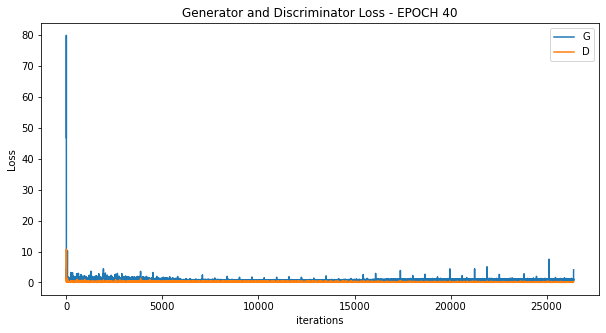

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


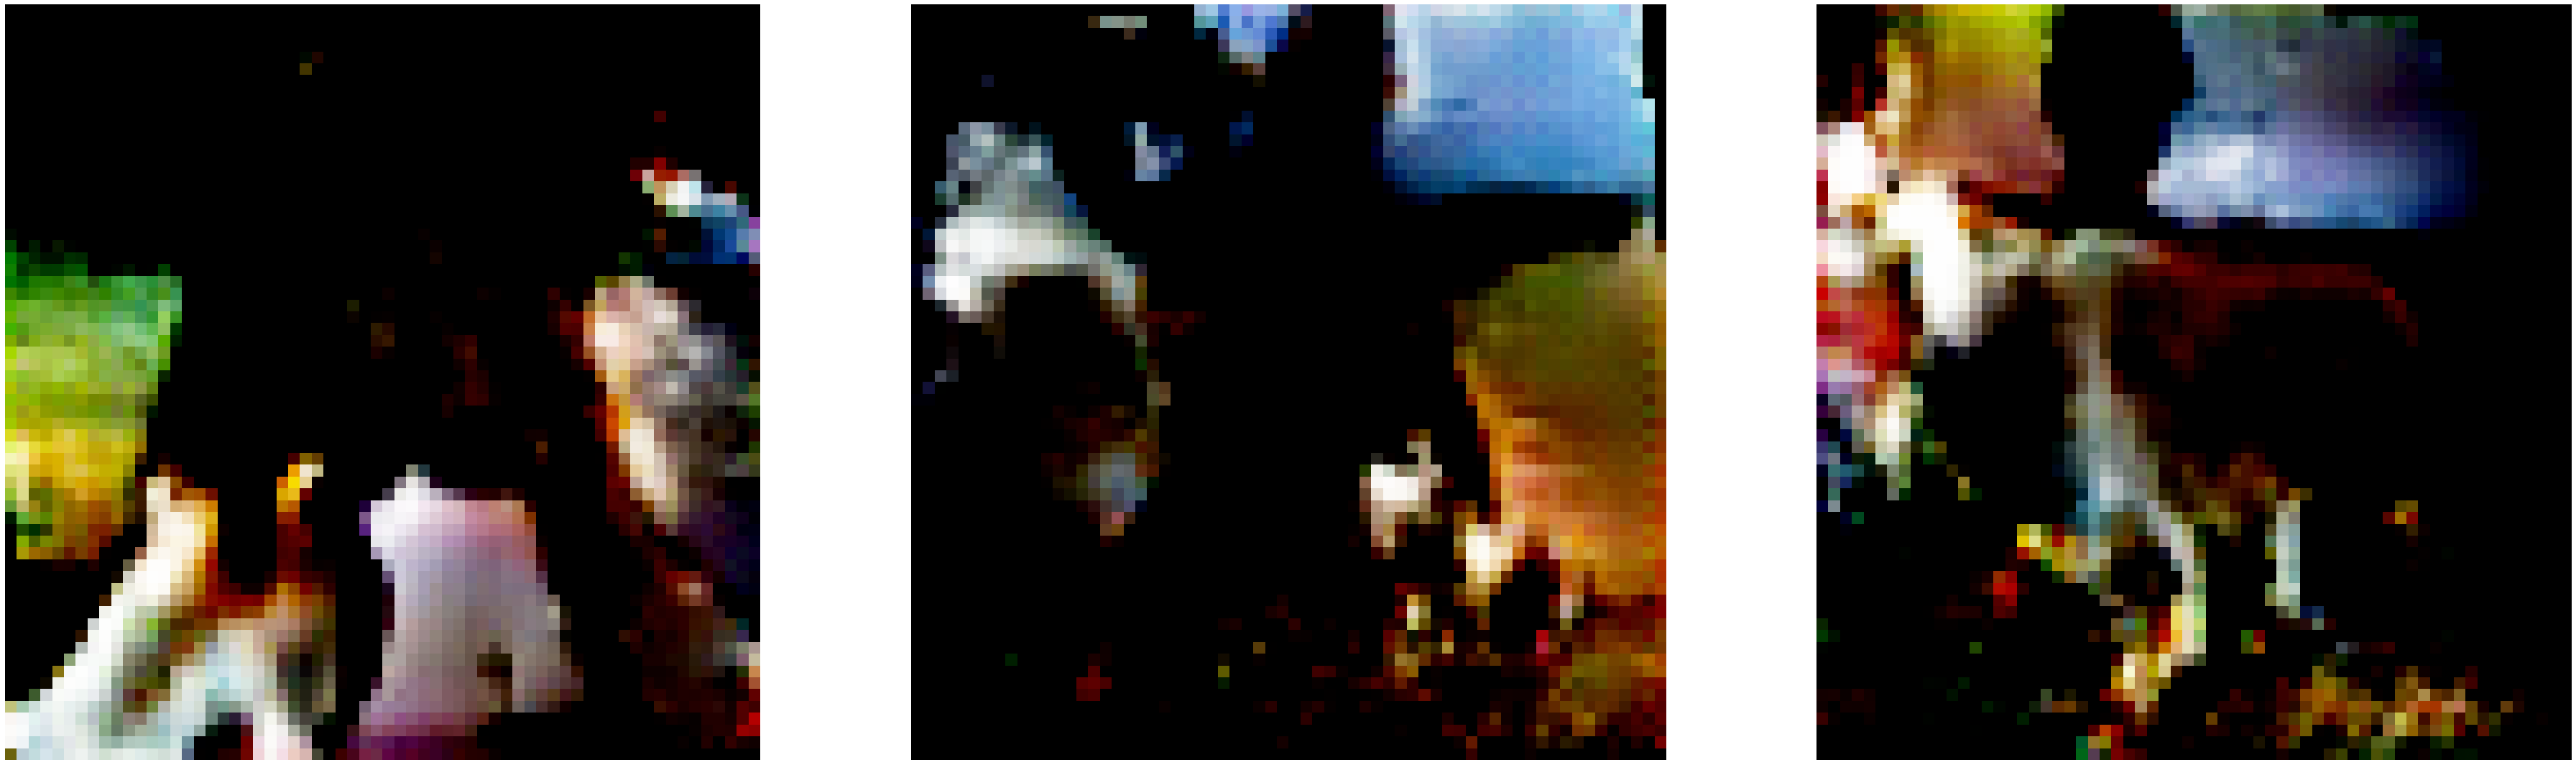

  0%|          | 0/644 [00:00<?, ?it/s]

[42/300][322/644] Loss_D: 0.0573 Loss_G: 1.0990
[42/300][644/644] Loss_D: 0.0047 Loss_G: 1.2118


  0%|          | 0/644 [00:00<?, ?it/s]

[43/300][322/644] Loss_D: 0.0768 Loss_G: 1.0313
[43/300][644/644] Loss_D: 0.3676 Loss_G: 6.8663


  0%|          | 0/644 [00:00<?, ?it/s]

[44/300][322/644] Loss_D: 0.0744 Loss_G: 1.0158
[44/300][644/644] Loss_D: 0.6294 Loss_G: 10.5910


  0%|          | 0/644 [00:00<?, ?it/s]

[45/300][322/644] Loss_D: 0.0722 Loss_G: 0.9467
[45/300][644/644] Loss_D: 0.2089 Loss_G: 4.9905


  0%|          | 0/644 [00:00<?, ?it/s]

[46/300][322/644] Loss_D: 0.0491 Loss_G: 1.1166
[46/300][644/644] Loss_D: 0.0456 Loss_G: 0.8796


  0%|          | 0/644 [00:00<?, ?it/s]

[47/300][322/644] Loss_D: 0.0696 Loss_G: 1.0132
[47/300][644/644] Loss_D: 0.0594 Loss_G: 0.8627


  0%|          | 0/644 [00:00<?, ?it/s]

[48/300][322/644] Loss_D: 0.0611 Loss_G: 0.9423
[48/300][644/644] Loss_D: 0.1705 Loss_G: 4.2368


  0%|          | 0/644 [00:00<?, ?it/s]

[49/300][322/644] Loss_D: 0.0618 Loss_G: 1.0770
[49/300][644/644] Loss_D: 0.2094 Loss_G: 5.5505


  0%|          | 0/644 [00:00<?, ?it/s]

[50/300][322/644] Loss_D: 0.0806 Loss_G: 0.9792
[50/300][644/644] Loss_D: 0.6174 Loss_G: 2.2047


  0%|          | 0/644 [00:00<?, ?it/s]

[51/300][322/644] Loss_D: 0.0986 Loss_G: 0.6902
[51/300][644/644] Loss_D: 0.0357 Loss_G: 2.3399


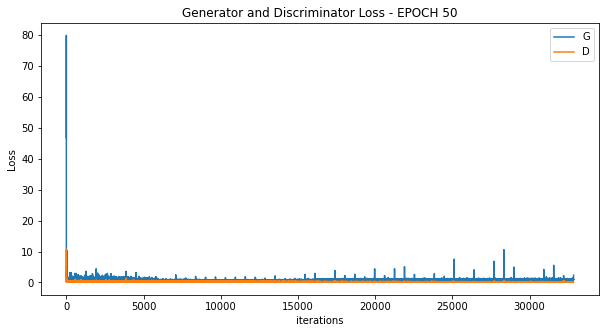

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


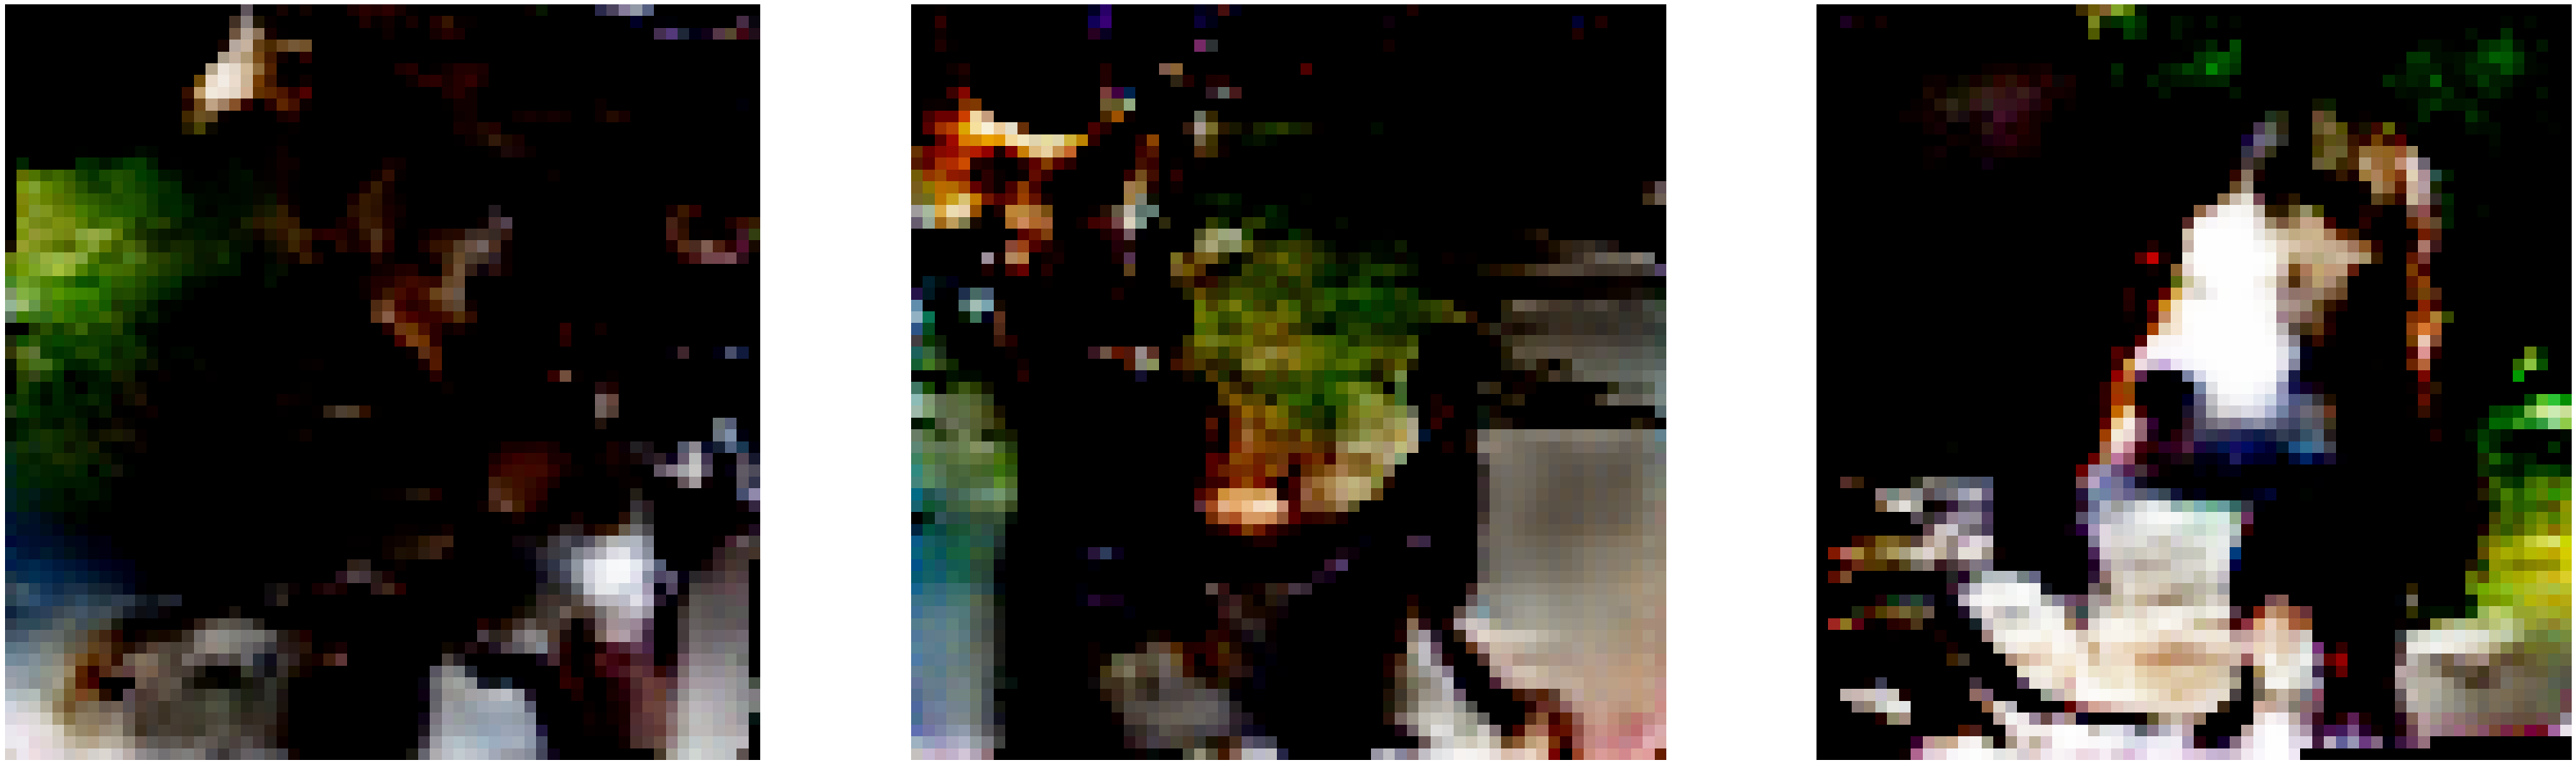

  0%|          | 0/644 [00:00<?, ?it/s]

[52/300][322/644] Loss_D: 0.0835 Loss_G: 0.9011
[52/300][644/644] Loss_D: 0.3798 Loss_G: 6.5929


  0%|          | 0/644 [00:00<?, ?it/s]

[53/300][322/644] Loss_D: 0.0723 Loss_G: 0.8106
[53/300][644/644] Loss_D: 0.0251 Loss_G: 1.1234


  0%|          | 0/644 [00:00<?, ?it/s]

[54/300][322/644] Loss_D: 0.0554 Loss_G: 0.9008
[54/300][644/644] Loss_D: 0.2302 Loss_G: 4.4872


  0%|          | 0/644 [00:00<?, ?it/s]

[55/300][322/644] Loss_D: 0.0289 Loss_G: 1.0648
[55/300][644/644] Loss_D: 0.2486 Loss_G: 3.7943


  0%|          | 0/644 [00:00<?, ?it/s]

[56/300][322/644] Loss_D: 0.1732 Loss_G: 0.7927
[56/300][644/644] Loss_D: 0.5993 Loss_G: 10.5270


  0%|          | 0/644 [00:00<?, ?it/s]

[57/300][322/644] Loss_D: 0.0613 Loss_G: 1.0357
[57/300][644/644] Loss_D: 0.2813 Loss_G: 9.1206


  0%|          | 0/644 [00:00<?, ?it/s]

[58/300][322/644] Loss_D: 0.0907 Loss_G: 1.2631
[58/300][644/644] Loss_D: 0.0891 Loss_G: 2.2652


  0%|          | 0/644 [00:00<?, ?it/s]

[59/300][322/644] Loss_D: 0.0570 Loss_G: 0.9802
[59/300][644/644] Loss_D: 0.0762 Loss_G: 0.2189


  0%|          | 0/644 [00:00<?, ?it/s]

[60/300][322/644] Loss_D: 0.0604 Loss_G: 1.0718
[60/300][644/644] Loss_D: 0.0654 Loss_G: 1.6026


  0%|          | 0/644 [00:00<?, ?it/s]

[61/300][322/644] Loss_D: 0.1009 Loss_G: 1.0414
[61/300][644/644] Loss_D: 0.0924 Loss_G: 6.1134


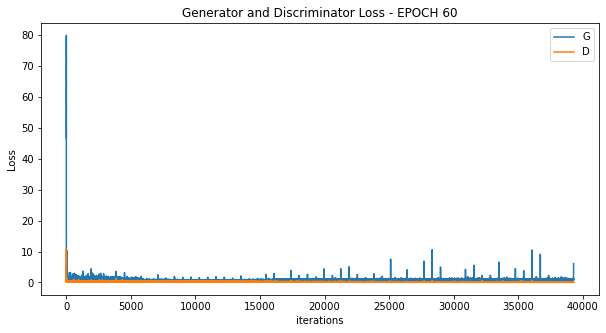

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


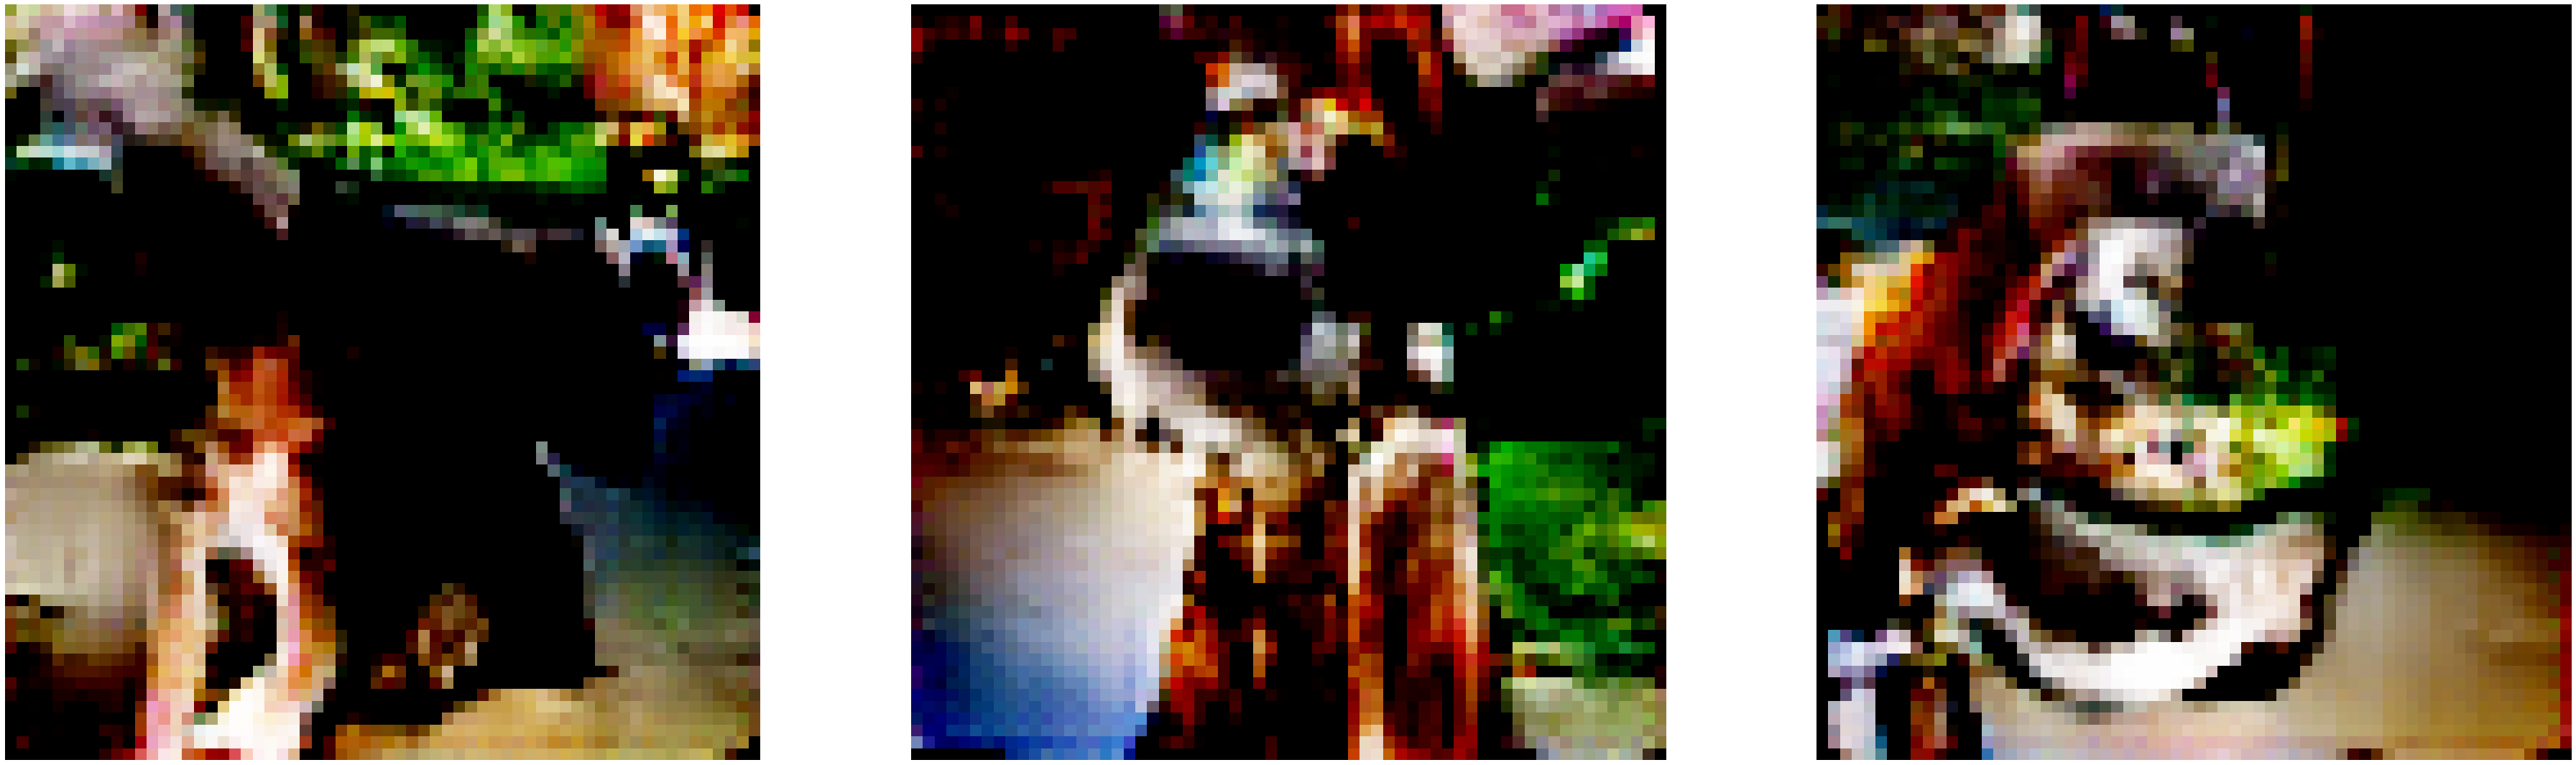

  0%|          | 0/644 [00:00<?, ?it/s]

[62/300][322/644] Loss_D: 0.0570 Loss_G: 1.0596
[62/300][644/644] Loss_D: 0.0338 Loss_G: 0.2258


  0%|          | 0/644 [00:00<?, ?it/s]

[63/300][322/644] Loss_D: 0.0489 Loss_G: 0.7849
[63/300][644/644] Loss_D: 0.0620 Loss_G: 0.2719


  0%|          | 0/644 [00:00<?, ?it/s]

[64/300][322/644] Loss_D: 0.1560 Loss_G: 0.7801
[64/300][644/644] Loss_D: 0.1201 Loss_G: 0.1829


  0%|          | 0/644 [00:00<?, ?it/s]

[65/300][322/644] Loss_D: 0.0635 Loss_G: 1.0789
[65/300][644/644] Loss_D: 0.0113 Loss_G: 2.4835


  0%|          | 0/644 [00:00<?, ?it/s]

[66/300][322/644] Loss_D: 0.0391 Loss_G: 0.9709
[66/300][644/644] Loss_D: 0.1319 Loss_G: 0.7552


  0%|          | 0/644 [00:00<?, ?it/s]

[67/300][322/644] Loss_D: 0.0492 Loss_G: 0.9618
[67/300][644/644] Loss_D: 0.1167 Loss_G: 5.9757


  0%|          | 0/644 [00:00<?, ?it/s]

[68/300][322/644] Loss_D: 0.0559 Loss_G: 1.0204
[68/300][644/644] Loss_D: 0.4664 Loss_G: 4.1023


  0%|          | 0/644 [00:00<?, ?it/s]

[69/300][322/644] Loss_D: 0.0352 Loss_G: 1.0424
[69/300][644/644] Loss_D: 0.0088 Loss_G: 0.8409


  0%|          | 0/644 [00:00<?, ?it/s]

[70/300][322/644] Loss_D: 0.0656 Loss_G: 0.9296
[70/300][644/644] Loss_D: 0.0380 Loss_G: 2.0778


  0%|          | 0/644 [00:00<?, ?it/s]

[71/300][322/644] Loss_D: 0.0271 Loss_G: 1.0189
[71/300][644/644] Loss_D: 0.0860 Loss_G: 1.4141


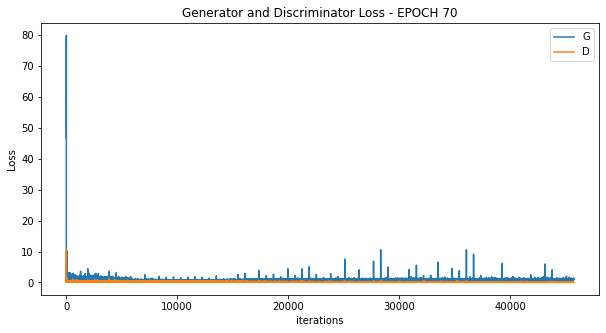

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


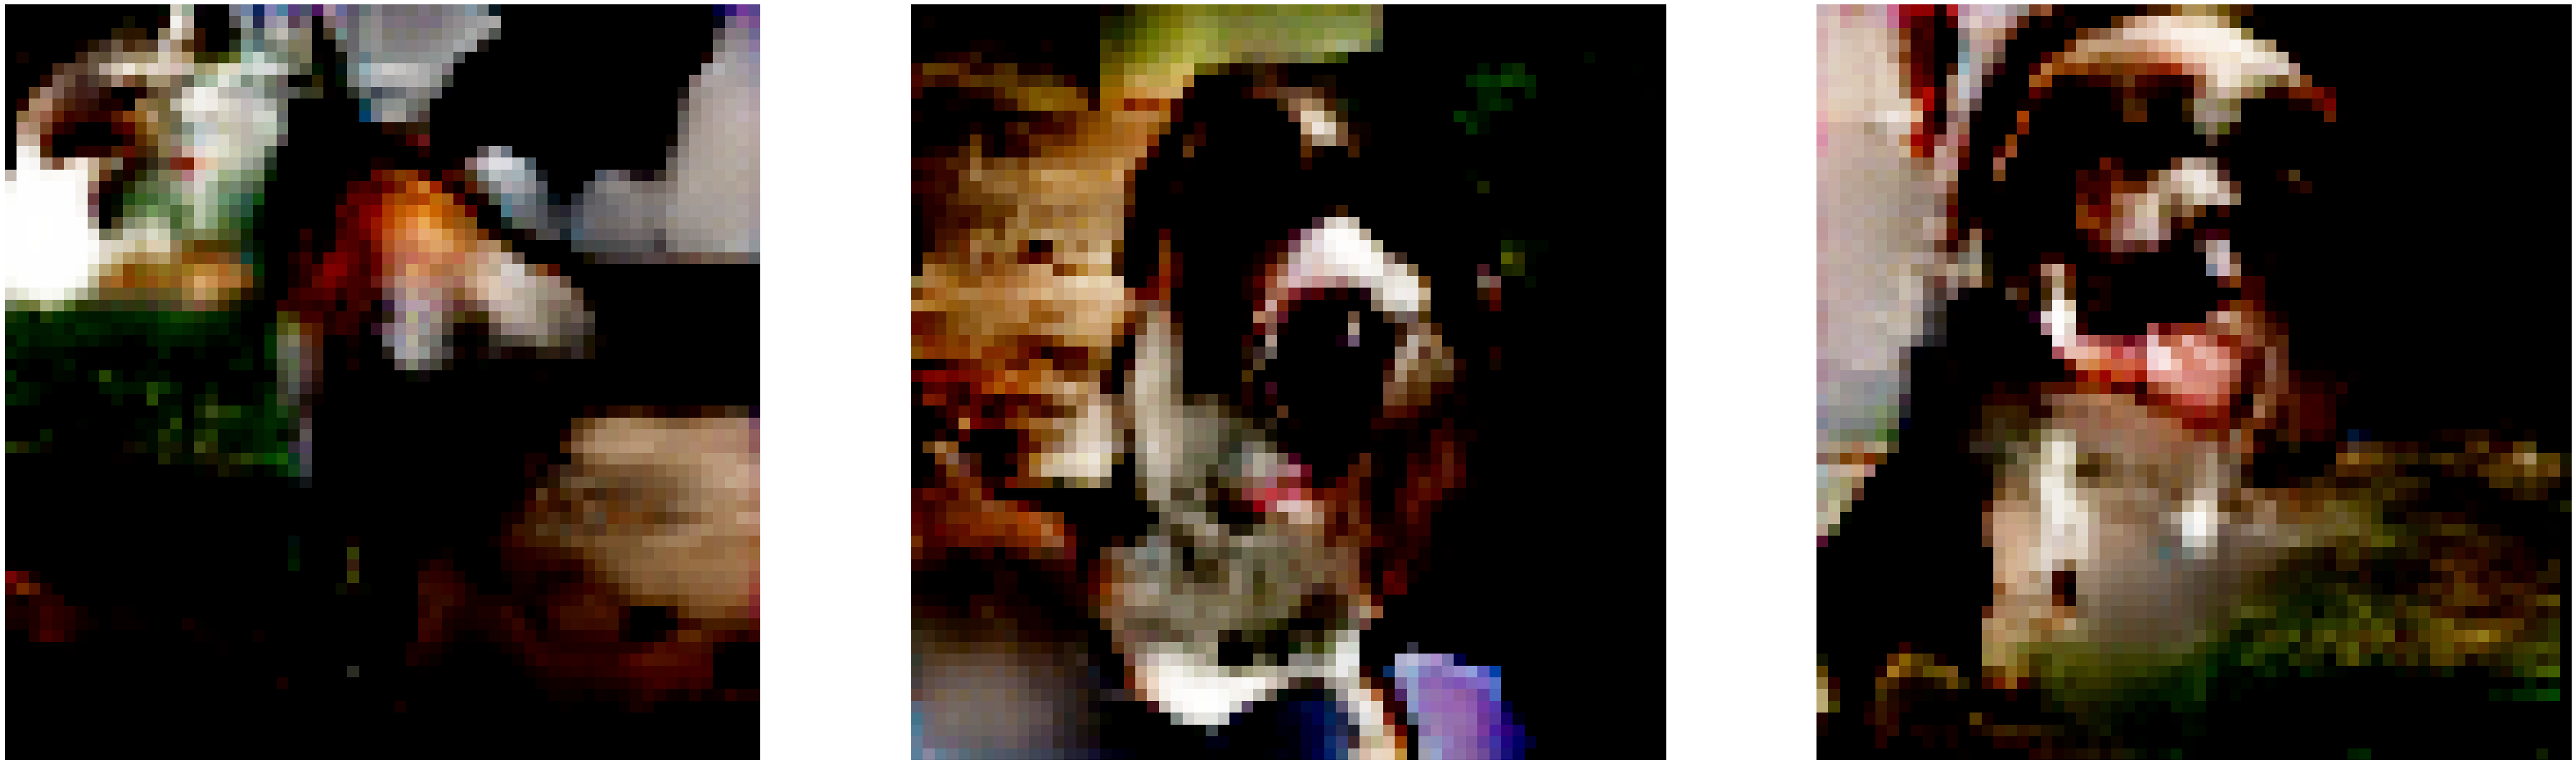

  0%|          | 0/644 [00:00<?, ?it/s]

[72/300][322/644] Loss_D: 0.0535 Loss_G: 0.8973
[72/300][644/644] Loss_D: 0.1759 Loss_G: 1.7238


  0%|          | 0/644 [00:00<?, ?it/s]

[73/300][322/644] Loss_D: 0.0391 Loss_G: 1.0875
[73/300][644/644] Loss_D: 0.0406 Loss_G: 0.0589


  0%|          | 0/644 [00:00<?, ?it/s]

[74/300][322/644] Loss_D: 0.0461 Loss_G: 0.9867
[74/300][644/644] Loss_D: 0.0295 Loss_G: 1.8884


  0%|          | 0/644 [00:00<?, ?it/s]

[75/300][322/644] Loss_D: 0.0578 Loss_G: 0.9679
[75/300][644/644] Loss_D: 0.2654 Loss_G: 8.4330


  0%|          | 0/644 [00:00<?, ?it/s]

[76/300][322/644] Loss_D: 0.0450 Loss_G: 0.9554
[76/300][644/644] Loss_D: 0.2138 Loss_G: 8.7927


  0%|          | 0/644 [00:00<?, ?it/s]

[77/300][322/644] Loss_D: 0.1271 Loss_G: 2.0453
[77/300][644/644] Loss_D: 0.1080 Loss_G: 0.6475


  0%|          | 0/644 [00:00<?, ?it/s]

[78/300][322/644] Loss_D: 0.0536 Loss_G: 1.0321
[78/300][644/644] Loss_D: 0.0346 Loss_G: 3.7844


  0%|          | 0/644 [00:00<?, ?it/s]

[79/300][322/644] Loss_D: 0.0804 Loss_G: 0.9717
[79/300][644/644] Loss_D: 0.2932 Loss_G: 9.5607


  0%|          | 0/644 [00:00<?, ?it/s]

[80/300][322/644] Loss_D: 0.0483 Loss_G: 1.0452
[80/300][644/644] Loss_D: 0.0903 Loss_G: 4.1180


  0%|          | 0/644 [00:00<?, ?it/s]

[81/300][322/644] Loss_D: 0.0494 Loss_G: 1.1108
[81/300][644/644] Loss_D: 0.0726 Loss_G: 0.1557


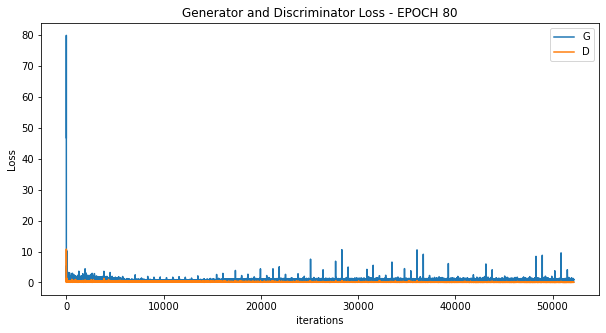

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


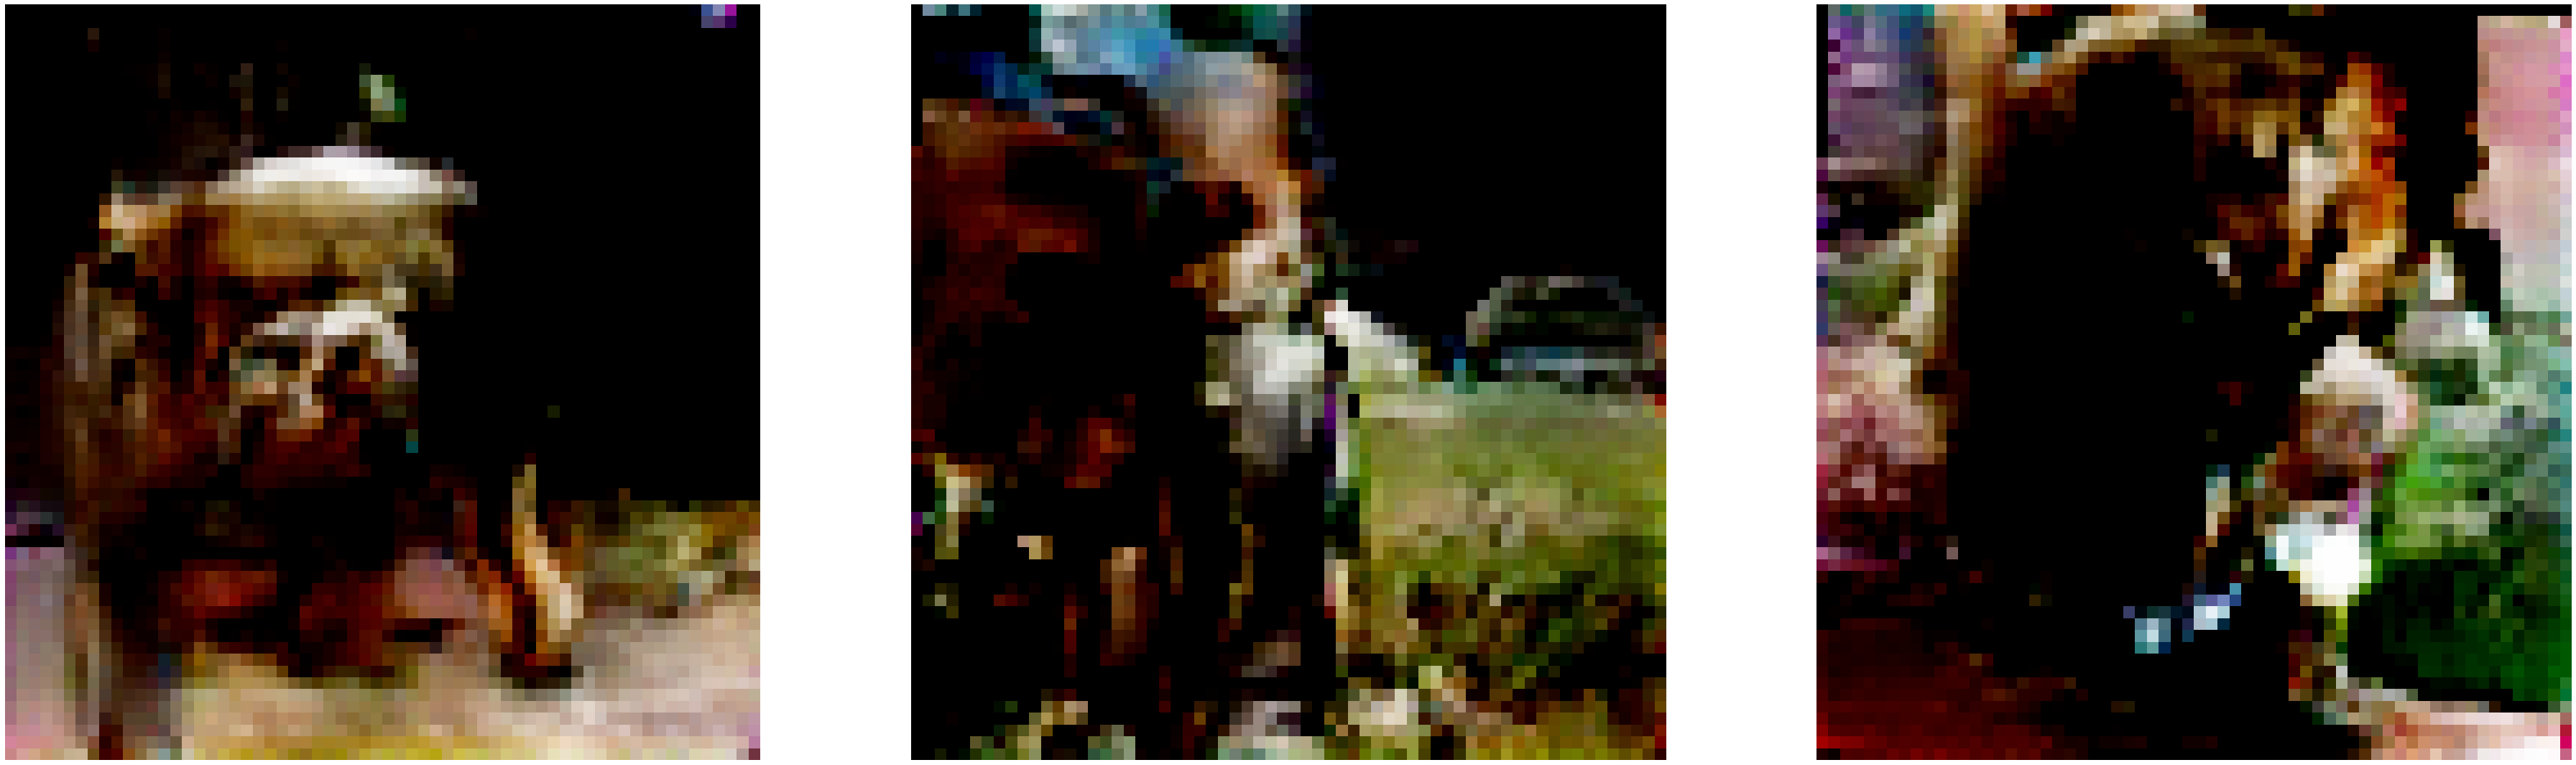

  0%|          | 0/644 [00:00<?, ?it/s]

[82/300][322/644] Loss_D: 0.0402 Loss_G: 1.1711
[82/300][644/644] Loss_D: 0.0153 Loss_G: 3.3898


  0%|          | 0/644 [00:00<?, ?it/s]

[83/300][322/644] Loss_D: 0.0565 Loss_G: 1.0518
[83/300][644/644] Loss_D: 0.7313 Loss_G: 4.5569


  0%|          | 0/644 [00:00<?, ?it/s]

[84/300][322/644] Loss_D: 0.0437 Loss_G: 1.1180
[84/300][644/644] Loss_D: 0.0589 Loss_G: 0.3515


  0%|          | 0/644 [00:00<?, ?it/s]

[85/300][322/644] Loss_D: 0.0677 Loss_G: 1.0388
[85/300][644/644] Loss_D: 0.0866 Loss_G: 5.7451


  0%|          | 0/644 [00:00<?, ?it/s]

[86/300][322/644] Loss_D: 0.0825 Loss_G: 1.0354
[86/300][644/644] Loss_D: 0.0466 Loss_G: 4.4515


  0%|          | 0/644 [00:00<?, ?it/s]

[87/300][322/644] Loss_D: 0.0290 Loss_G: 0.9457
[87/300][644/644] Loss_D: 0.0139 Loss_G: 1.7899


  0%|          | 0/644 [00:00<?, ?it/s]

[88/300][322/644] Loss_D: 0.0280 Loss_G: 1.0133
[88/300][644/644] Loss_D: 0.3310 Loss_G: 12.1442


  0%|          | 0/644 [00:00<?, ?it/s]

[89/300][322/644] Loss_D: 0.0442 Loss_G: 0.9532
[89/300][644/644] Loss_D: 0.0175 Loss_G: 1.0435


  0%|          | 0/644 [00:00<?, ?it/s]

[90/300][322/644] Loss_D: 0.0585 Loss_G: 1.0058
[90/300][644/644] Loss_D: 0.0063 Loss_G: 0.3370


  0%|          | 0/644 [00:00<?, ?it/s]

[91/300][322/644] Loss_D: 0.0366 Loss_G: 1.0266
[91/300][644/644] Loss_D: 0.0555 Loss_G: 0.0763


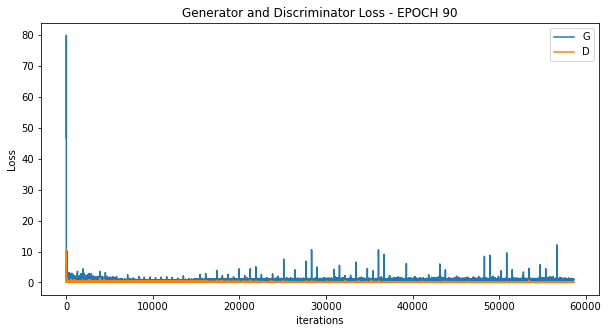

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


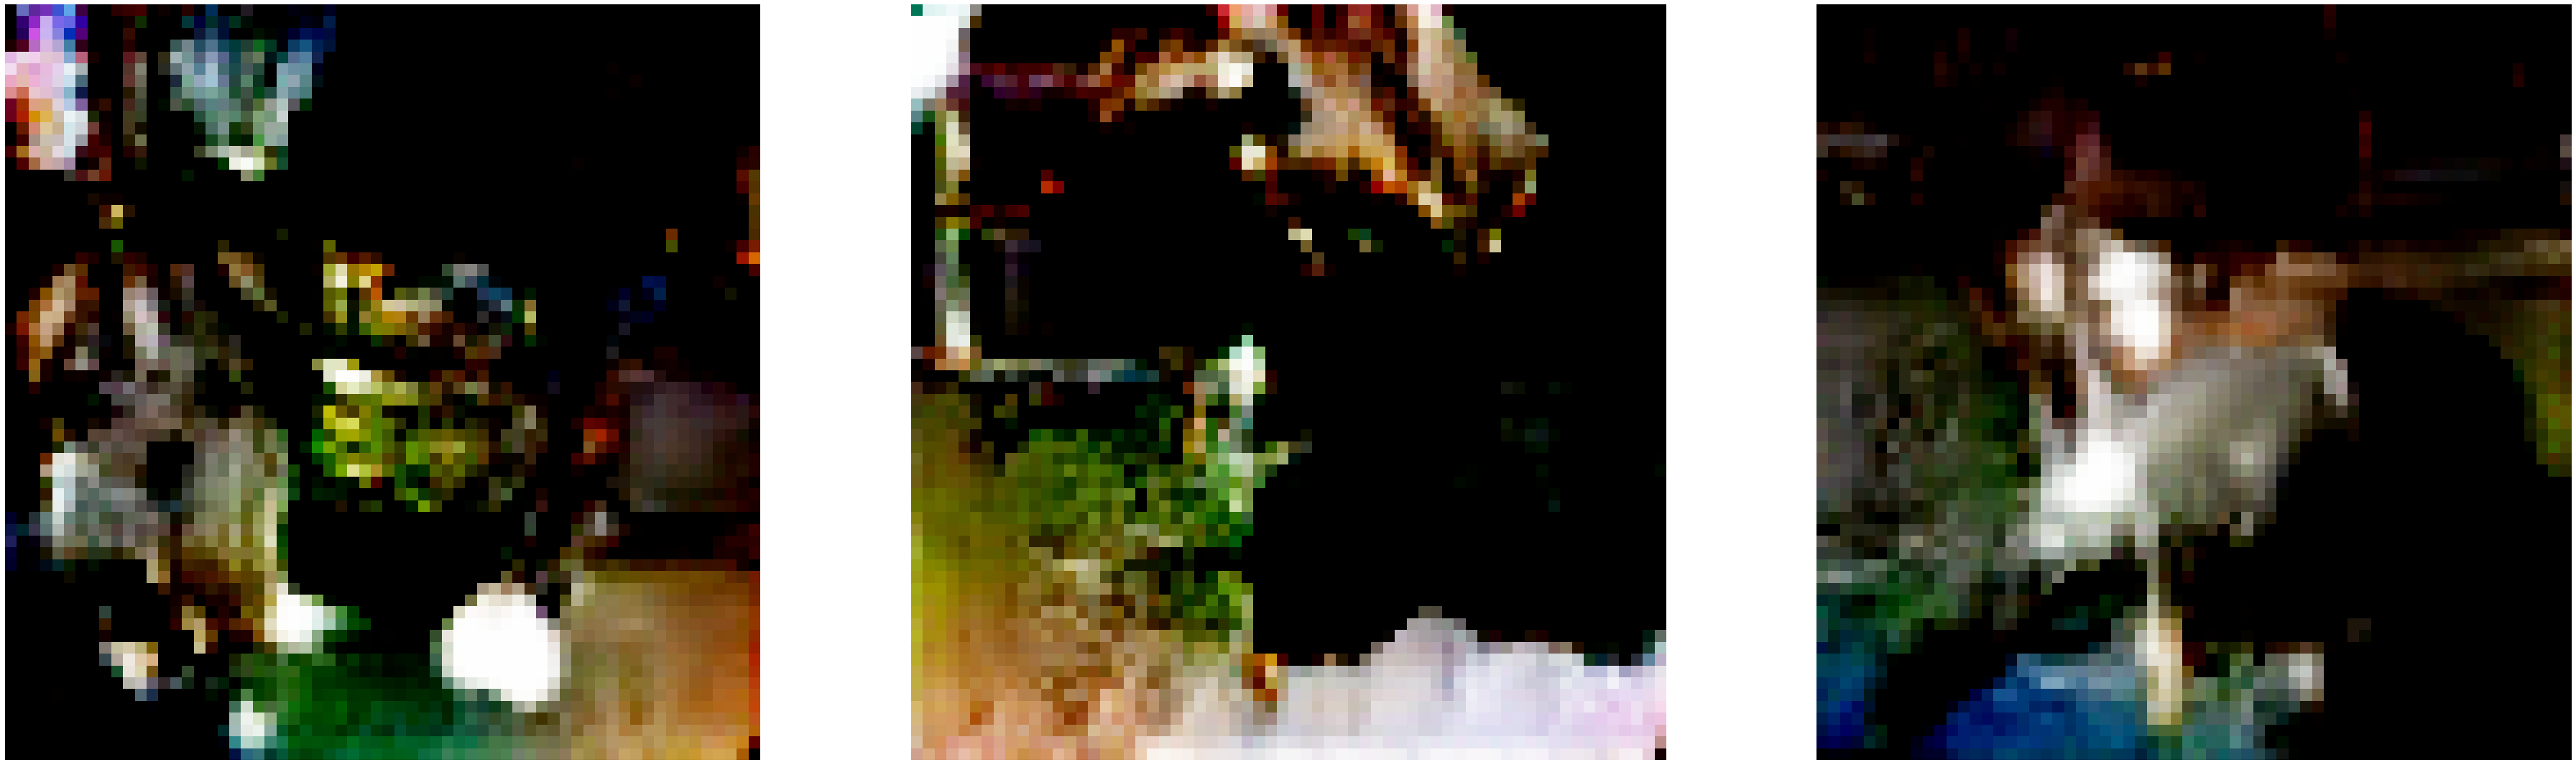

  0%|          | 0/644 [00:00<?, ?it/s]

[92/300][322/644] Loss_D: 0.0744 Loss_G: 0.9099
[92/300][644/644] Loss_D: 0.1762 Loss_G: 8.7830


  0%|          | 0/644 [00:00<?, ?it/s]

[93/300][322/644] Loss_D: 0.0520 Loss_G: 1.0347
[93/300][644/644] Loss_D: 0.0103 Loss_G: 2.2375


  0%|          | 0/644 [00:00<?, ?it/s]

[94/300][322/644] Loss_D: 0.0437 Loss_G: 1.0991
[94/300][644/644] Loss_D: 0.0872 Loss_G: 6.6816


  0%|          | 0/644 [00:00<?, ?it/s]

[95/300][322/644] Loss_D: 0.0428 Loss_G: 0.9714
[95/300][644/644] Loss_D: 0.1568 Loss_G: 7.1870


  0%|          | 0/644 [00:00<?, ?it/s]

[96/300][322/644] Loss_D: 0.0761 Loss_G: 0.9170
[96/300][644/644] Loss_D: 0.1206 Loss_G: 4.6398


  0%|          | 0/644 [00:00<?, ?it/s]

[97/300][322/644] Loss_D: 0.1199 Loss_G: 0.8225
[97/300][644/644] Loss_D: 0.0950 Loss_G: 0.3174


  0%|          | 0/644 [00:00<?, ?it/s]

[98/300][322/644] Loss_D: 0.0586 Loss_G: 0.9237
[98/300][644/644] Loss_D: 0.0981 Loss_G: 8.2059


  0%|          | 0/644 [00:00<?, ?it/s]

[99/300][322/644] Loss_D: 0.0860 Loss_G: 0.9616
[99/300][644/644] Loss_D: 0.0051 Loss_G: 2.0064


  0%|          | 0/644 [00:00<?, ?it/s]

[100/300][322/644] Loss_D: 0.1161 Loss_G: 0.8872
[100/300][644/644] Loss_D: 0.0630 Loss_G: 0.0837


  0%|          | 0/644 [00:00<?, ?it/s]

[101/300][322/644] Loss_D: 0.0407 Loss_G: 1.0401
[101/300][644/644] Loss_D: 0.6263 Loss_G: 5.9126


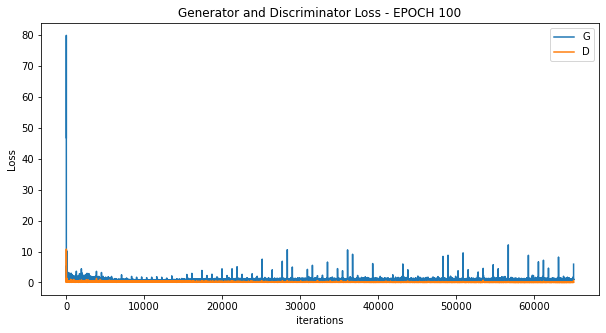

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


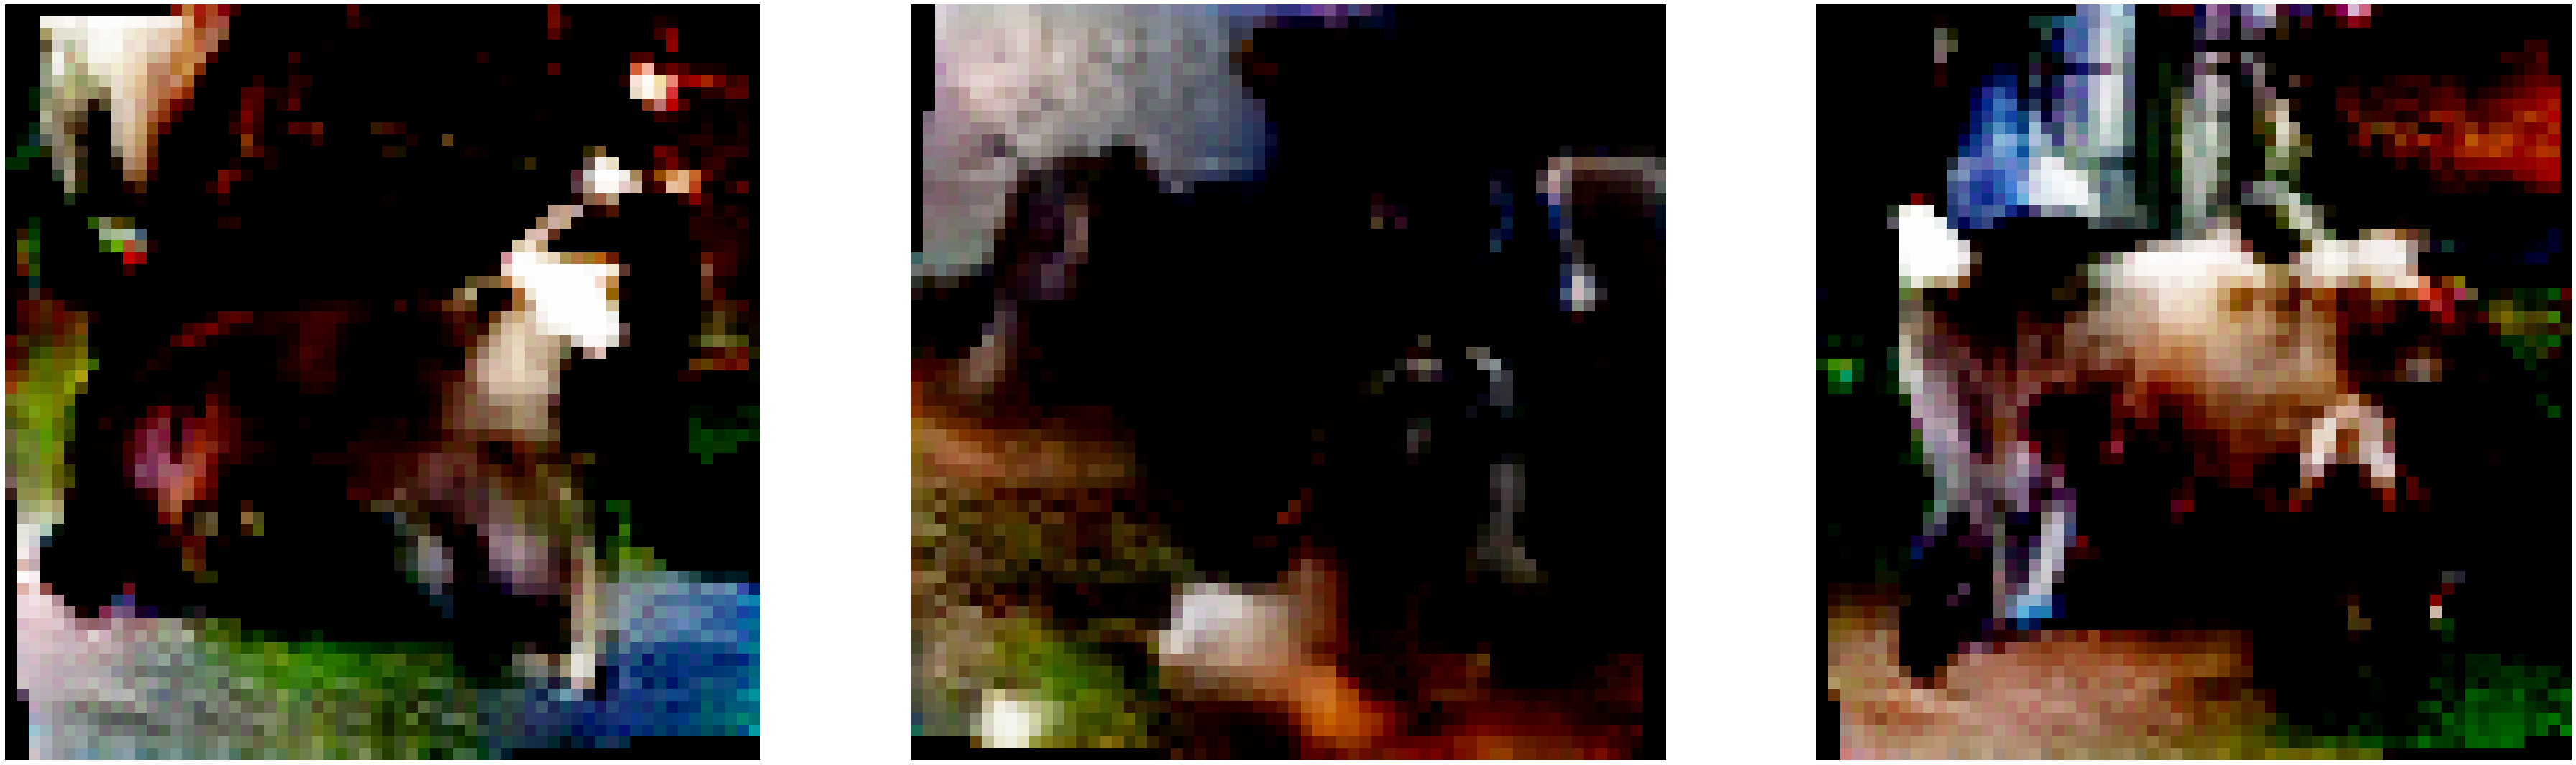

  0%|          | 0/644 [00:00<?, ?it/s]

[102/300][322/644] Loss_D: 0.0309 Loss_G: 1.0358
[102/300][644/644] Loss_D: 0.0413 Loss_G: 0.1880


  0%|          | 0/644 [00:00<?, ?it/s]

[103/300][322/644] Loss_D: 0.1501 Loss_G: 0.8829
[103/300][644/644] Loss_D: 0.0236 Loss_G: 1.7610


  0%|          | 0/644 [00:00<?, ?it/s]

[104/300][322/644] Loss_D: 0.0297 Loss_G: 1.0705
[104/300][644/644] Loss_D: 0.1167 Loss_G: 0.5879


  0%|          | 0/644 [00:00<?, ?it/s]

[105/300][322/644] Loss_D: 0.0387 Loss_G: 1.0396
[105/300][644/644] Loss_D: 0.1453 Loss_G: 9.9820


  0%|          | 0/644 [00:00<?, ?it/s]

[106/300][322/644] Loss_D: 0.0628 Loss_G: 1.0629
[106/300][644/644] Loss_D: 0.0161 Loss_G: 2.6353


  0%|          | 0/644 [00:00<?, ?it/s]

[107/300][322/644] Loss_D: 0.0438 Loss_G: 1.0120
[107/300][644/644] Loss_D: 0.0019 Loss_G: 1.2042


  0%|          | 0/644 [00:00<?, ?it/s]

[108/300][322/644] Loss_D: 0.0540 Loss_G: 0.9671
[108/300][644/644] Loss_D: 0.0341 Loss_G: 3.4648


  0%|          | 0/644 [00:00<?, ?it/s]

[109/300][322/644] Loss_D: 0.0433 Loss_G: 0.9714
[109/300][644/644] Loss_D: 0.0465 Loss_G: 5.2074


  0%|          | 0/644 [00:00<?, ?it/s]

[110/300][322/644] Loss_D: 0.0716 Loss_G: 1.0414
[110/300][644/644] Loss_D: 0.0029 Loss_G: 1.1759


  0%|          | 0/644 [00:00<?, ?it/s]

[111/300][322/644] Loss_D: 0.0372 Loss_G: 1.0886
[111/300][644/644] Loss_D: 0.0809 Loss_G: 0.4240


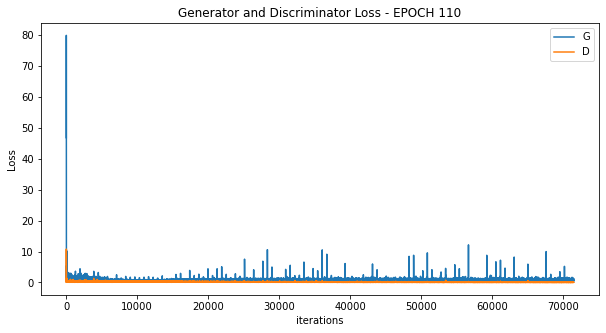

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


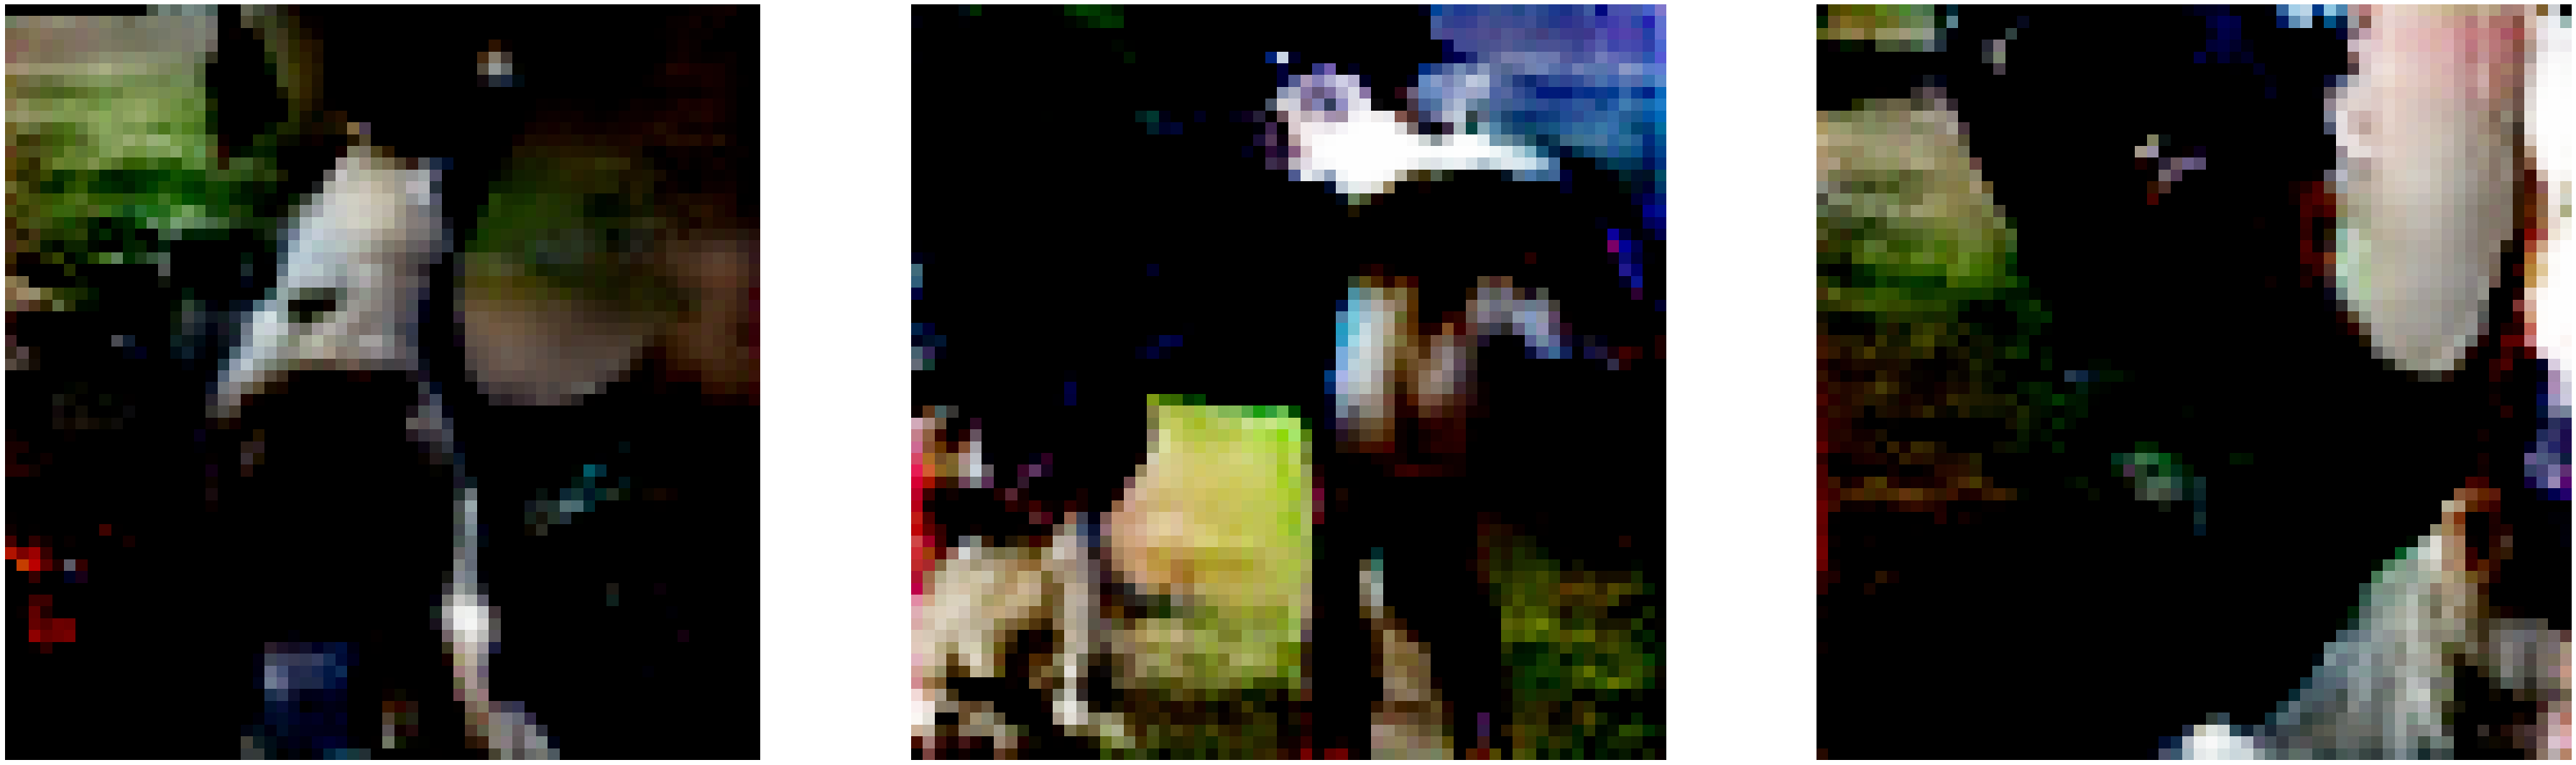

  0%|          | 0/644 [00:00<?, ?it/s]

[112/300][322/644] Loss_D: 0.0624 Loss_G: 0.9617
[112/300][644/644] Loss_D: 0.4280 Loss_G: 7.2358


  0%|          | 0/644 [00:00<?, ?it/s]

[113/300][322/644] Loss_D: 0.0644 Loss_G: 1.0359
[113/300][644/644] Loss_D: 0.0132 Loss_G: 0.4947


  0%|          | 0/644 [00:00<?, ?it/s]

[114/300][322/644] Loss_D: 0.0350 Loss_G: 1.1003
[114/300][644/644] Loss_D: 0.0277 Loss_G: 0.6824


  0%|          | 0/644 [00:00<?, ?it/s]

[115/300][322/644] Loss_D: 0.0304 Loss_G: 1.0202
[115/300][644/644] Loss_D: 0.6219 Loss_G: 14.1013


  0%|          | 0/644 [00:00<?, ?it/s]

[116/300][322/644] Loss_D: 0.0381 Loss_G: 1.0695
[116/300][644/644] Loss_D: 0.0226 Loss_G: 0.0476


  0%|          | 0/644 [00:00<?, ?it/s]

[117/300][322/644] Loss_D: 0.0304 Loss_G: 1.0465
[117/300][644/644] Loss_D: 0.0361 Loss_G: 0.1355


  0%|          | 0/644 [00:00<?, ?it/s]

[118/300][322/644] Loss_D: 0.0212 Loss_G: 0.9762
[118/300][644/644] Loss_D: 0.0142 Loss_G: 1.3296


  0%|          | 0/644 [00:00<?, ?it/s]

[119/300][322/644] Loss_D: 0.0996 Loss_G: 0.9583
[119/300][644/644] Loss_D: 0.1060 Loss_G: 6.1082


  0%|          | 0/644 [00:00<?, ?it/s]

[120/300][322/644] Loss_D: 0.0254 Loss_G: 1.0091
[120/300][644/644] Loss_D: 0.1374 Loss_G: 9.5510


  0%|          | 0/644 [00:00<?, ?it/s]

[121/300][322/644] Loss_D: 0.0834 Loss_G: 1.1377
[121/300][644/644] Loss_D: 0.1770 Loss_G: 7.8696


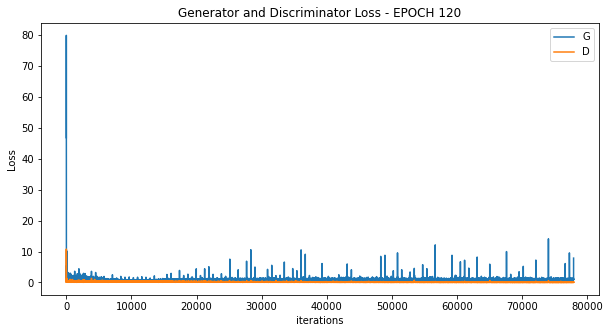

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


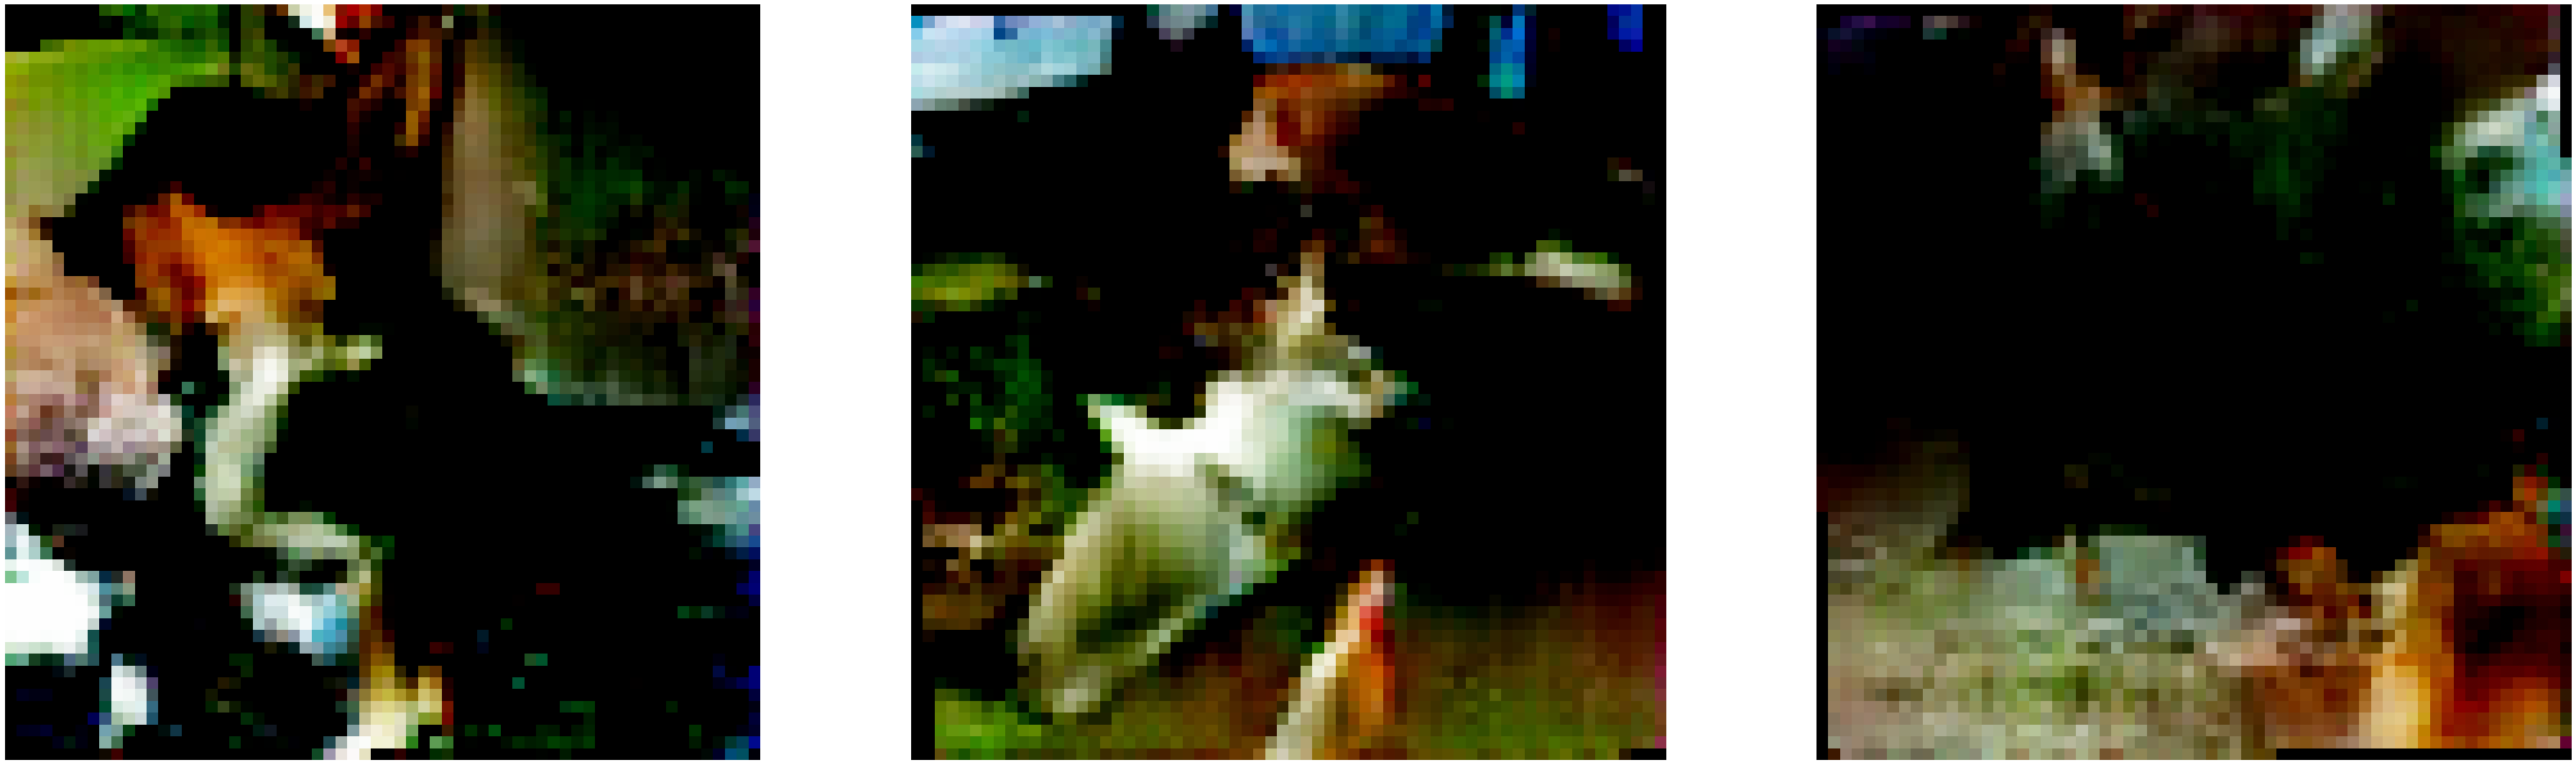

  0%|          | 0/644 [00:00<?, ?it/s]

[122/300][322/644] Loss_D: 0.0251 Loss_G: 0.9598
[122/300][644/644] Loss_D: 0.3750 Loss_G: 9.7959


  0%|          | 0/644 [00:00<?, ?it/s]

[123/300][322/644] Loss_D: 0.0325 Loss_G: 1.0326
[123/300][644/644] Loss_D: 0.1229 Loss_G: 6.0157


  0%|          | 0/644 [00:00<?, ?it/s]

[124/300][322/644] Loss_D: 0.0317 Loss_G: 1.0216
[124/300][644/644] Loss_D: 0.2021 Loss_G: 7.9543


  0%|          | 0/644 [00:00<?, ?it/s]

[125/300][322/644] Loss_D: 0.0943 Loss_G: 1.1008
[125/300][644/644] Loss_D: 0.0326 Loss_G: 3.8762


  0%|          | 0/644 [00:00<?, ?it/s]

[126/300][322/644] Loss_D: 0.0345 Loss_G: 1.1128
[126/300][644/644] Loss_D: 0.0511 Loss_G: 0.0657


  0%|          | 0/644 [00:00<?, ?it/s]

[127/300][322/644] Loss_D: 0.0292 Loss_G: 1.1378
[127/300][644/644] Loss_D: 0.3662 Loss_G: 11.0831


  0%|          | 0/644 [00:00<?, ?it/s]

[128/300][322/644] Loss_D: 0.0674 Loss_G: 0.7816
[128/300][644/644] Loss_D: 0.0100 Loss_G: 1.0596


  0%|          | 0/644 [00:00<?, ?it/s]

[129/300][322/644] Loss_D: 0.0174 Loss_G: 0.9952
[129/300][644/644] Loss_D: 0.0446 Loss_G: 0.1117


  0%|          | 0/644 [00:00<?, ?it/s]

[130/300][322/644] Loss_D: 0.1072 Loss_G: 1.0508
[130/300][644/644] Loss_D: 0.0567 Loss_G: 5.5283


  0%|          | 0/644 [00:00<?, ?it/s]

[131/300][322/644] Loss_D: 0.0473 Loss_G: 0.8493
[131/300][644/644] Loss_D: 0.0225 Loss_G: 2.3971


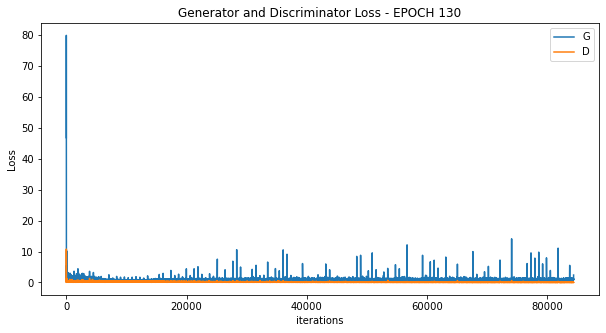

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


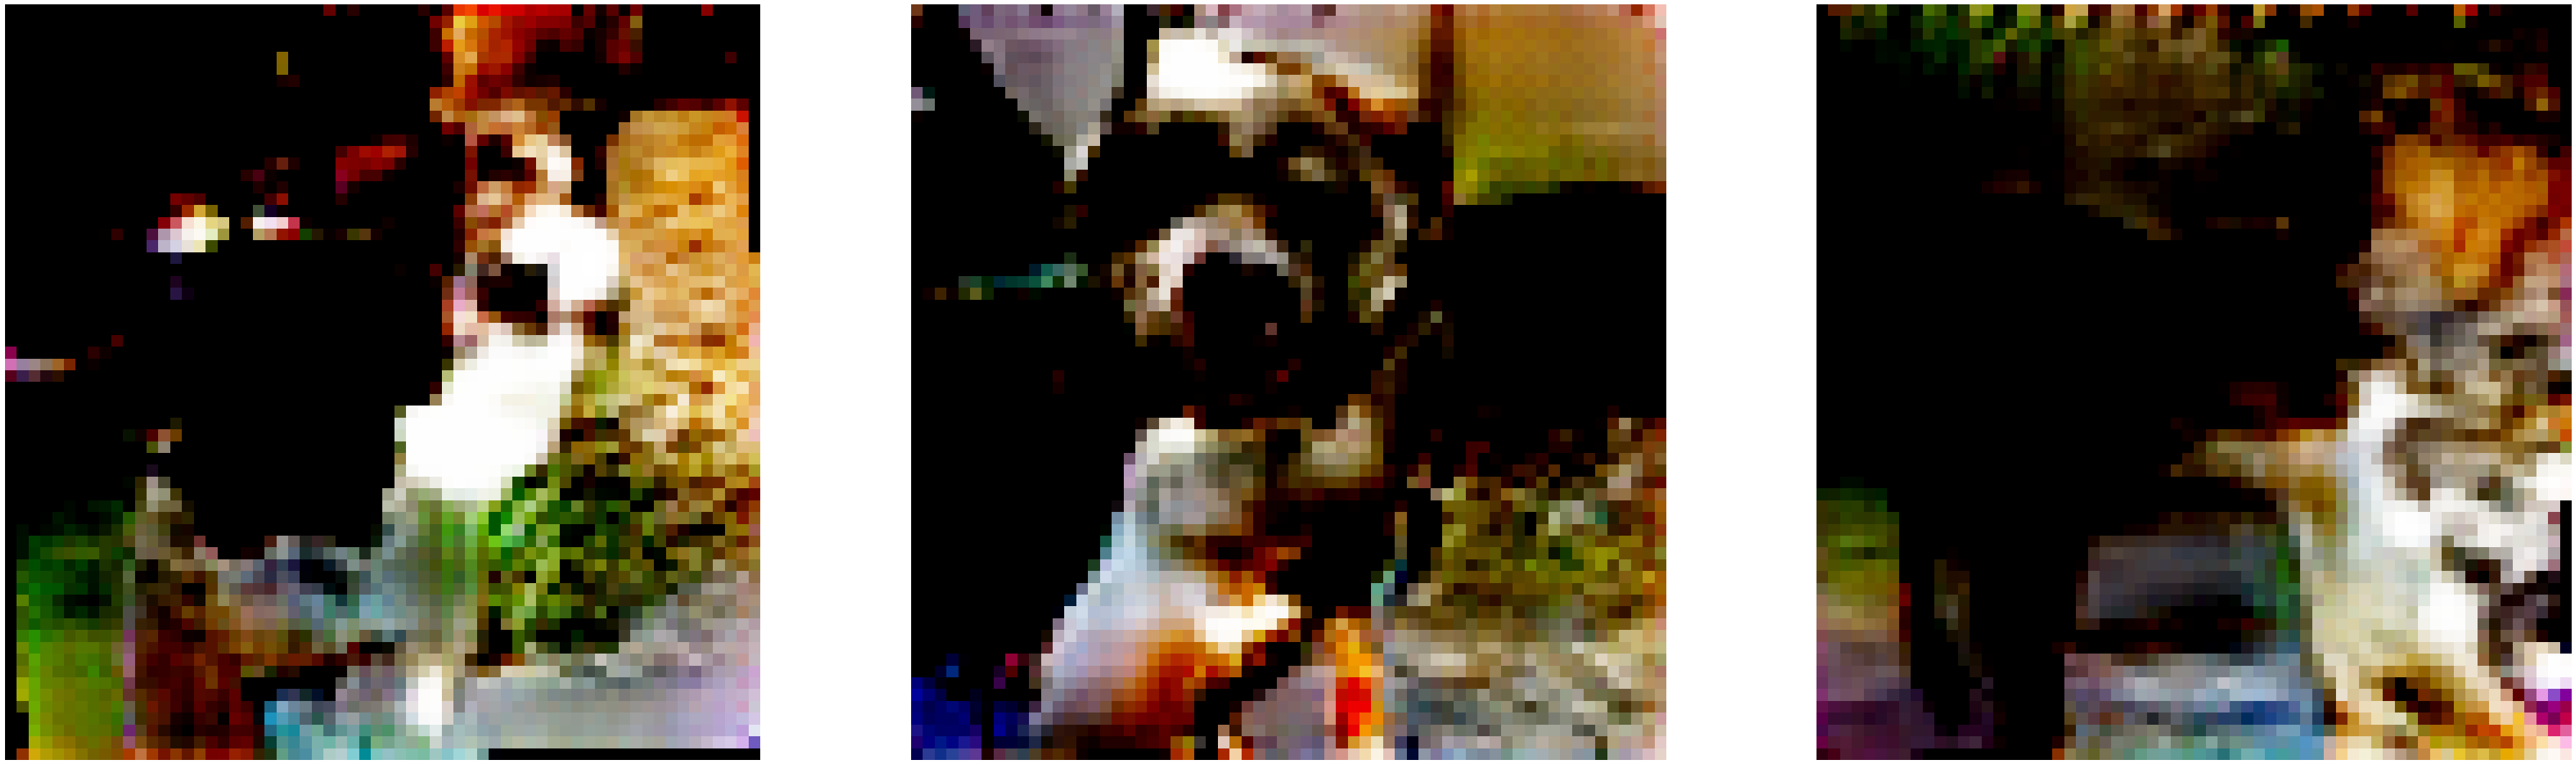

  0%|          | 0/644 [00:00<?, ?it/s]

[132/300][322/644] Loss_D: 0.0575 Loss_G: 0.9423
[132/300][644/644] Loss_D: 0.2791 Loss_G: 2.3982


  0%|          | 0/644 [00:00<?, ?it/s]

[133/300][322/644] Loss_D: 0.0259 Loss_G: 1.0690
[133/300][644/644] Loss_D: 0.0195 Loss_G: 1.8610


  0%|          | 0/644 [00:00<?, ?it/s]

[134/300][322/644] Loss_D: 0.0681 Loss_G: 0.9072
[134/300][644/644] Loss_D: 0.1728 Loss_G: 8.7938


  0%|          | 0/644 [00:00<?, ?it/s]

[135/300][322/644] Loss_D: 0.0417 Loss_G: 1.0425
[135/300][644/644] Loss_D: 0.2908 Loss_G: 6.6237


  0%|          | 0/644 [00:00<?, ?it/s]

[136/300][322/644] Loss_D: 0.0395 Loss_G: 1.3414
[136/300][644/644] Loss_D: 0.2003 Loss_G: 10.4308


  0%|          | 0/644 [00:00<?, ?it/s]

[137/300][322/644] Loss_D: 0.0399 Loss_G: 0.9826
[137/300][644/644] Loss_D: 0.0275 Loss_G: 3.1007


  0%|          | 0/644 [00:00<?, ?it/s]

[138/300][322/644] Loss_D: 0.0181 Loss_G: 1.0044
[138/300][644/644] Loss_D: 0.6983 Loss_G: 13.3875


  0%|          | 0/644 [00:00<?, ?it/s]

[139/300][322/644] Loss_D: 0.0233 Loss_G: 1.0279
[139/300][644/644] Loss_D: 0.1352 Loss_G: 9.0699


  0%|          | 0/644 [00:00<?, ?it/s]

[140/300][322/644] Loss_D: 0.0821 Loss_G: 0.8539
[140/300][644/644] Loss_D: 0.1275 Loss_G: 7.9031


  0%|          | 0/644 [00:00<?, ?it/s]

[141/300][322/644] Loss_D: 0.0751 Loss_G: 0.8529
[141/300][644/644] Loss_D: 0.1076 Loss_G: 0.8749


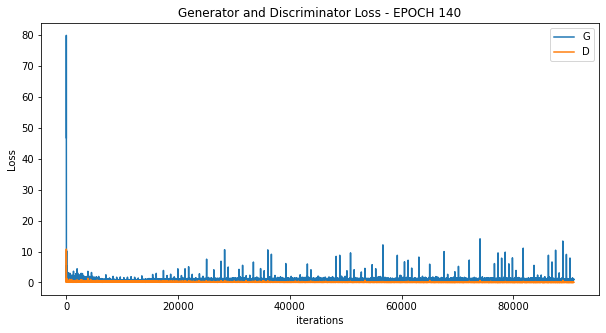

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


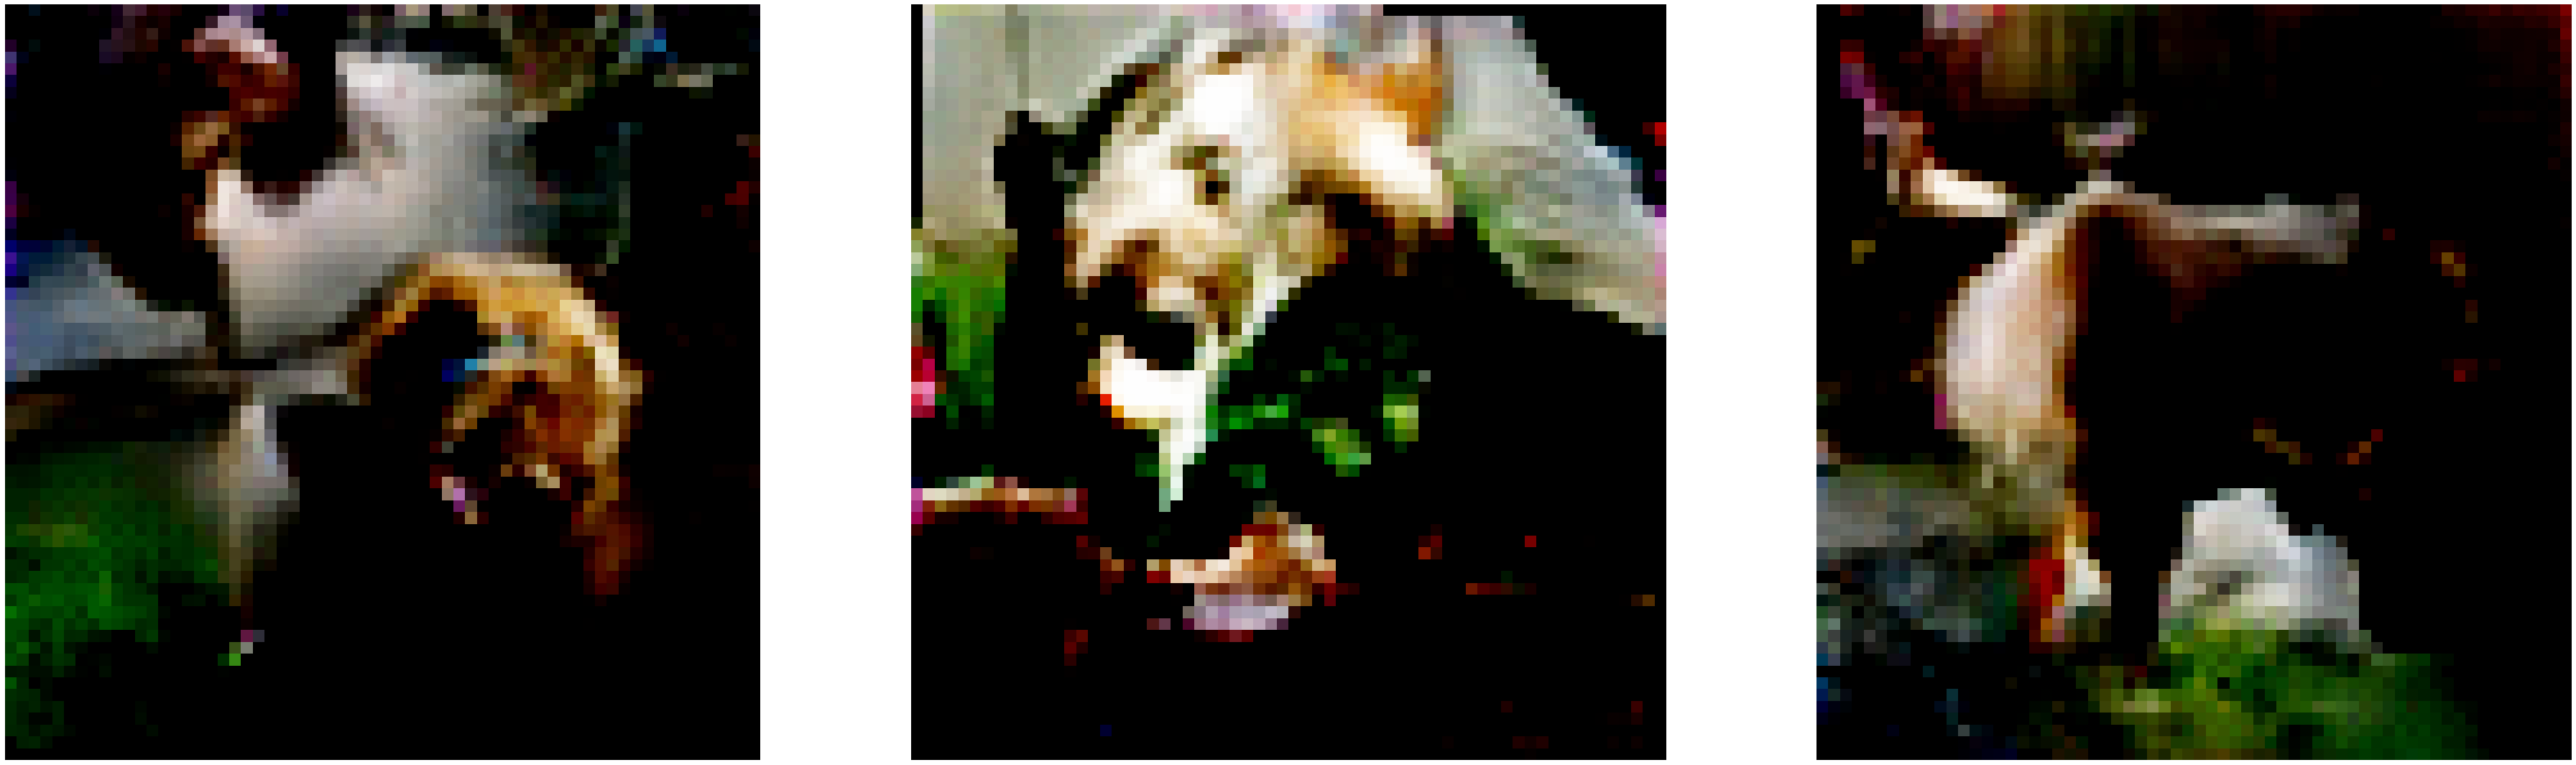

  0%|          | 0/644 [00:00<?, ?it/s]

[142/300][322/644] Loss_D: 0.0188 Loss_G: 1.0311
[142/300][644/644] Loss_D: 0.0220 Loss_G: 3.6523


  0%|          | 0/644 [00:00<?, ?it/s]

[143/300][322/644] Loss_D: 0.0476 Loss_G: 1.0186
[143/300][644/644] Loss_D: 0.0141 Loss_G: 0.7819


  0%|          | 0/644 [00:00<?, ?it/s]

[144/300][322/644] Loss_D: 0.0559 Loss_G: 1.1077
[144/300][644/644] Loss_D: 0.0387 Loss_G: 0.1032


  0%|          | 0/644 [00:00<?, ?it/s]

[145/300][322/644] Loss_D: 0.1365 Loss_G: 0.9890
[145/300][644/644] Loss_D: 0.1144 Loss_G: 6.2063


  0%|          | 0/644 [00:00<?, ?it/s]

[146/300][322/644] Loss_D: 0.0778 Loss_G: 0.9946
[146/300][644/644] Loss_D: 0.1006 Loss_G: 6.0070


  0%|          | 0/644 [00:00<?, ?it/s]

[147/300][322/644] Loss_D: 0.0821 Loss_G: 1.0787
[147/300][644/644] Loss_D: 0.0582 Loss_G: 4.8732


  0%|          | 0/644 [00:00<?, ?it/s]

[148/300][322/644] Loss_D: 0.0350 Loss_G: 0.9815
[148/300][644/644] Loss_D: 0.2119 Loss_G: 9.8063


  0%|          | 0/644 [00:00<?, ?it/s]

[149/300][322/644] Loss_D: 0.0237 Loss_G: 1.0141
[149/300][644/644] Loss_D: 0.2075 Loss_G: 8.8982


  0%|          | 0/644 [00:00<?, ?it/s]

[150/300][322/644] Loss_D: 0.0202 Loss_G: 1.0314
[150/300][644/644] Loss_D: 0.0898 Loss_G: 5.0298


  0%|          | 0/644 [00:00<?, ?it/s]

[151/300][322/644] Loss_D: 0.0432 Loss_G: 1.0022
[151/300][644/644] Loss_D: 0.0563 Loss_G: 0.1742


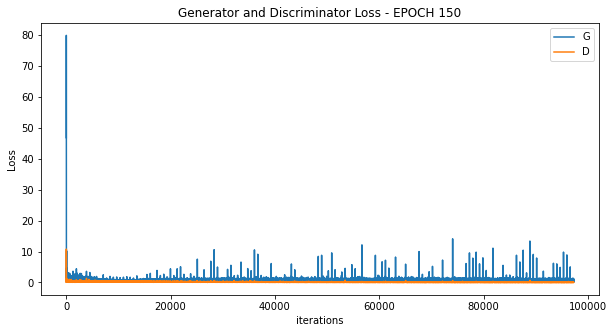

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


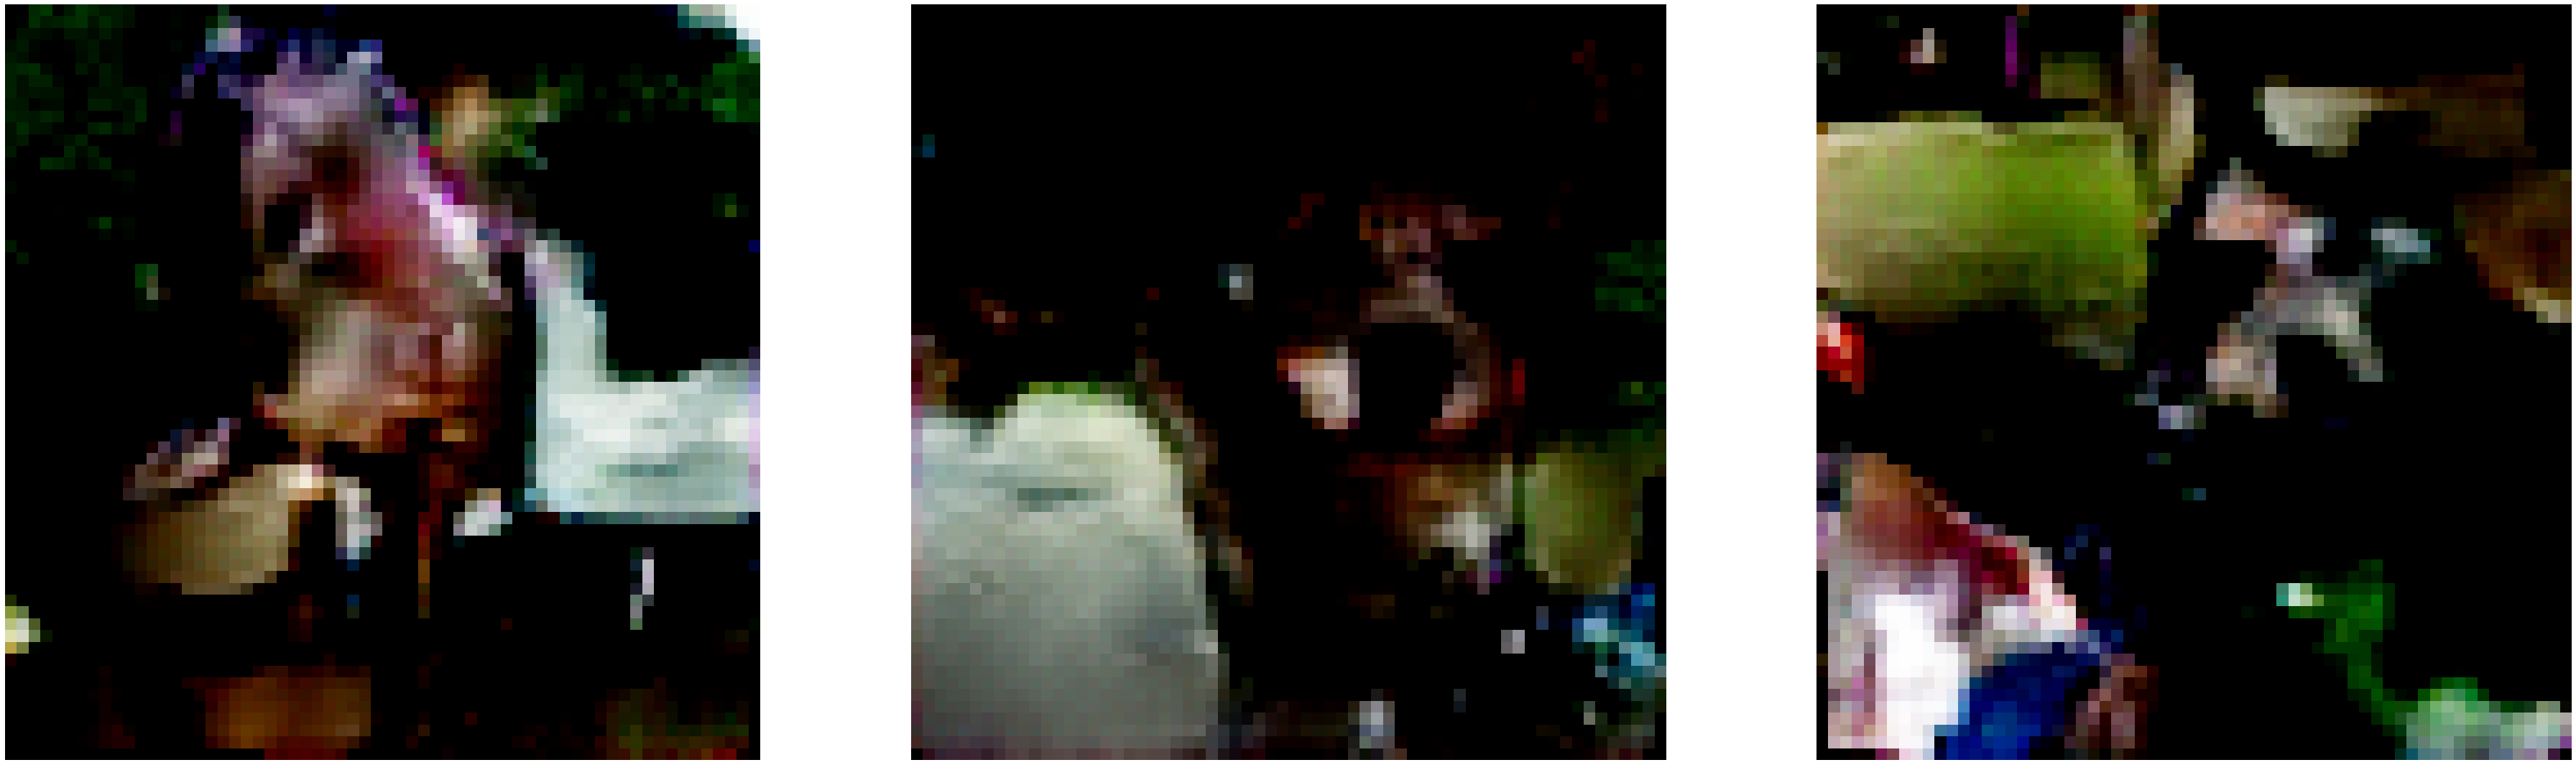

  0%|          | 0/644 [00:00<?, ?it/s]

[152/300][322/644] Loss_D: 0.0389 Loss_G: 0.9259
[152/300][644/644] Loss_D: 0.1320 Loss_G: 8.1232


  0%|          | 0/644 [00:00<?, ?it/s]

[153/300][322/644] Loss_D: 0.0411 Loss_G: 1.1282
[153/300][644/644] Loss_D: 0.4241 Loss_G: 4.1619


  0%|          | 0/644 [00:00<?, ?it/s]

[154/300][322/644] Loss_D: 0.0308 Loss_G: 1.0698
[154/300][644/644] Loss_D: 0.2125 Loss_G: 9.5129


  0%|          | 0/644 [00:00<?, ?it/s]

[155/300][322/644] Loss_D: 0.0728 Loss_G: 0.8205
[155/300][644/644] Loss_D: 0.0517 Loss_G: 4.0157


  0%|          | 0/644 [00:00<?, ?it/s]

[156/300][322/644] Loss_D: 0.0241 Loss_G: 1.0803
[156/300][644/644] Loss_D: 0.0174 Loss_G: 0.8389


  0%|          | 0/644 [00:00<?, ?it/s]

[157/300][322/644] Loss_D: 0.0219 Loss_G: 1.0188
[157/300][644/644] Loss_D: 0.0427 Loss_G: 0.1000


  0%|          | 0/644 [00:00<?, ?it/s]

[158/300][322/644] Loss_D: 0.0588 Loss_G: 0.7914
[158/300][644/644] Loss_D: 0.0496 Loss_G: 0.0427


  0%|          | 0/644 [00:00<?, ?it/s]

[159/300][322/644] Loss_D: 0.0628 Loss_G: 0.8771
[159/300][644/644] Loss_D: 0.0409 Loss_G: 3.9931


  0%|          | 0/644 [00:00<?, ?it/s]

[160/300][322/644] Loss_D: 0.0278 Loss_G: 0.9923
[160/300][644/644] Loss_D: 0.0263 Loss_G: 0.0349


  0%|          | 0/644 [00:00<?, ?it/s]

[161/300][322/644] Loss_D: 0.0384 Loss_G: 0.9676
[161/300][644/644] Loss_D: 0.1656 Loss_G: 2.3310


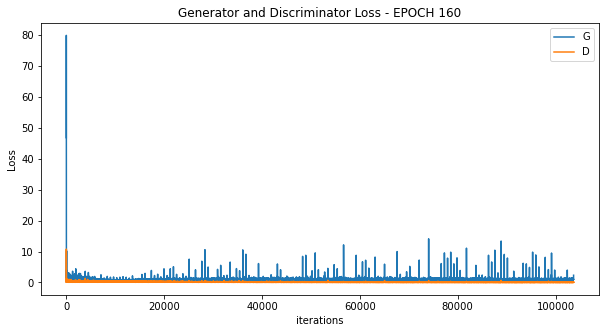

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


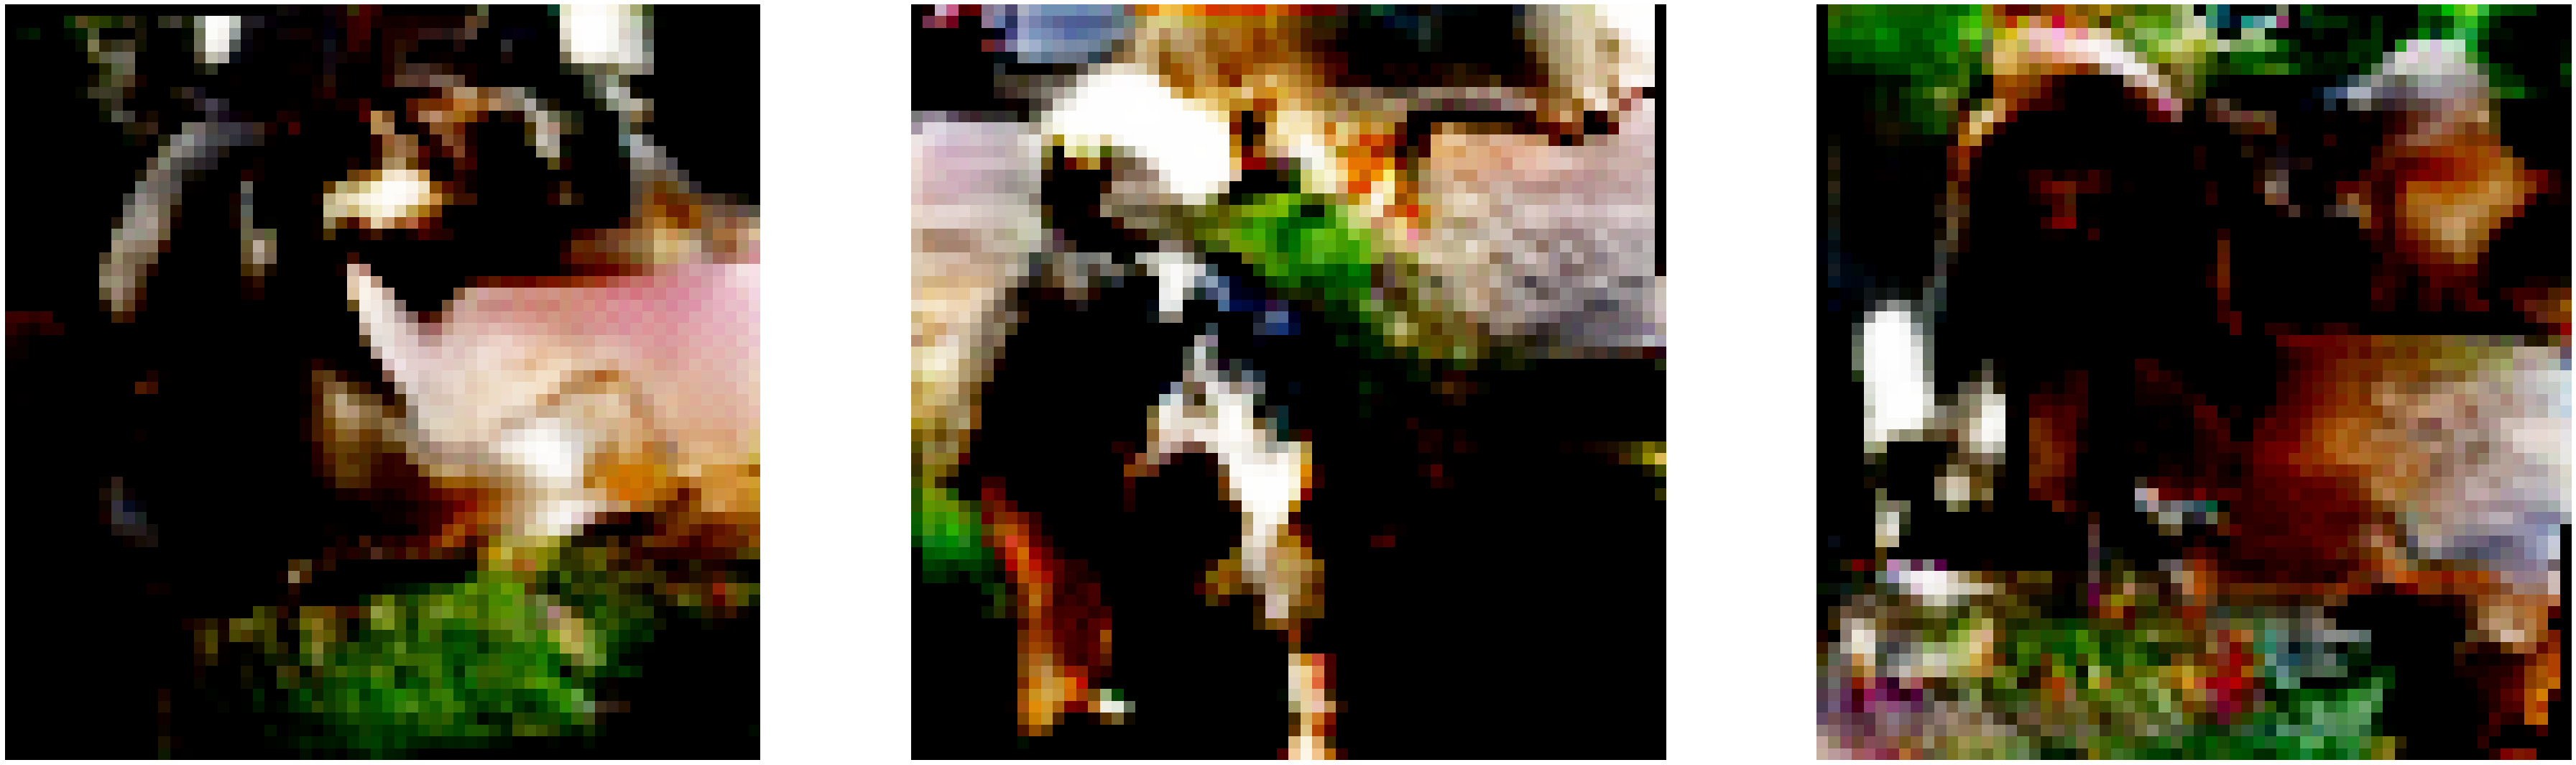

  0%|          | 0/644 [00:00<?, ?it/s]

[162/300][322/644] Loss_D: 0.0252 Loss_G: 1.0042
[162/300][644/644] Loss_D: 0.0179 Loss_G: 1.4928


  0%|          | 0/644 [00:00<?, ?it/s]

[163/300][322/644] Loss_D: 0.0343 Loss_G: 0.9325
[163/300][644/644] Loss_D: 0.1795 Loss_G: 8.8203


  0%|          | 0/644 [00:00<?, ?it/s]

[164/300][322/644] Loss_D: 0.0371 Loss_G: 1.1485
[164/300][644/644] Loss_D: 0.0168 Loss_G: 2.6522


  0%|          | 0/644 [00:00<?, ?it/s]

[165/300][322/644] Loss_D: 0.0279 Loss_G: 0.9602
[165/300][644/644] Loss_D: 0.0591 Loss_G: 0.4613


  0%|          | 0/644 [00:00<?, ?it/s]

[166/300][322/644] Loss_D: 0.0471 Loss_G: 1.0719
[166/300][644/644] Loss_D: 0.6457 Loss_G: 7.3264


  0%|          | 0/644 [00:00<?, ?it/s]

[167/300][322/644] Loss_D: 0.0392 Loss_G: 1.0093
[167/300][644/644] Loss_D: 0.1546 Loss_G: 1.4757


  0%|          | 0/644 [00:00<?, ?it/s]

[168/300][322/644] Loss_D: 0.1039 Loss_G: 0.8891
[168/300][644/644] Loss_D: 0.1129 Loss_G: 8.8658


  0%|          | 0/644 [00:00<?, ?it/s]

[169/300][322/644] Loss_D: 0.0313 Loss_G: 1.0799
[169/300][644/644] Loss_D: 0.2108 Loss_G: 9.8740


  0%|          | 0/644 [00:00<?, ?it/s]

[170/300][322/644] Loss_D: 0.0200 Loss_G: 0.9986
[170/300][644/644] Loss_D: 0.1845 Loss_G: 5.3613


  0%|          | 0/644 [00:00<?, ?it/s]

[171/300][322/644] Loss_D: 0.0245 Loss_G: 0.9877
[171/300][644/644] Loss_D: 0.0132 Loss_G: 0.2081


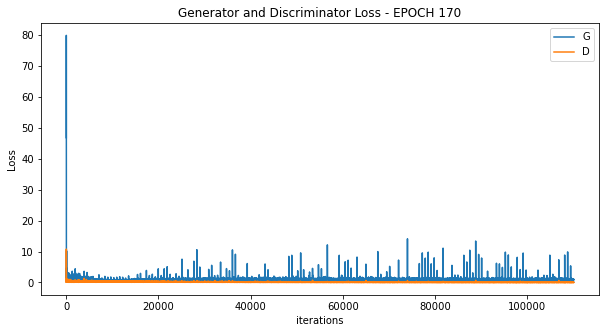

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


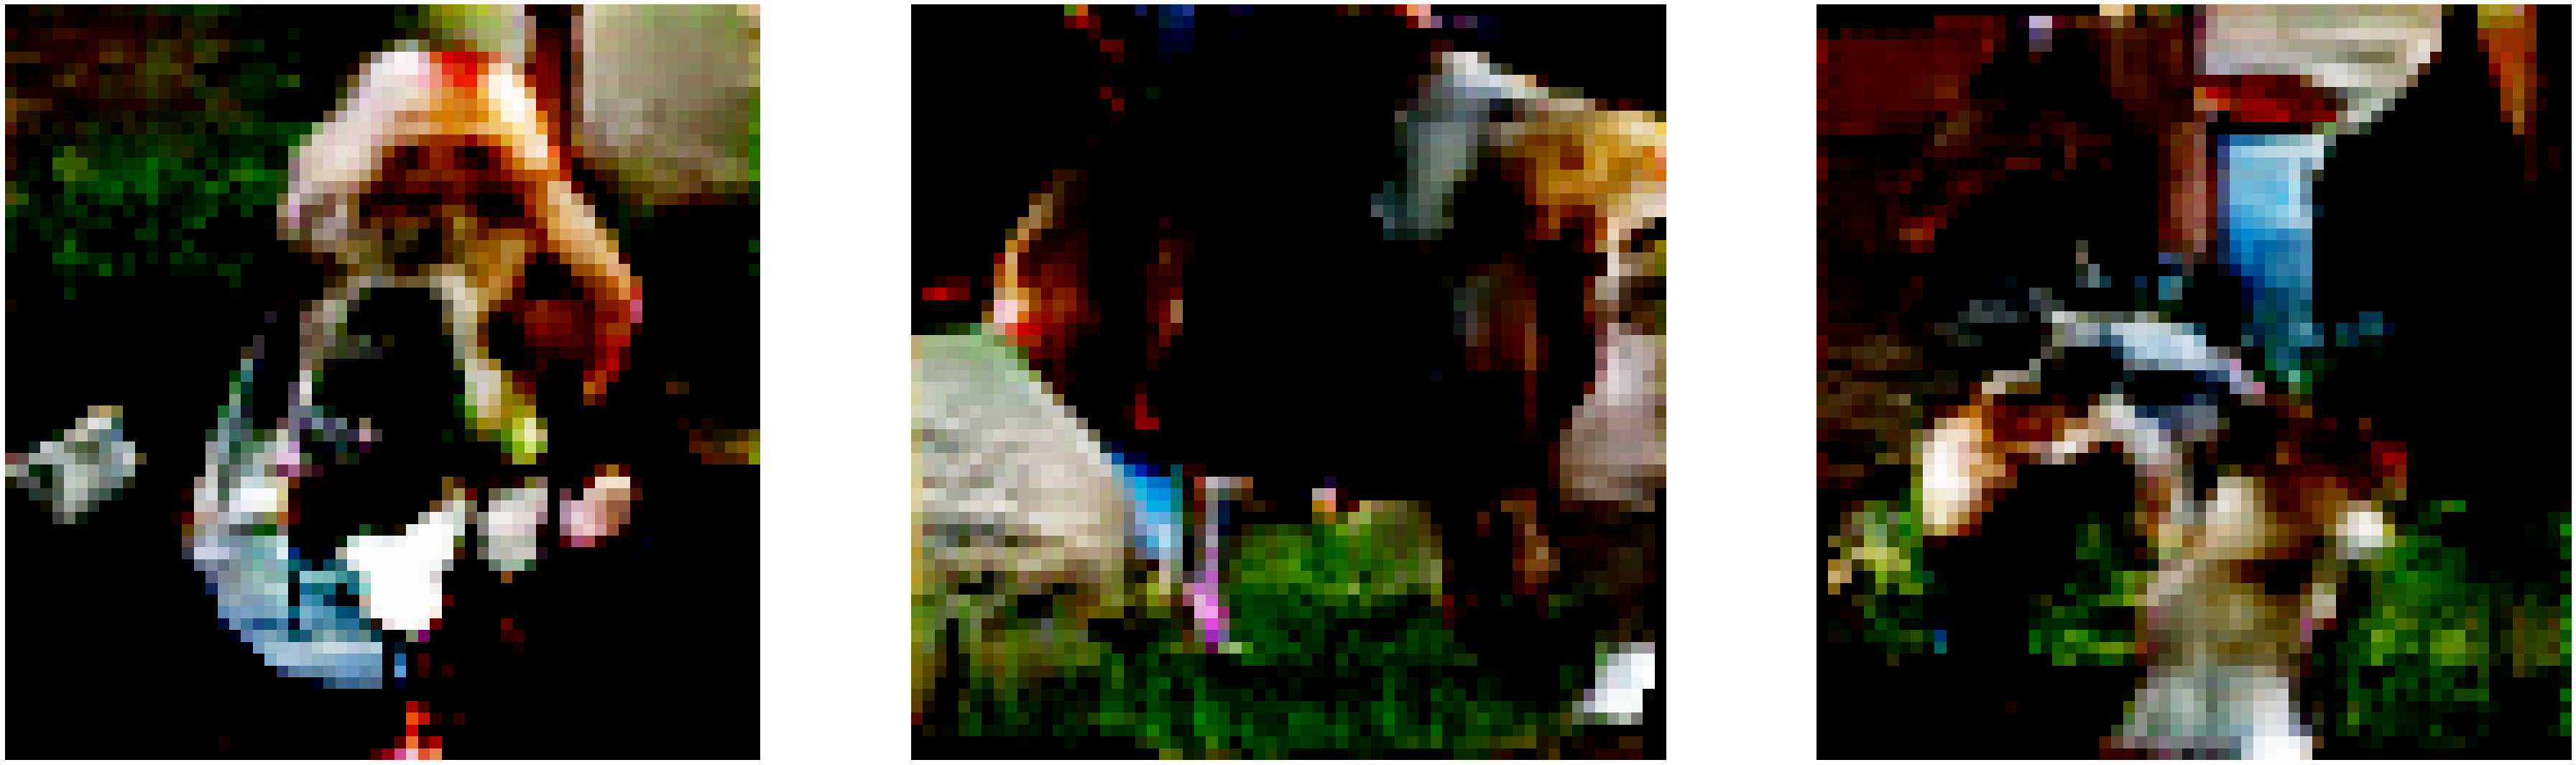

  0%|          | 0/644 [00:00<?, ?it/s]

[172/300][322/644] Loss_D: 0.0327 Loss_G: 0.8493
[172/300][644/644] Loss_D: 0.0335 Loss_G: 0.9760


  0%|          | 0/644 [00:00<?, ?it/s]

[173/300][322/644] Loss_D: 0.0718 Loss_G: 0.8602
[173/300][644/644] Loss_D: 0.0158 Loss_G: 2.5451


  0%|          | 0/644 [00:00<?, ?it/s]

[174/300][322/644] Loss_D: 0.0265 Loss_G: 1.0108
[174/300][644/644] Loss_D: 0.0217 Loss_G: 0.0897


  0%|          | 0/644 [00:00<?, ?it/s]

[175/300][322/644] Loss_D: 0.0286 Loss_G: 0.9800
[175/300][644/644] Loss_D: 0.0999 Loss_G: 3.9219


  0%|          | 0/644 [00:00<?, ?it/s]

[176/300][322/644] Loss_D: 0.0216 Loss_G: 1.0186
[176/300][644/644] Loss_D: 0.2471 Loss_G: 9.2969


  0%|          | 0/644 [00:00<?, ?it/s]

[177/300][322/644] Loss_D: 0.0637 Loss_G: 1.0722
[177/300][644/644] Loss_D: 0.2441 Loss_G: 9.5473


  0%|          | 0/644 [00:00<?, ?it/s]

[178/300][322/644] Loss_D: 0.0148 Loss_G: 1.0229
[178/300][644/644] Loss_D: 0.0247 Loss_G: 0.1241


  0%|          | 0/644 [00:00<?, ?it/s]

[179/300][322/644] Loss_D: 0.0486 Loss_G: 0.9047
[179/300][644/644] Loss_D: 0.0132 Loss_G: 0.2831


  0%|          | 0/644 [00:00<?, ?it/s]

[180/300][322/644] Loss_D: 0.0244 Loss_G: 1.0652
[180/300][644/644] Loss_D: 0.1592 Loss_G: 8.2508


  0%|          | 0/644 [00:00<?, ?it/s]

[181/300][322/644] Loss_D: 0.0533 Loss_G: 0.8730
[181/300][644/644] Loss_D: 0.0923 Loss_G: 5.4344


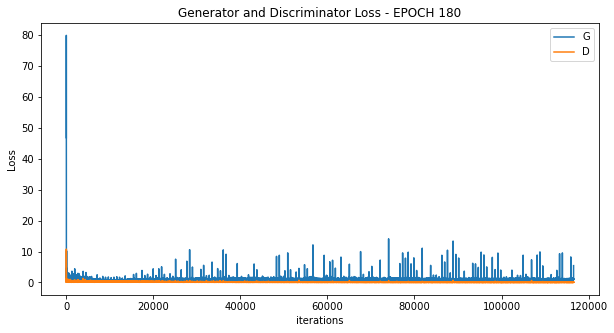

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


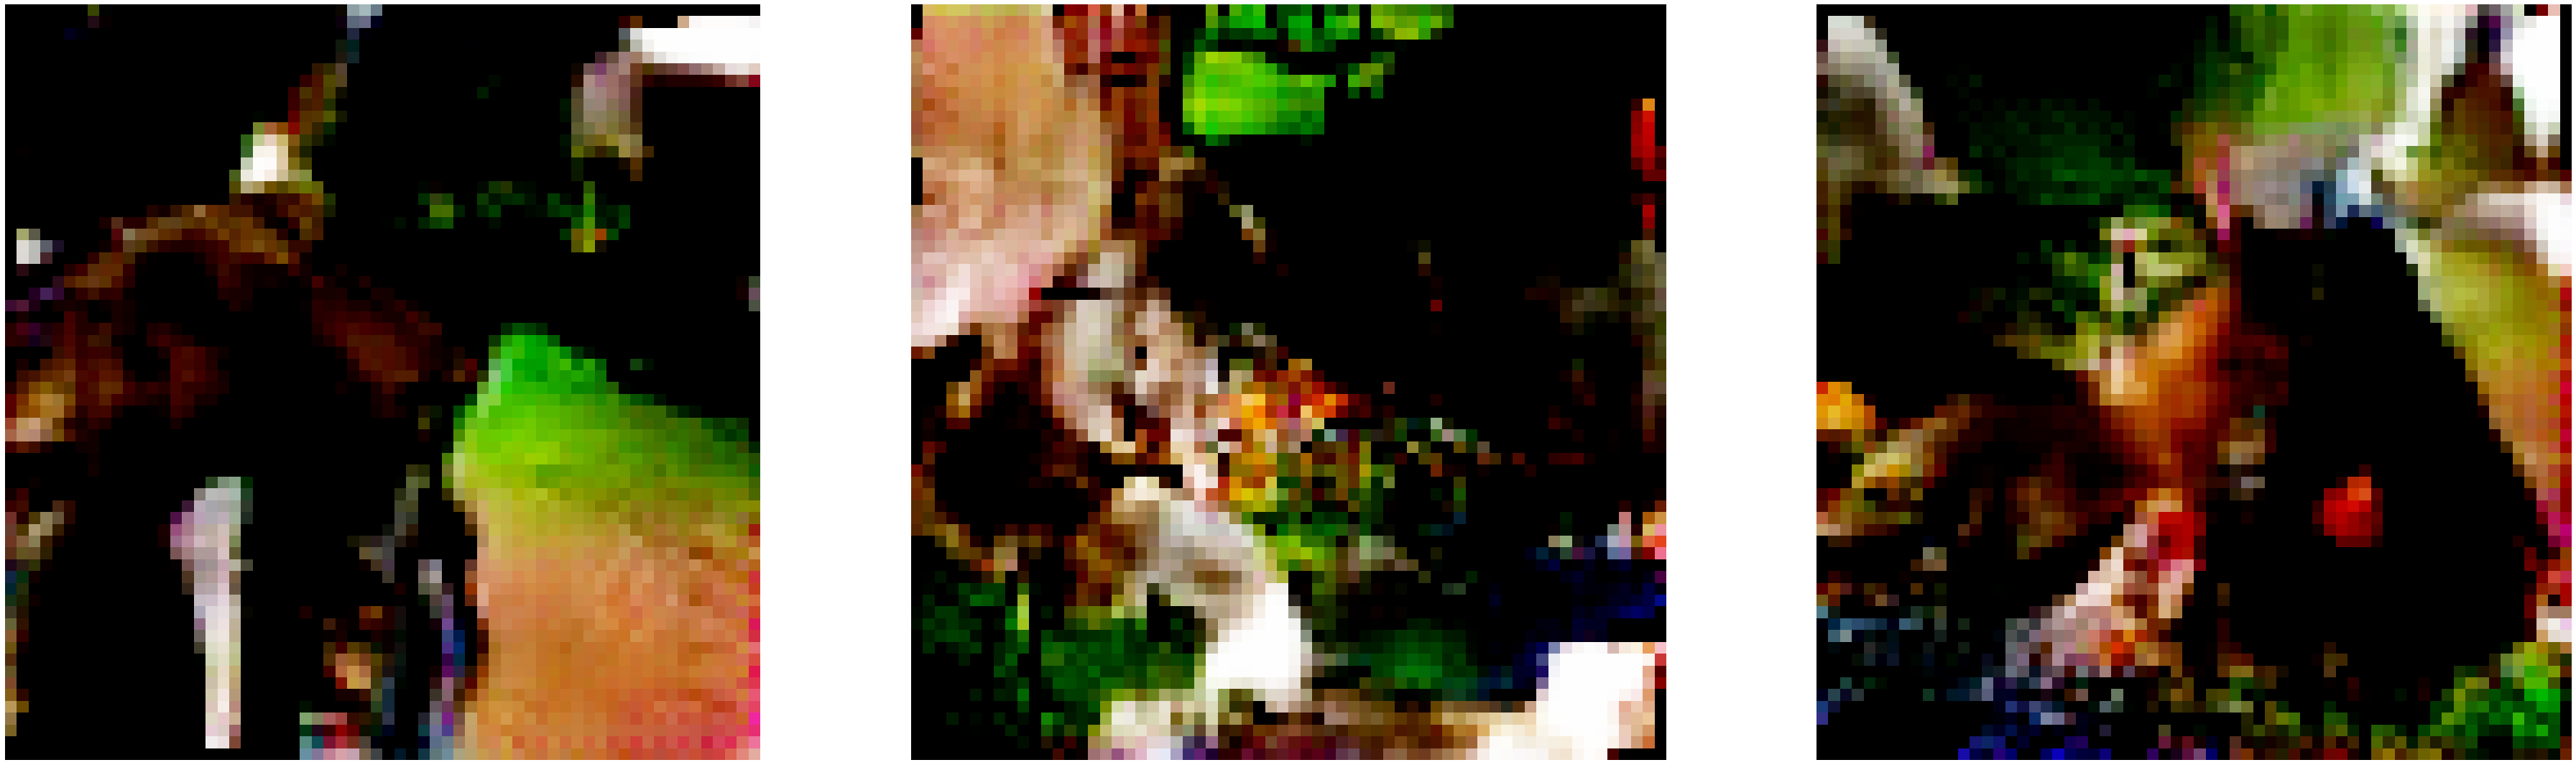

  0%|          | 0/644 [00:00<?, ?it/s]

[182/300][322/644] Loss_D: 0.0256 Loss_G: 1.0031
[182/300][644/644] Loss_D: 0.0400 Loss_G: 0.0534


  0%|          | 0/644 [00:00<?, ?it/s]

[183/300][322/644] Loss_D: 0.0155 Loss_G: 1.0725
[183/300][644/644] Loss_D: 0.1345 Loss_G: 5.7635


  0%|          | 0/644 [00:00<?, ?it/s]

[184/300][322/644] Loss_D: 0.0378 Loss_G: 1.0225
[184/300][644/644] Loss_D: 0.0310 Loss_G: 0.0306


  0%|          | 0/644 [00:00<?, ?it/s]

[185/300][322/644] Loss_D: 0.0248 Loss_G: 0.9400
[185/300][644/644] Loss_D: 0.1166 Loss_G: 8.3776


  0%|          | 0/644 [00:00<?, ?it/s]

[186/300][322/644] Loss_D: 0.0285 Loss_G: 1.3724
[186/300][644/644] Loss_D: 0.0064 Loss_G: 2.5419


  0%|          | 0/644 [00:00<?, ?it/s]

[187/300][322/644] Loss_D: 0.0356 Loss_G: 0.8758
[187/300][644/644] Loss_D: 0.1046 Loss_G: 1.0346


  0%|          | 0/644 [00:00<?, ?it/s]

[188/300][322/644] Loss_D: 0.0530 Loss_G: 0.8927
[188/300][644/644] Loss_D: 0.0761 Loss_G: 0.3334


  0%|          | 0/644 [00:00<?, ?it/s]

[189/300][322/644] Loss_D: 0.0217 Loss_G: 1.0524
[189/300][644/644] Loss_D: 0.0915 Loss_G: 8.4635


  0%|          | 0/644 [00:00<?, ?it/s]

[190/300][322/644] Loss_D: 0.0190 Loss_G: 1.0149
[190/300][644/644] Loss_D: 0.0241 Loss_G: 2.9384


  0%|          | 0/644 [00:00<?, ?it/s]

[191/300][322/644] Loss_D: 0.0372 Loss_G: 1.0734
[191/300][644/644] Loss_D: 0.0507 Loss_G: 5.1224


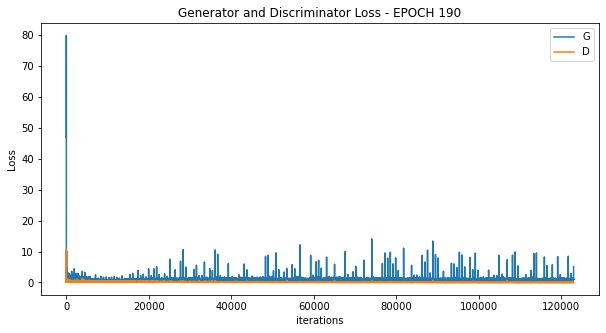

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


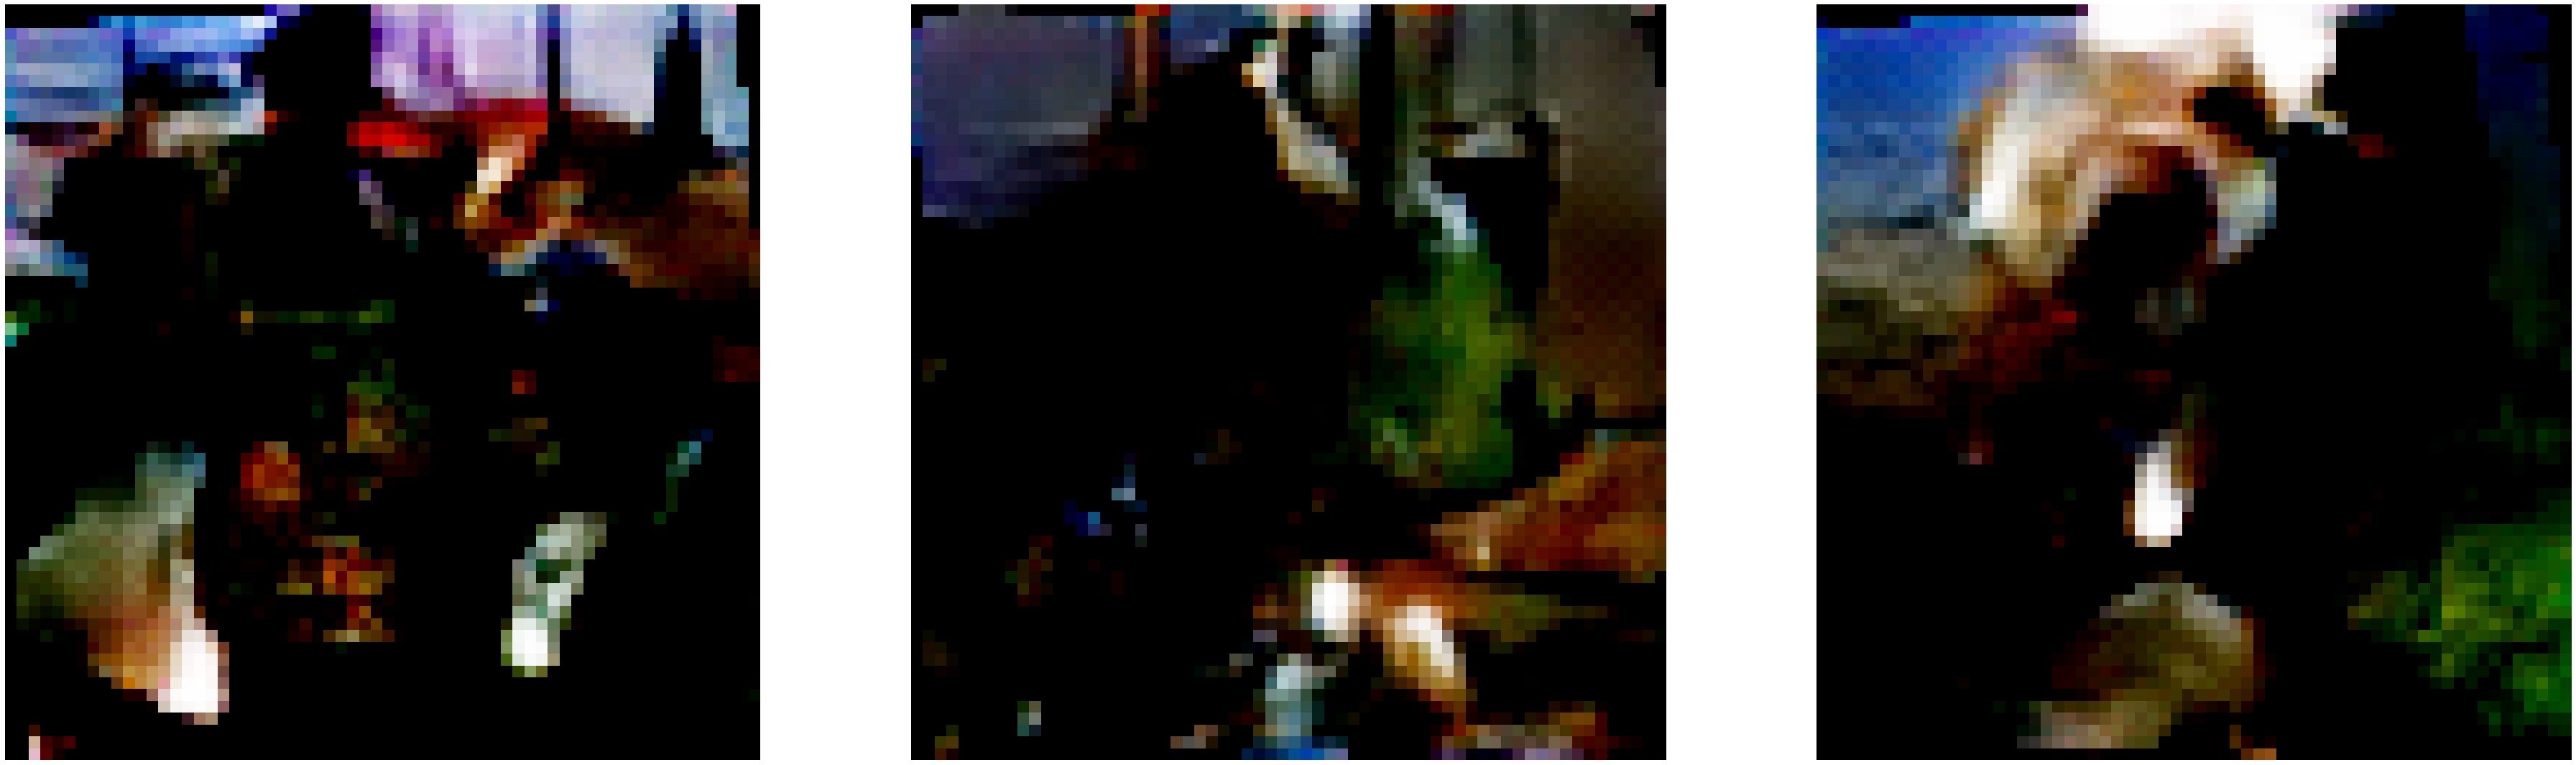

  0%|          | 0/644 [00:00<?, ?it/s]

[192/300][322/644] Loss_D: 0.0335 Loss_G: 0.9348
[192/300][644/644] Loss_D: 0.0678 Loss_G: 0.1643


  0%|          | 0/644 [00:00<?, ?it/s]

[193/300][322/644] Loss_D: 0.0179 Loss_G: 0.9308
[193/300][644/644] Loss_D: 0.0150 Loss_G: 2.2103


  0%|          | 0/644 [00:00<?, ?it/s]

[194/300][322/644] Loss_D: 0.0192 Loss_G: 0.9317
[194/300][644/644] Loss_D: 0.0592 Loss_G: 5.2503


  0%|          | 0/644 [00:00<?, ?it/s]

[195/300][322/644] Loss_D: 0.0540 Loss_G: 1.0500
[195/300][644/644] Loss_D: 0.0658 Loss_G: 6.0935


  0%|          | 0/644 [00:00<?, ?it/s]

[196/300][322/644] Loss_D: 0.0186 Loss_G: 0.9566
[196/300][644/644] Loss_D: 0.1886 Loss_G: 3.8132


  0%|          | 0/644 [00:00<?, ?it/s]

[197/300][322/644] Loss_D: 0.0430 Loss_G: 1.3026
[197/300][644/644] Loss_D: 0.0302 Loss_G: 0.0392


  0%|          | 0/644 [00:00<?, ?it/s]

[198/300][322/644] Loss_D: 0.0228 Loss_G: 1.0269
[198/300][644/644] Loss_D: 0.0302 Loss_G: 0.0252


  0%|          | 0/644 [00:00<?, ?it/s]

[199/300][322/644] Loss_D: 0.0645 Loss_G: 1.1003
[199/300][644/644] Loss_D: 0.1042 Loss_G: 6.8747


  0%|          | 0/644 [00:00<?, ?it/s]

[200/300][322/644] Loss_D: 0.0401 Loss_G: 1.1074
[200/300][644/644] Loss_D: 0.0921 Loss_G: 4.4845


  0%|          | 0/644 [00:00<?, ?it/s]

[201/300][322/644] Loss_D: 0.0217 Loss_G: 1.0416
[201/300][644/644] Loss_D: 0.0163 Loss_G: 1.9233


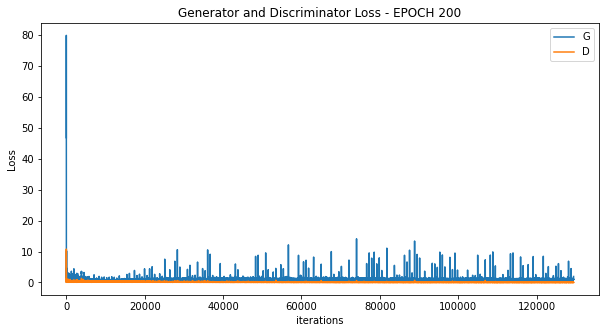

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


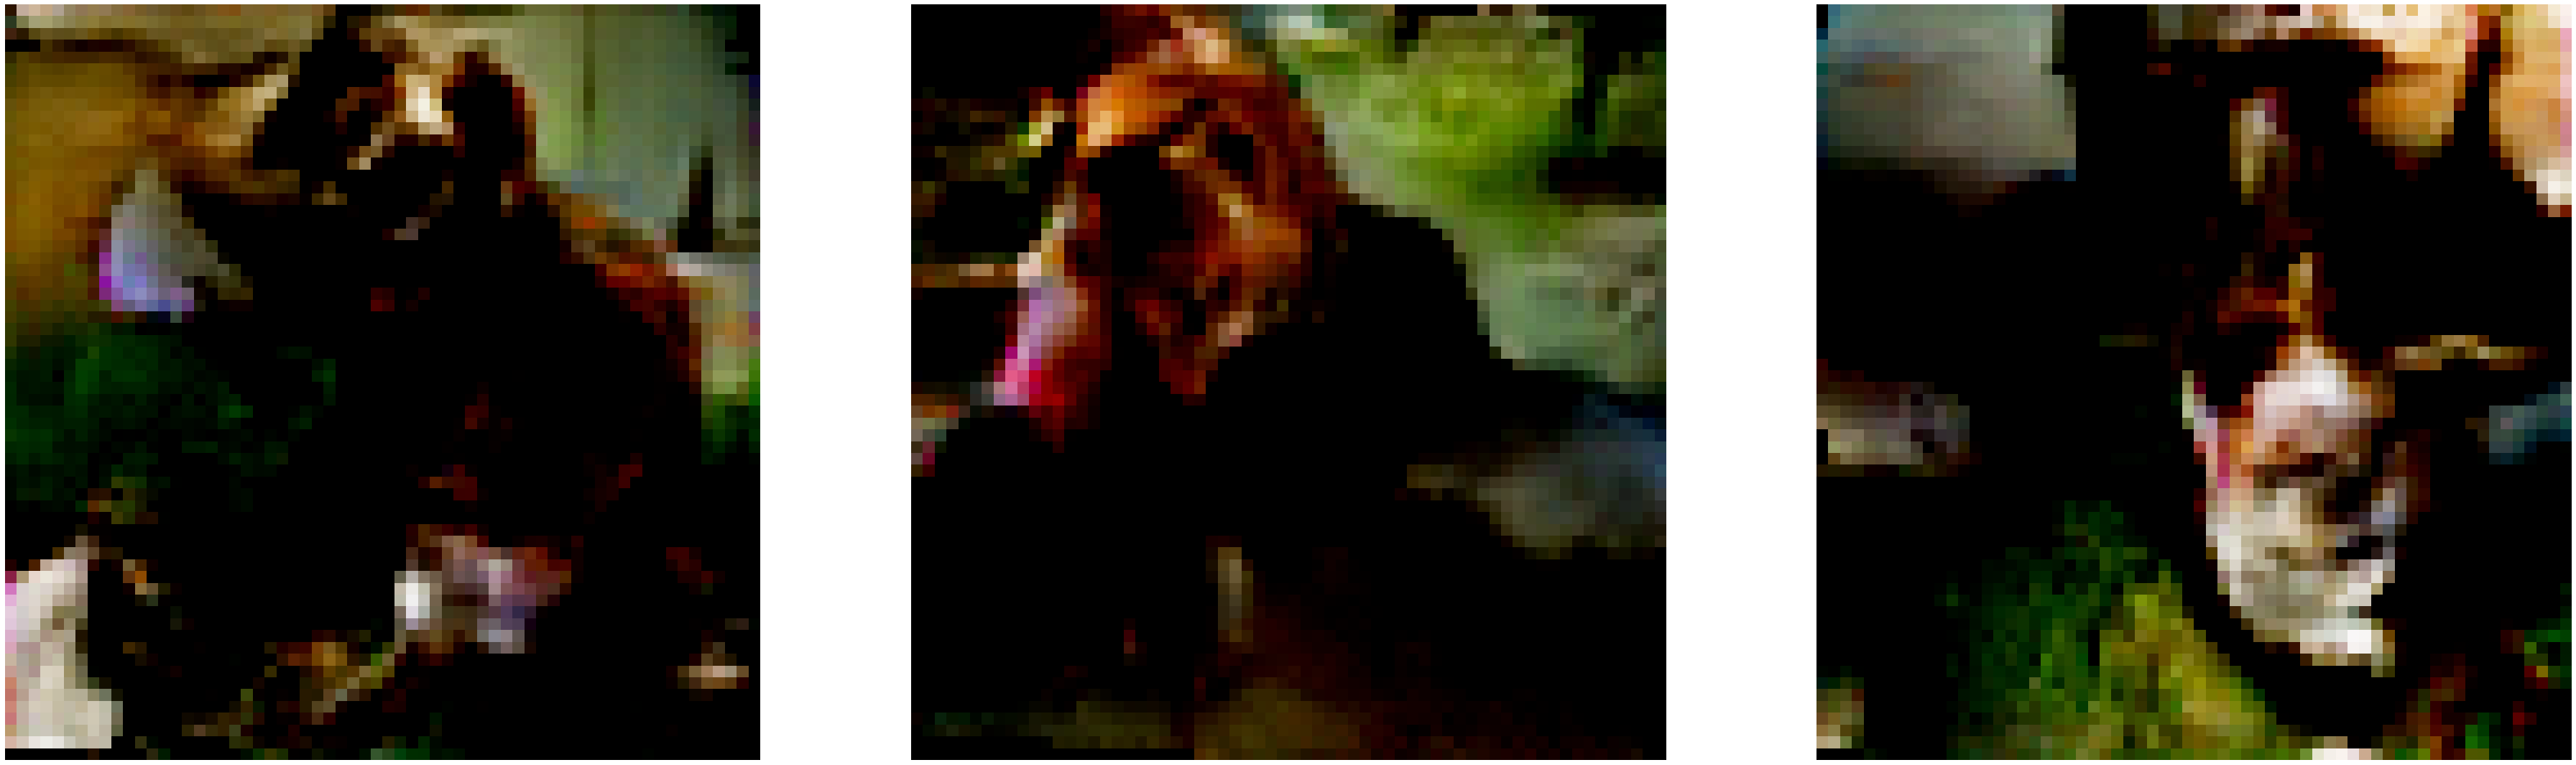

  0%|          | 0/644 [00:00<?, ?it/s]

[202/300][322/644] Loss_D: 0.0423 Loss_G: 1.1002
[202/300][644/644] Loss_D: 0.1954 Loss_G: 10.0046


  0%|          | 0/644 [00:00<?, ?it/s]

[203/300][322/644] Loss_D: 0.0162 Loss_G: 1.0619
[203/300][644/644] Loss_D: 0.0386 Loss_G: 0.0628


  0%|          | 0/644 [00:00<?, ?it/s]

[204/300][322/644] Loss_D: 0.0527 Loss_G: 0.8251
[204/300][644/644] Loss_D: 0.2017 Loss_G: 10.9050


  0%|          | 0/644 [00:00<?, ?it/s]

[205/300][322/644] Loss_D: 0.0417 Loss_G: 0.9267
[205/300][644/644] Loss_D: 0.3596 Loss_G: 9.5853


  0%|          | 0/644 [00:00<?, ?it/s]

[206/300][322/644] Loss_D: 0.0159 Loss_G: 1.0197
[206/300][644/644] Loss_D: 0.2782 Loss_G: 1.9818


  0%|          | 0/644 [00:00<?, ?it/s]

[207/300][322/644] Loss_D: 0.0154 Loss_G: 1.0167
[207/300][644/644] Loss_D: 0.0163 Loss_G: 2.3090


  0%|          | 0/644 [00:00<?, ?it/s]

[208/300][322/644] Loss_D: 0.0228 Loss_G: 1.0099
[208/300][644/644] Loss_D: 0.1549 Loss_G: 9.3020


  0%|          | 0/644 [00:00<?, ?it/s]

[209/300][322/644] Loss_D: 0.0205 Loss_G: 1.0243
[209/300][644/644] Loss_D: 0.2468 Loss_G: 10.6907


  0%|          | 0/644 [00:00<?, ?it/s]

[210/300][322/644] Loss_D: 0.0675 Loss_G: 0.8869
[210/300][644/644] Loss_D: 0.0286 Loss_G: 3.8875


  0%|          | 0/644 [00:00<?, ?it/s]

[211/300][322/644] Loss_D: 0.0369 Loss_G: 0.8907
[211/300][644/644] Loss_D: 0.0184 Loss_G: 1.4586


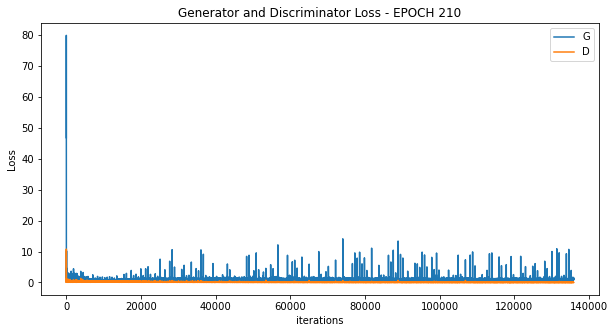

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


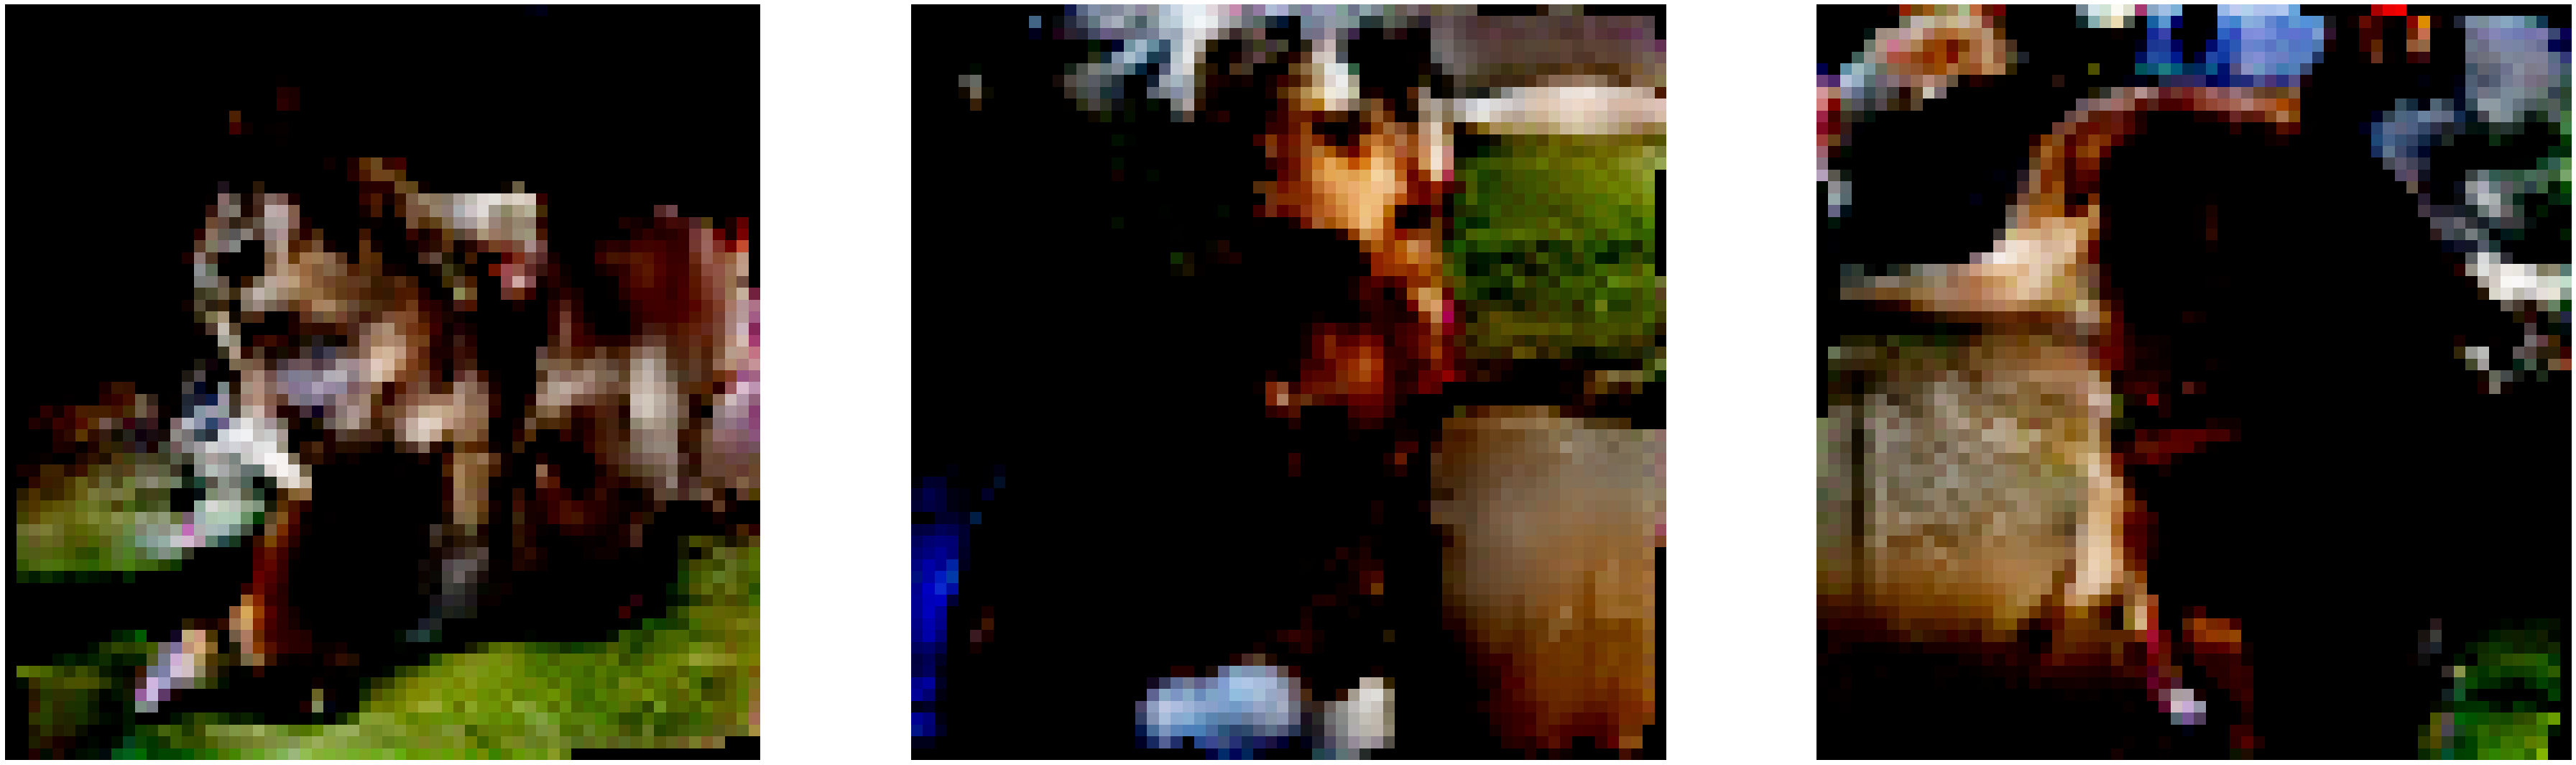

  0%|          | 0/644 [00:00<?, ?it/s]

[212/300][322/644] Loss_D: 0.0816 Loss_G: 0.9405
[212/300][644/644] Loss_D: 0.0317 Loss_G: 3.8146


  0%|          | 0/644 [00:00<?, ?it/s]

[213/300][322/644] Loss_D: 0.0185 Loss_G: 0.9303
[213/300][644/644] Loss_D: 0.0552 Loss_G: 3.6472


  0%|          | 0/644 [00:00<?, ?it/s]

[214/300][322/644] Loss_D: 0.0236 Loss_G: 0.9252
[214/300][644/644] Loss_D: 0.0565 Loss_G: 0.3052


  0%|          | 0/644 [00:00<?, ?it/s]

[215/300][322/644] Loss_D: 0.0183 Loss_G: 1.0796
[215/300][644/644] Loss_D: 0.3104 Loss_G: 7.9187


  0%|          | 0/644 [00:00<?, ?it/s]

[216/300][322/644] Loss_D: 0.0339 Loss_G: 1.0417
[216/300][644/644] Loss_D: 0.0400 Loss_G: 4.1815


  0%|          | 0/644 [00:00<?, ?it/s]

[217/300][322/644] Loss_D: 0.0330 Loss_G: 1.0882
[217/300][644/644] Loss_D: 0.2937 Loss_G: 4.1009


  0%|          | 0/644 [00:00<?, ?it/s]

[218/300][322/644] Loss_D: 0.0227 Loss_G: 1.0126
[218/300][644/644] Loss_D: 0.2724 Loss_G: 11.2438


  0%|          | 0/644 [00:00<?, ?it/s]

[219/300][322/644] Loss_D: 0.0185 Loss_G: 1.0094
[219/300][644/644] Loss_D: 0.0205 Loss_G: 0.9939


  0%|          | 0/644 [00:00<?, ?it/s]

[220/300][322/644] Loss_D: 0.0181 Loss_G: 1.0695
[220/300][644/644] Loss_D: 0.0546 Loss_G: 4.1202


  0%|          | 0/644 [00:00<?, ?it/s]

[221/300][322/644] Loss_D: 0.0355 Loss_G: 1.0023
[221/300][644/644] Loss_D: 0.2687 Loss_G: 2.8326


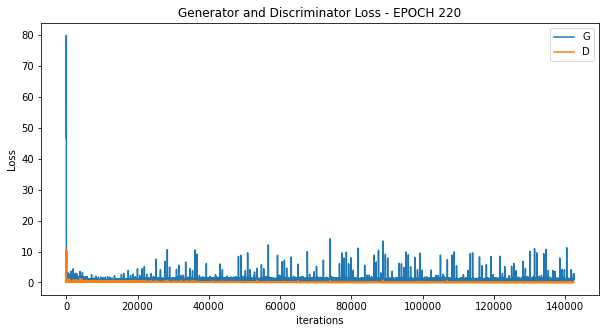

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


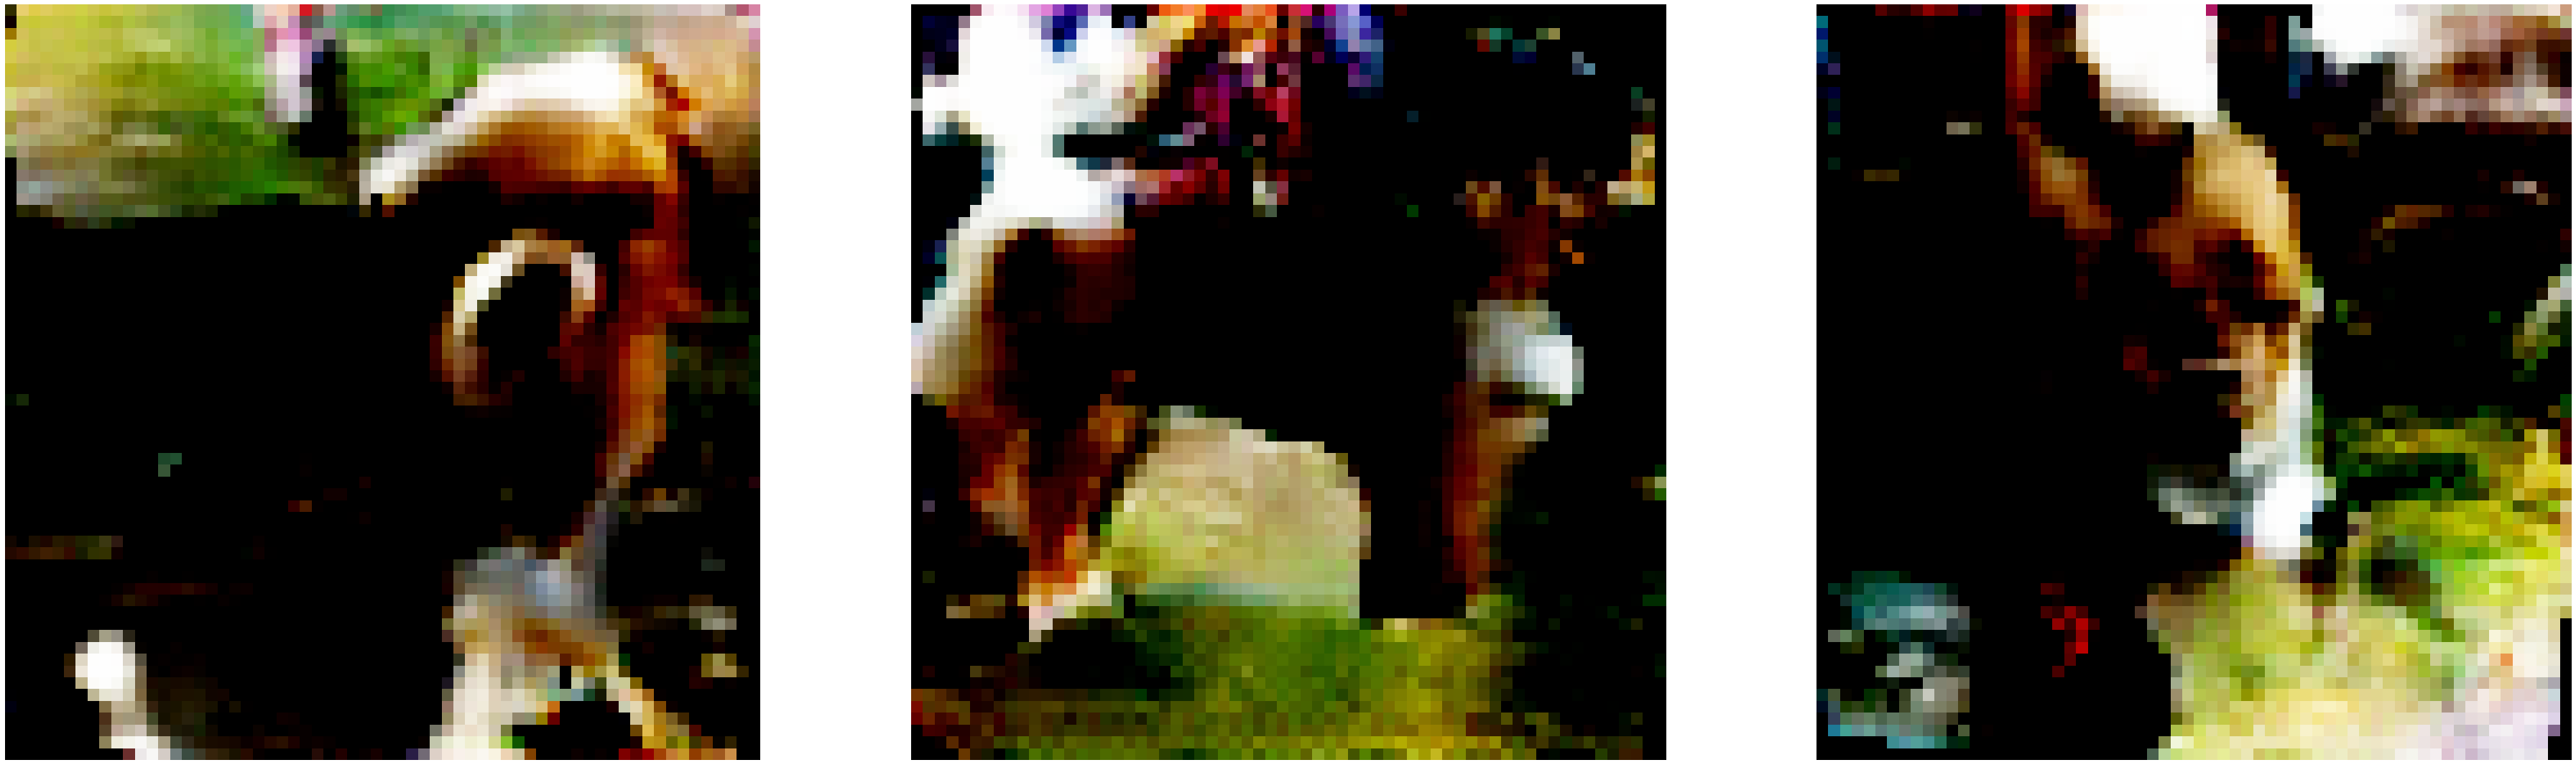

  0%|          | 0/644 [00:00<?, ?it/s]

[222/300][322/644] Loss_D: 0.0210 Loss_G: 1.0378
[222/300][644/644] Loss_D: 0.0147 Loss_G: 0.2845


  0%|          | 0/644 [00:00<?, ?it/s]

[223/300][322/644] Loss_D: 0.0177 Loss_G: 1.0104
[223/300][644/644] Loss_D: 0.0189 Loss_G: 0.0007


  0%|          | 0/644 [00:00<?, ?it/s]

[224/300][322/644] Loss_D: 0.0271 Loss_G: 0.9748
[224/300][644/644] Loss_D: 0.1451 Loss_G: 8.7559


  0%|          | 0/644 [00:00<?, ?it/s]

[225/300][322/644] Loss_D: 0.0565 Loss_G: 1.0707
[225/300][644/644] Loss_D: 0.4553 Loss_G: 7.1156


  0%|          | 0/644 [00:00<?, ?it/s]

[226/300][322/644] Loss_D: 0.0446 Loss_G: 1.1428
[226/300][644/644] Loss_D: 0.0056 Loss_G: 1.8585


  0%|          | 0/644 [00:00<?, ?it/s]

[227/300][322/644] Loss_D: 0.0141 Loss_G: 1.0720
[227/300][644/644] Loss_D: 0.0297 Loss_G: 0.2090


  0%|          | 0/644 [00:00<?, ?it/s]

[228/300][322/644] Loss_D: 0.0403 Loss_G: 1.1774
[228/300][644/644] Loss_D: 0.0233 Loss_G: 0.3073


  0%|          | 0/644 [00:00<?, ?it/s]

[229/300][322/644] Loss_D: 0.0227 Loss_G: 0.9766
[229/300][644/644] Loss_D: 0.0386 Loss_G: 0.0110


  0%|          | 0/644 [00:00<?, ?it/s]

[230/300][322/644] Loss_D: 0.0337 Loss_G: 1.0129
[230/300][644/644] Loss_D: 0.0134 Loss_G: 1.1101


  0%|          | 0/644 [00:00<?, ?it/s]

[231/300][322/644] Loss_D: 0.0167 Loss_G: 0.9616
[231/300][644/644] Loss_D: 0.0144 Loss_G: 0.3944


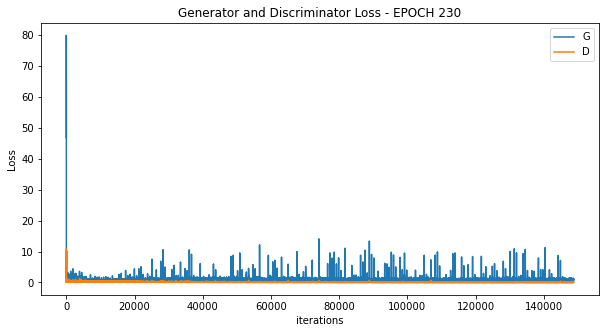

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


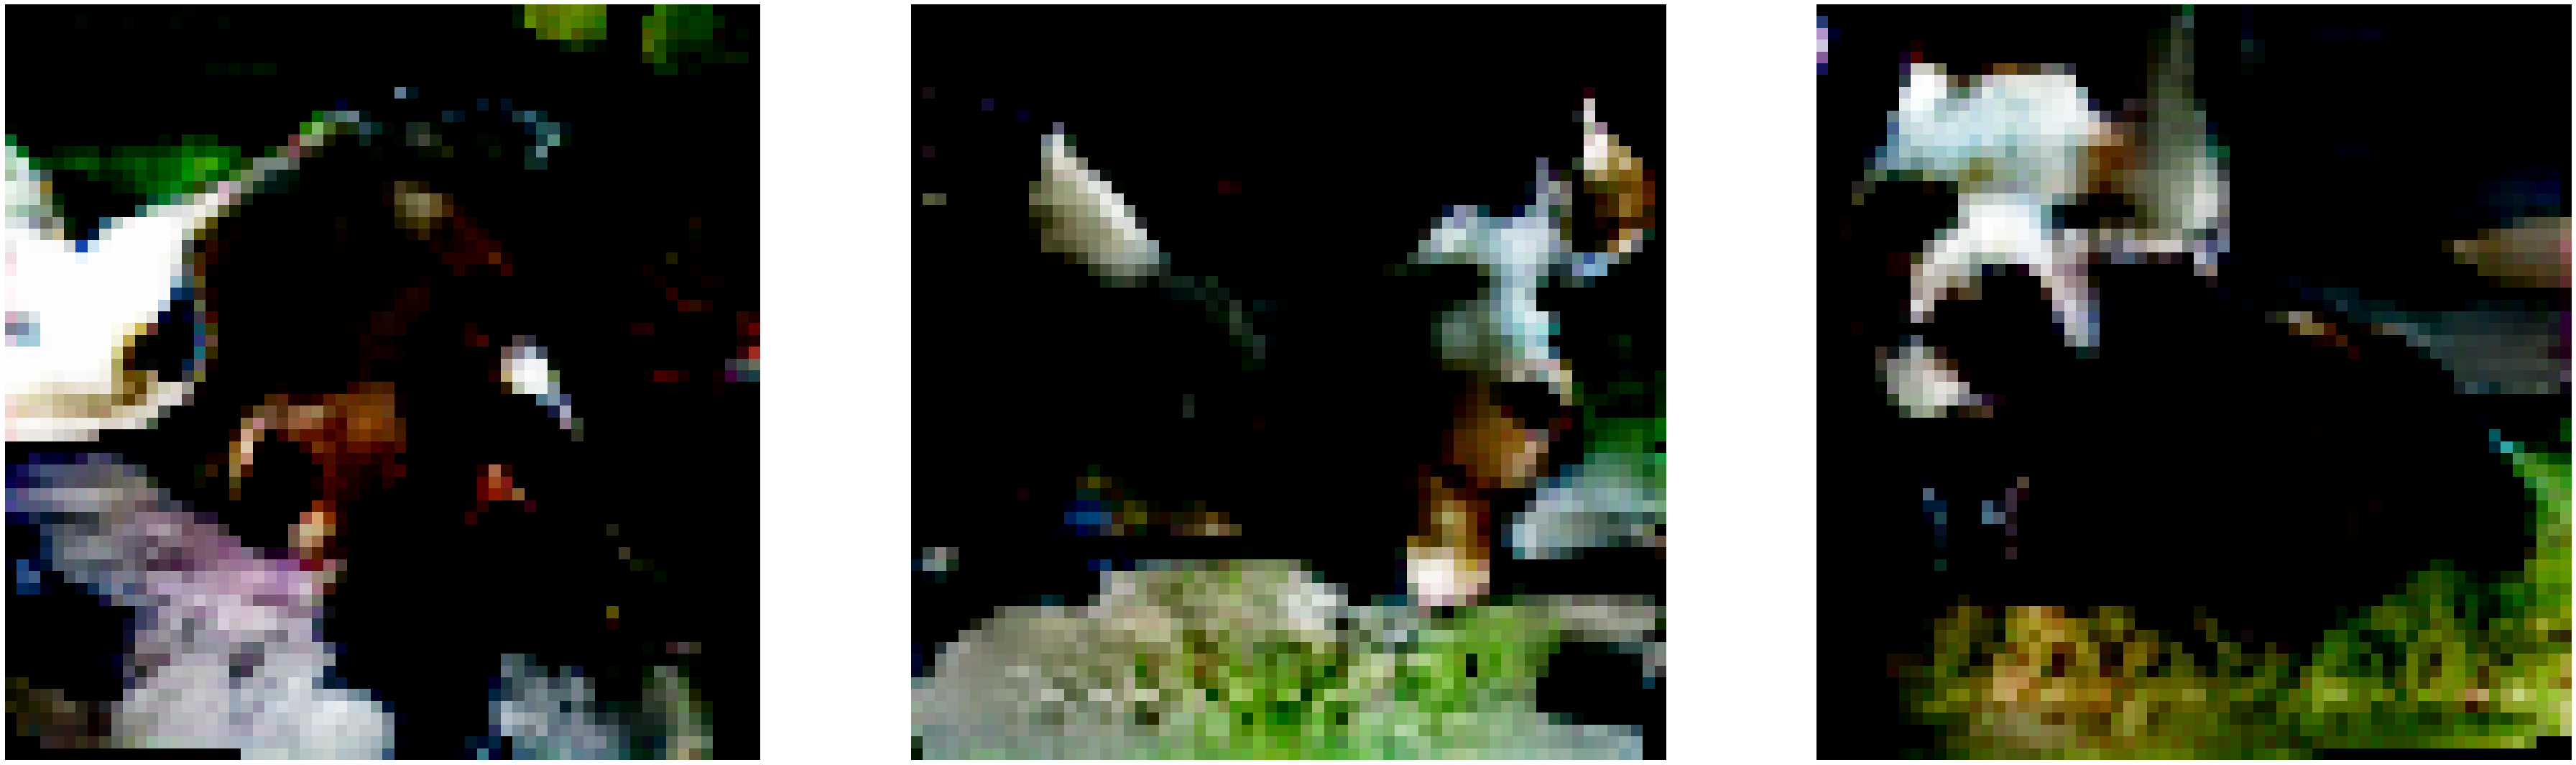

  0%|          | 0/644 [00:00<?, ?it/s]

[232/300][322/644] Loss_D: 0.0217 Loss_G: 1.0312
[232/300][644/644] Loss_D: 0.1927 Loss_G: 2.5322


  0%|          | 0/644 [00:00<?, ?it/s]

[233/300][322/644] Loss_D: 0.0339 Loss_G: 0.9102
[233/300][644/644] Loss_D: 0.1178 Loss_G: 5.3329


  0%|          | 0/644 [00:00<?, ?it/s]

[234/300][322/644] Loss_D: 0.0246 Loss_G: 0.9303
[234/300][644/644] Loss_D: 0.2004 Loss_G: 8.8556


  0%|          | 0/644 [00:00<?, ?it/s]

[235/300][322/644] Loss_D: 0.0286 Loss_G: 1.1203
[235/300][644/644] Loss_D: 0.0684 Loss_G: 4.8235


  0%|          | 0/644 [00:00<?, ?it/s]

[236/300][322/644] Loss_D: 0.0660 Loss_G: 0.9104
[236/300][644/644] Loss_D: 0.0619 Loss_G: 5.5964


  0%|          | 0/644 [00:00<?, ?it/s]

[237/300][322/644] Loss_D: 0.0160 Loss_G: 0.9560
[237/300][644/644] Loss_D: 0.0041 Loss_G: 1.3934


  0%|          | 0/644 [00:00<?, ?it/s]

[238/300][322/644] Loss_D: 0.0126 Loss_G: 0.9091
[238/300][644/644] Loss_D: 0.0160 Loss_G: 3.1402


  0%|          | 0/644 [00:00<?, ?it/s]

[239/300][322/644] Loss_D: 0.0329 Loss_G: 0.9450
[239/300][644/644] Loss_D: 0.0172 Loss_G: 0.0262


  0%|          | 0/644 [00:00<?, ?it/s]

[240/300][322/644] Loss_D: 0.0524 Loss_G: 1.3157
[240/300][644/644] Loss_D: 0.0753 Loss_G: 6.5898


  0%|          | 0/644 [00:00<?, ?it/s]

[241/300][322/644] Loss_D: 0.0734 Loss_G: 0.9445
[241/300][644/644] Loss_D: 0.2417 Loss_G: 2.7123


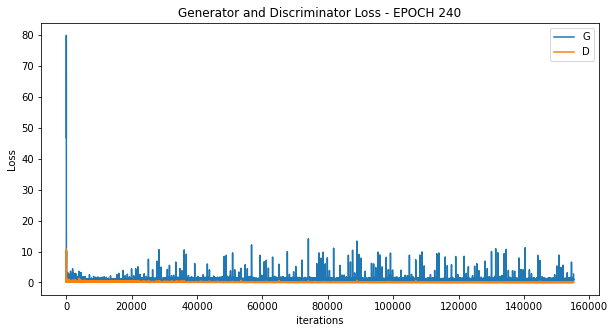

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


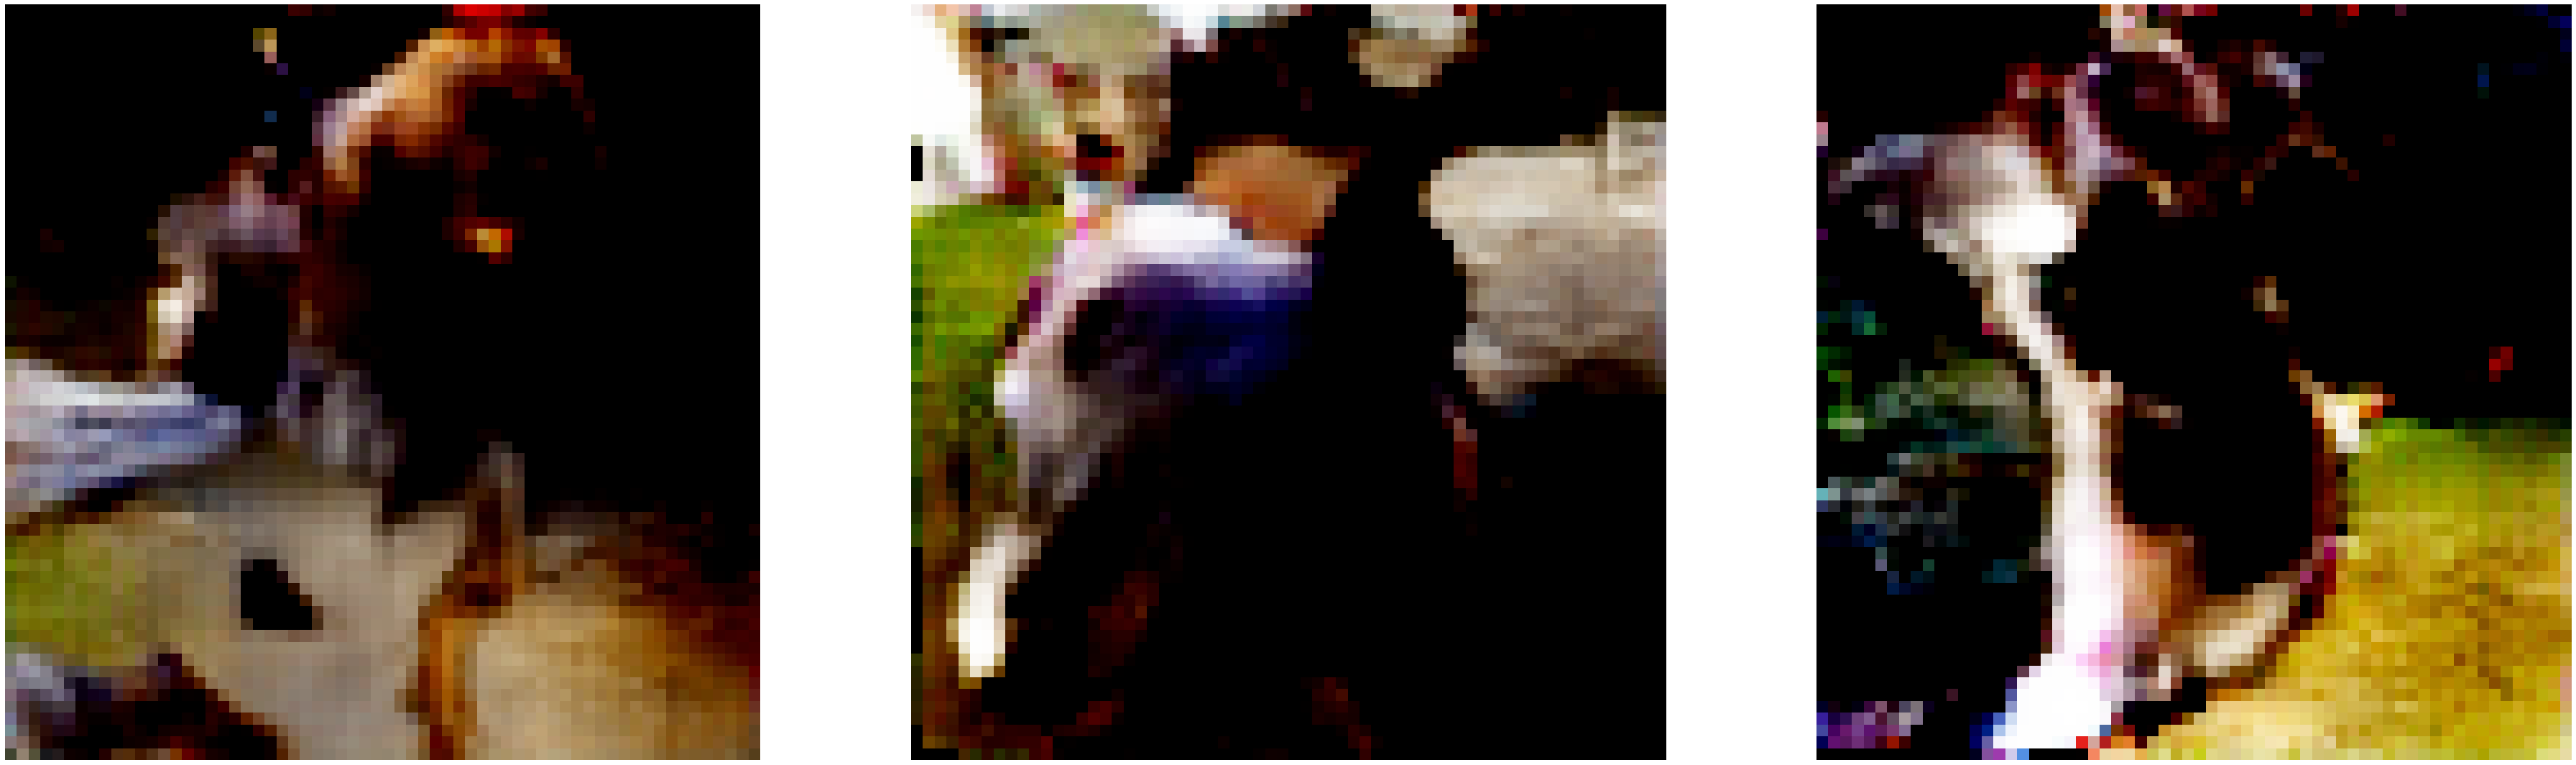

  0%|          | 0/644 [00:00<?, ?it/s]

[242/300][322/644] Loss_D: 0.0501 Loss_G: 1.0112
[242/300][644/644] Loss_D: 0.4602 Loss_G: 13.9507


  0%|          | 0/644 [00:00<?, ?it/s]

[243/300][322/644] Loss_D: 0.0307 Loss_G: 1.1307
[243/300][644/644] Loss_D: 0.1600 Loss_G: 1.7977


  0%|          | 0/644 [00:00<?, ?it/s]

[244/300][322/644] Loss_D: 0.0368 Loss_G: 1.0526
[244/300][644/644] Loss_D: 0.0571 Loss_G: 4.0057


  0%|          | 0/644 [00:00<?, ?it/s]

[245/300][322/644] Loss_D: 0.0330 Loss_G: 0.9237
[245/300][644/644] Loss_D: 0.1386 Loss_G: 8.5637


  0%|          | 0/644 [00:00<?, ?it/s]

[246/300][322/644] Loss_D: 0.0373 Loss_G: 1.0561
[246/300][644/644] Loss_D: 0.0437 Loss_G: 0.1153


  0%|          | 0/644 [00:00<?, ?it/s]

[247/300][322/644] Loss_D: 0.0446 Loss_G: 1.1104
[247/300][644/644] Loss_D: 0.0102 Loss_G: 0.3315


  0%|          | 0/644 [00:00<?, ?it/s]

[248/300][322/644] Loss_D: 0.0337 Loss_G: 0.9732
[248/300][644/644] Loss_D: 0.0497 Loss_G: 5.4027


  0%|          | 0/644 [00:00<?, ?it/s]

[249/300][322/644] Loss_D: 0.0409 Loss_G: 1.0114
[249/300][644/644] Loss_D: 0.1133 Loss_G: 6.0657


  0%|          | 0/644 [00:00<?, ?it/s]

[250/300][322/644] Loss_D: 0.0113 Loss_G: 0.9269
[250/300][644/644] Loss_D: 0.0270 Loss_G: 0.0089


  0%|          | 0/644 [00:00<?, ?it/s]

[251/300][322/644] Loss_D: 0.0435 Loss_G: 0.8284
[251/300][644/644] Loss_D: 0.0270 Loss_G: 0.2442


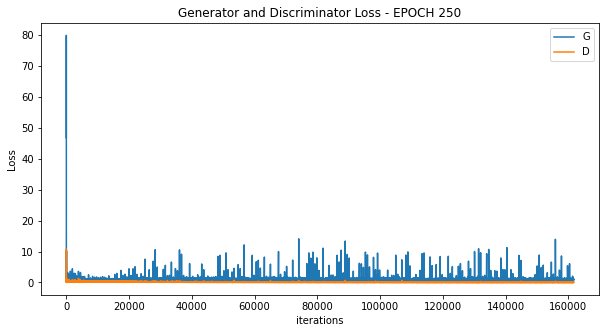

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


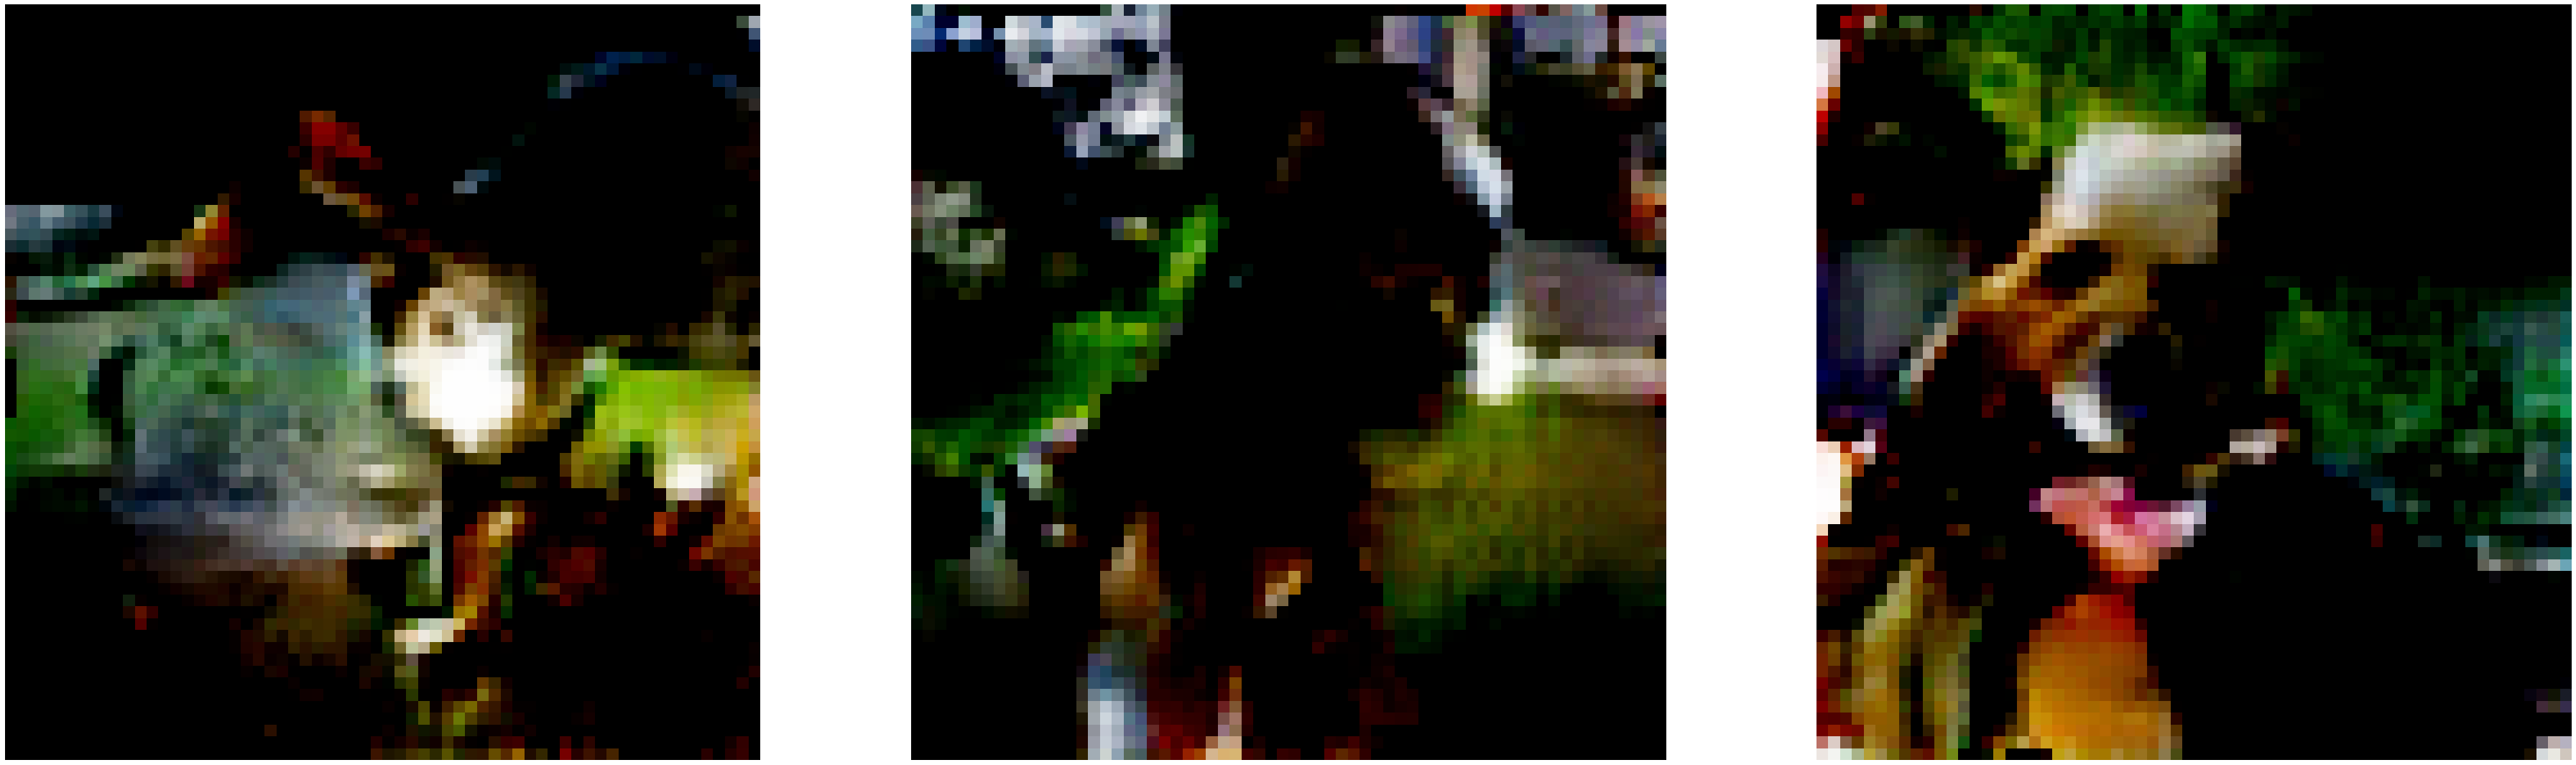

  0%|          | 0/644 [00:00<?, ?it/s]

[252/300][322/644] Loss_D: 0.0136 Loss_G: 1.1319
[252/300][644/644] Loss_D: 0.0412 Loss_G: 5.4379


  0%|          | 0/644 [00:00<?, ?it/s]

[253/300][322/644] Loss_D: 0.0376 Loss_G: 0.8509
[253/300][644/644] Loss_D: 0.0571 Loss_G: 5.7268


  0%|          | 0/644 [00:00<?, ?it/s]

[254/300][322/644] Loss_D: 0.0158 Loss_G: 1.0513
[254/300][644/644] Loss_D: 0.0282 Loss_G: 1.5446


  0%|          | 0/644 [00:00<?, ?it/s]

[255/300][322/644] Loss_D: 0.0155 Loss_G: 0.8960
[255/300][644/644] Loss_D: 0.1481 Loss_G: 0.6122


  0%|          | 0/644 [00:00<?, ?it/s]

[256/300][322/644] Loss_D: 0.0194 Loss_G: 1.1281
[256/300][644/644] Loss_D: 0.0798 Loss_G: 0.5549


  0%|          | 0/644 [00:00<?, ?it/s]

[257/300][322/644] Loss_D: 0.0155 Loss_G: 0.9477
[257/300][644/644] Loss_D: 0.0162 Loss_G: 2.8875


  0%|          | 0/644 [00:00<?, ?it/s]

[258/300][322/644] Loss_D: 0.0207 Loss_G: 1.1441
[258/300][644/644] Loss_D: 0.0814 Loss_G: 0.0939


  0%|          | 0/644 [00:00<?, ?it/s]

[259/300][322/644] Loss_D: 0.0350 Loss_G: 1.0948
[259/300][644/644] Loss_D: 0.2739 Loss_G: 6.9891


  0%|          | 0/644 [00:00<?, ?it/s]

[260/300][322/644] Loss_D: 0.0263 Loss_G: 0.9342
[260/300][644/644] Loss_D: 0.0203 Loss_G: 0.8294


  0%|          | 0/644 [00:00<?, ?it/s]

[261/300][322/644] Loss_D: 0.0252 Loss_G: 0.9911
[261/300][644/644] Loss_D: 0.0252 Loss_G: 0.1094


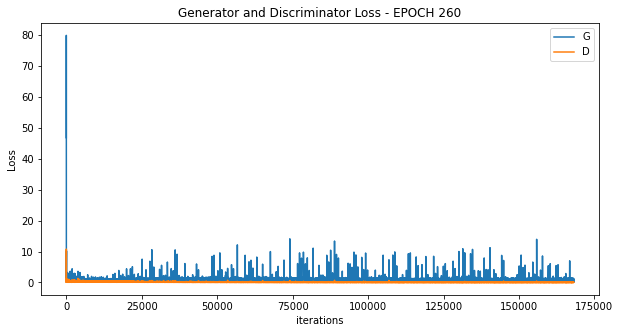

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


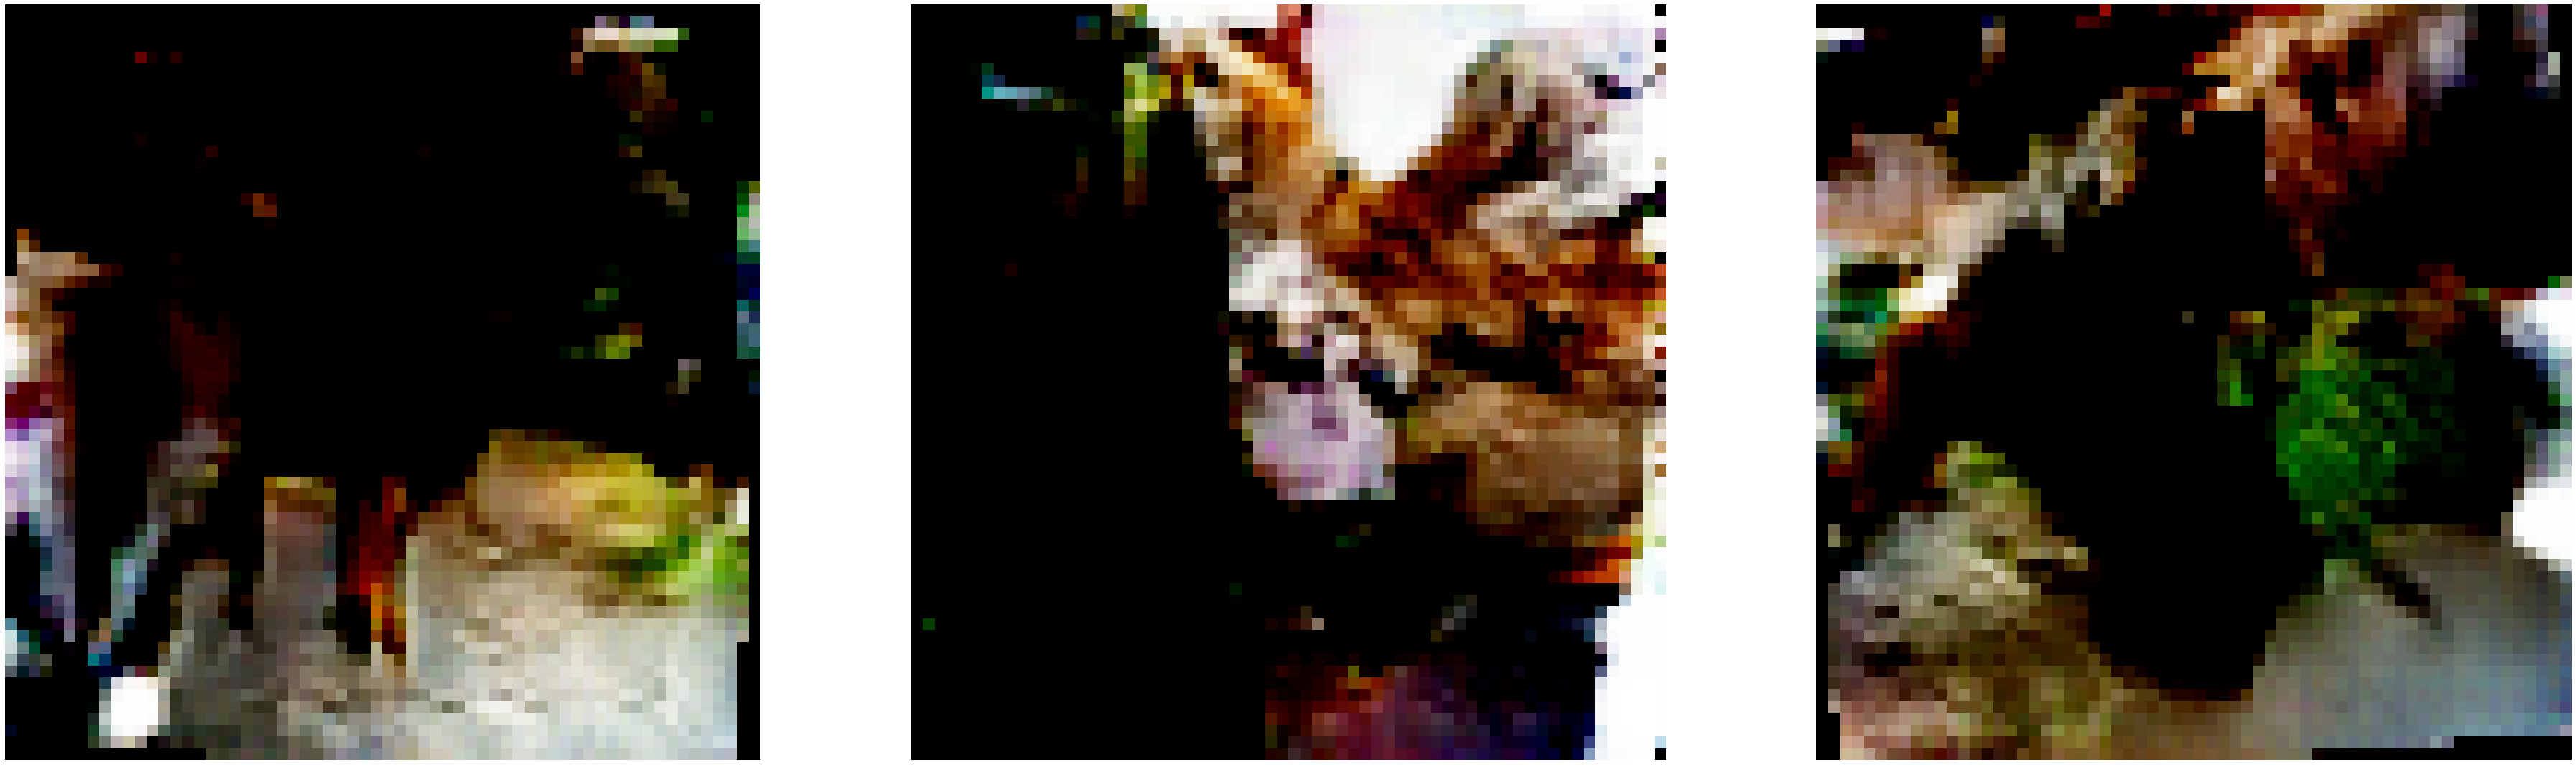

  0%|          | 0/644 [00:00<?, ?it/s]

[262/300][322/644] Loss_D: 0.0152 Loss_G: 1.0247
[262/300][644/644] Loss_D: 0.1952 Loss_G: 8.3347


  0%|          | 0/644 [00:00<?, ?it/s]

[263/300][322/644] Loss_D: 0.0469 Loss_G: 1.0910
[263/300][644/644] Loss_D: 0.0467 Loss_G: 5.1465


  0%|          | 0/644 [00:00<?, ?it/s]

[264/300][322/644] Loss_D: 0.0196 Loss_G: 1.0418
[264/300][644/644] Loss_D: 0.0516 Loss_G: 3.9304


  0%|          | 0/644 [00:00<?, ?it/s]

[265/300][322/644] Loss_D: 0.0469 Loss_G: 0.9198
[265/300][644/644] Loss_D: 0.0266 Loss_G: 0.3377


  0%|          | 0/644 [00:00<?, ?it/s]

[266/300][322/644] Loss_D: 0.0126 Loss_G: 0.9997
[266/300][644/644] Loss_D: 0.0470 Loss_G: 0.0813


  0%|          | 0/644 [00:00<?, ?it/s]

[267/300][322/644] Loss_D: 0.0139 Loss_G: 1.0384
[267/300][644/644] Loss_D: 0.3457 Loss_G: 4.1005


  0%|          | 0/644 [00:00<?, ?it/s]

[268/300][322/644] Loss_D: 0.0913 Loss_G: 0.9745
[268/300][644/644] Loss_D: 0.1929 Loss_G: 8.4452


  0%|          | 0/644 [00:00<?, ?it/s]

[269/300][322/644] Loss_D: 0.0167 Loss_G: 1.0311
[269/300][644/644] Loss_D: 0.0478 Loss_G: 3.7030


  0%|          | 0/644 [00:00<?, ?it/s]

[270/300][322/644] Loss_D: 0.0200 Loss_G: 1.0752
[270/300][644/644] Loss_D: 0.0091 Loss_G: 0.4355


  0%|          | 0/644 [00:00<?, ?it/s]

[271/300][322/644] Loss_D: 0.0168 Loss_G: 1.0911
[271/300][644/644] Loss_D: 0.1014 Loss_G: 0.9182


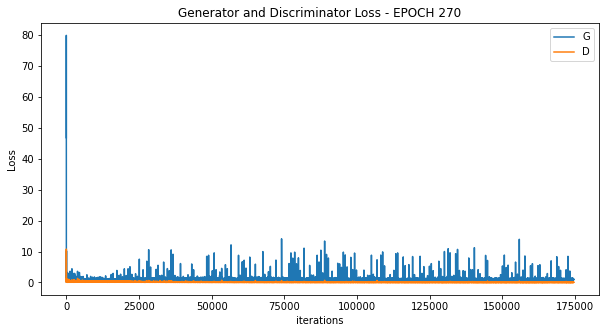

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


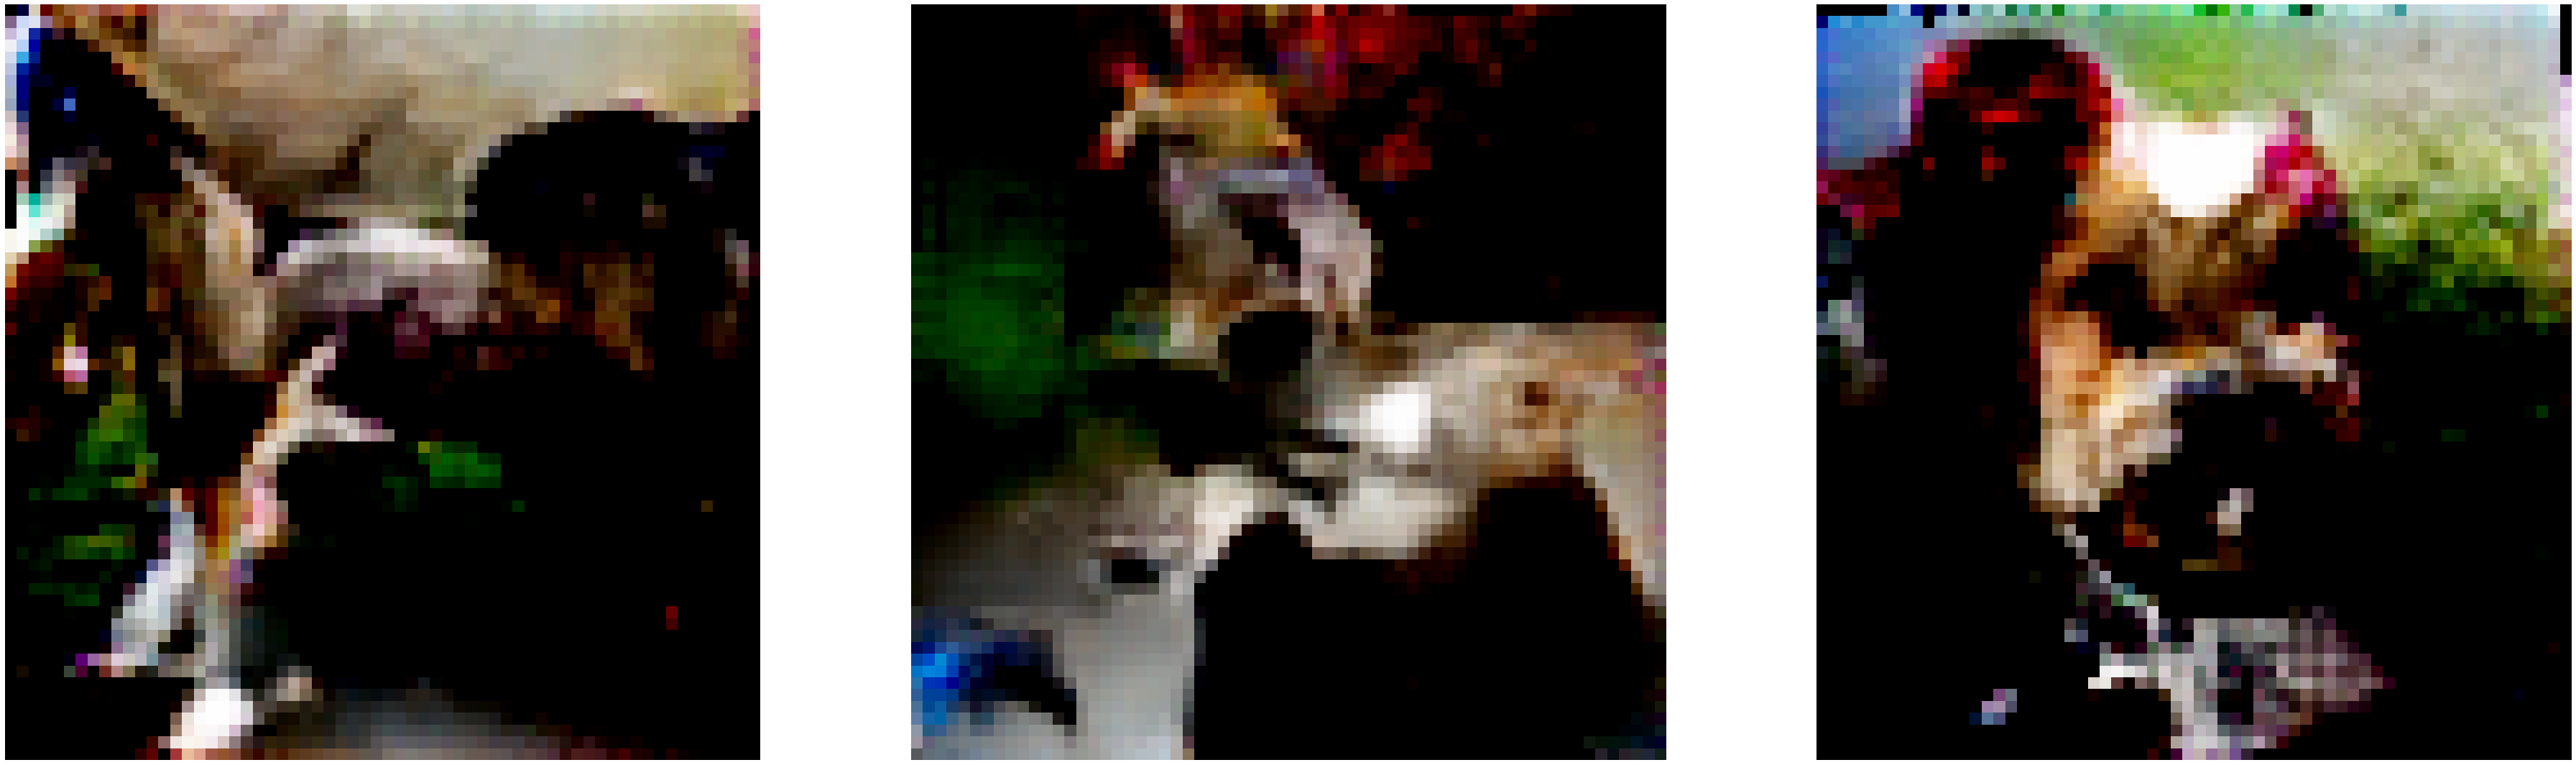

  0%|          | 0/644 [00:00<?, ?it/s]

[272/300][322/644] Loss_D: 0.0630 Loss_G: 0.9037
[272/300][644/644] Loss_D: 0.0027 Loss_G: 1.2861


  0%|          | 0/644 [00:00<?, ?it/s]

[273/300][322/644] Loss_D: 0.0202 Loss_G: 1.1167
[273/300][644/644] Loss_D: 0.0201 Loss_G: 0.2708


  0%|          | 0/644 [00:00<?, ?it/s]

[274/300][322/644] Loss_D: 0.0300 Loss_G: 0.9052
[274/300][644/644] Loss_D: 0.7986 Loss_G: 15.0767


  0%|          | 0/644 [00:00<?, ?it/s]

[275/300][322/644] Loss_D: 0.0151 Loss_G: 1.0462
[275/300][644/644] Loss_D: 0.0368 Loss_G: 0.0492


  0%|          | 0/644 [00:00<?, ?it/s]

[276/300][322/644] Loss_D: 0.0211 Loss_G: 1.0276
[276/300][644/644] Loss_D: 0.0525 Loss_G: 0.1001


  0%|          | 0/644 [00:00<?, ?it/s]

[277/300][322/644] Loss_D: 0.0150 Loss_G: 1.0528
[277/300][644/644] Loss_D: 0.0286 Loss_G: 0.0906


  0%|          | 0/644 [00:00<?, ?it/s]

[278/300][322/644] Loss_D: 0.0186 Loss_G: 0.9051
[278/300][644/644] Loss_D: 0.2316 Loss_G: 5.8778


  0%|          | 0/644 [00:00<?, ?it/s]

[279/300][322/644] Loss_D: 0.0379 Loss_G: 0.9758
[279/300][644/644] Loss_D: 0.0037 Loss_G: 1.4981


  0%|          | 0/644 [00:00<?, ?it/s]

[280/300][322/644] Loss_D: 0.0184 Loss_G: 1.0214
[280/300][644/644] Loss_D: 0.0732 Loss_G: 0.9486


  0%|          | 0/644 [00:00<?, ?it/s]

[281/300][322/644] Loss_D: 0.0640 Loss_G: 0.9755
[281/300][644/644] Loss_D: 0.0087 Loss_G: 0.3752


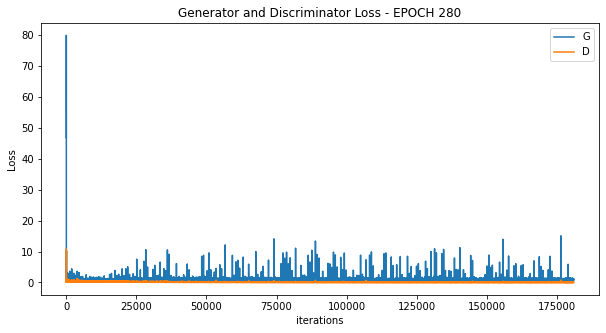

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


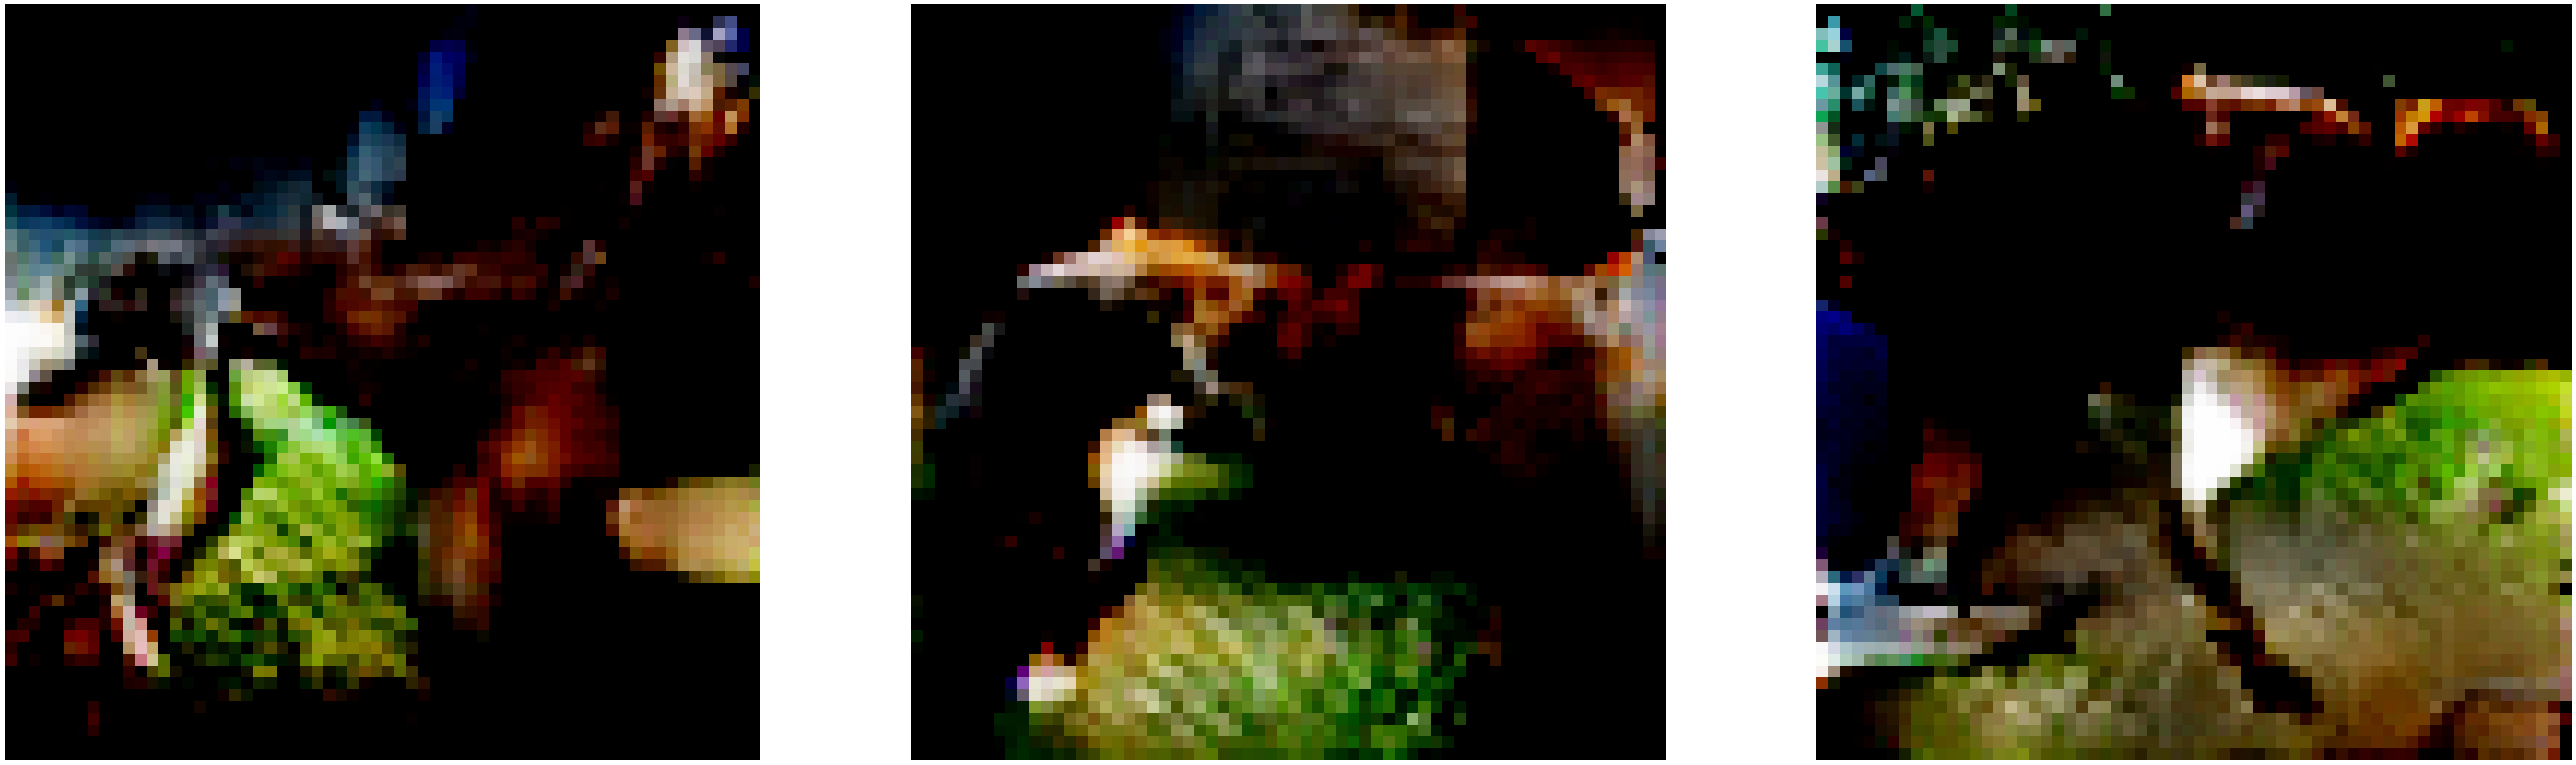

  0%|          | 0/644 [00:00<?, ?it/s]

[282/300][322/644] Loss_D: 0.0498 Loss_G: 0.6514
[282/300][644/644] Loss_D: 0.0374 Loss_G: 0.0808


  0%|          | 0/644 [00:00<?, ?it/s]

[283/300][322/644] Loss_D: 0.0175 Loss_G: 1.1368
[283/300][644/644] Loss_D: 0.0118 Loss_G: 2.0325


  0%|          | 0/644 [00:00<?, ?it/s]

[284/300][322/644] Loss_D: 0.0157 Loss_G: 0.9716
[284/300][644/644] Loss_D: 0.0376 Loss_G: 3.9243


  0%|          | 0/644 [00:00<?, ?it/s]

[285/300][322/644] Loss_D: 0.0131 Loss_G: 1.0154
[285/300][644/644] Loss_D: 0.3022 Loss_G: 10.9650


  0%|          | 0/644 [00:00<?, ?it/s]

[286/300][322/644] Loss_D: 0.0192 Loss_G: 0.9755
[286/300][644/644] Loss_D: 0.0965 Loss_G: 0.9228


  0%|          | 0/644 [00:00<?, ?it/s]

[287/300][322/644] Loss_D: 0.0160 Loss_G: 0.9289
[287/300][644/644] Loss_D: 0.0579 Loss_G: 0.1634


  0%|          | 0/644 [00:00<?, ?it/s]

[288/300][322/644] Loss_D: 0.0226 Loss_G: 1.0930
[288/300][644/644] Loss_D: 0.1185 Loss_G: 5.7397


  0%|          | 0/644 [00:00<?, ?it/s]

[289/300][322/644] Loss_D: 0.0165 Loss_G: 1.0022
[289/300][644/644] Loss_D: 0.0066 Loss_G: 0.5047


  0%|          | 0/644 [00:00<?, ?it/s]

[290/300][322/644] Loss_D: 0.0134 Loss_G: 0.9985
[290/300][644/644] Loss_D: 0.0312 Loss_G: 0.0153


  0%|          | 0/644 [00:00<?, ?it/s]

[291/300][322/644] Loss_D: 0.0232 Loss_G: 1.0260
[291/300][644/644] Loss_D: 0.1242 Loss_G: 0.8538


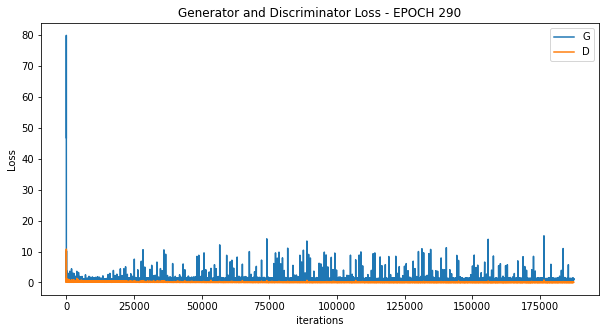

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


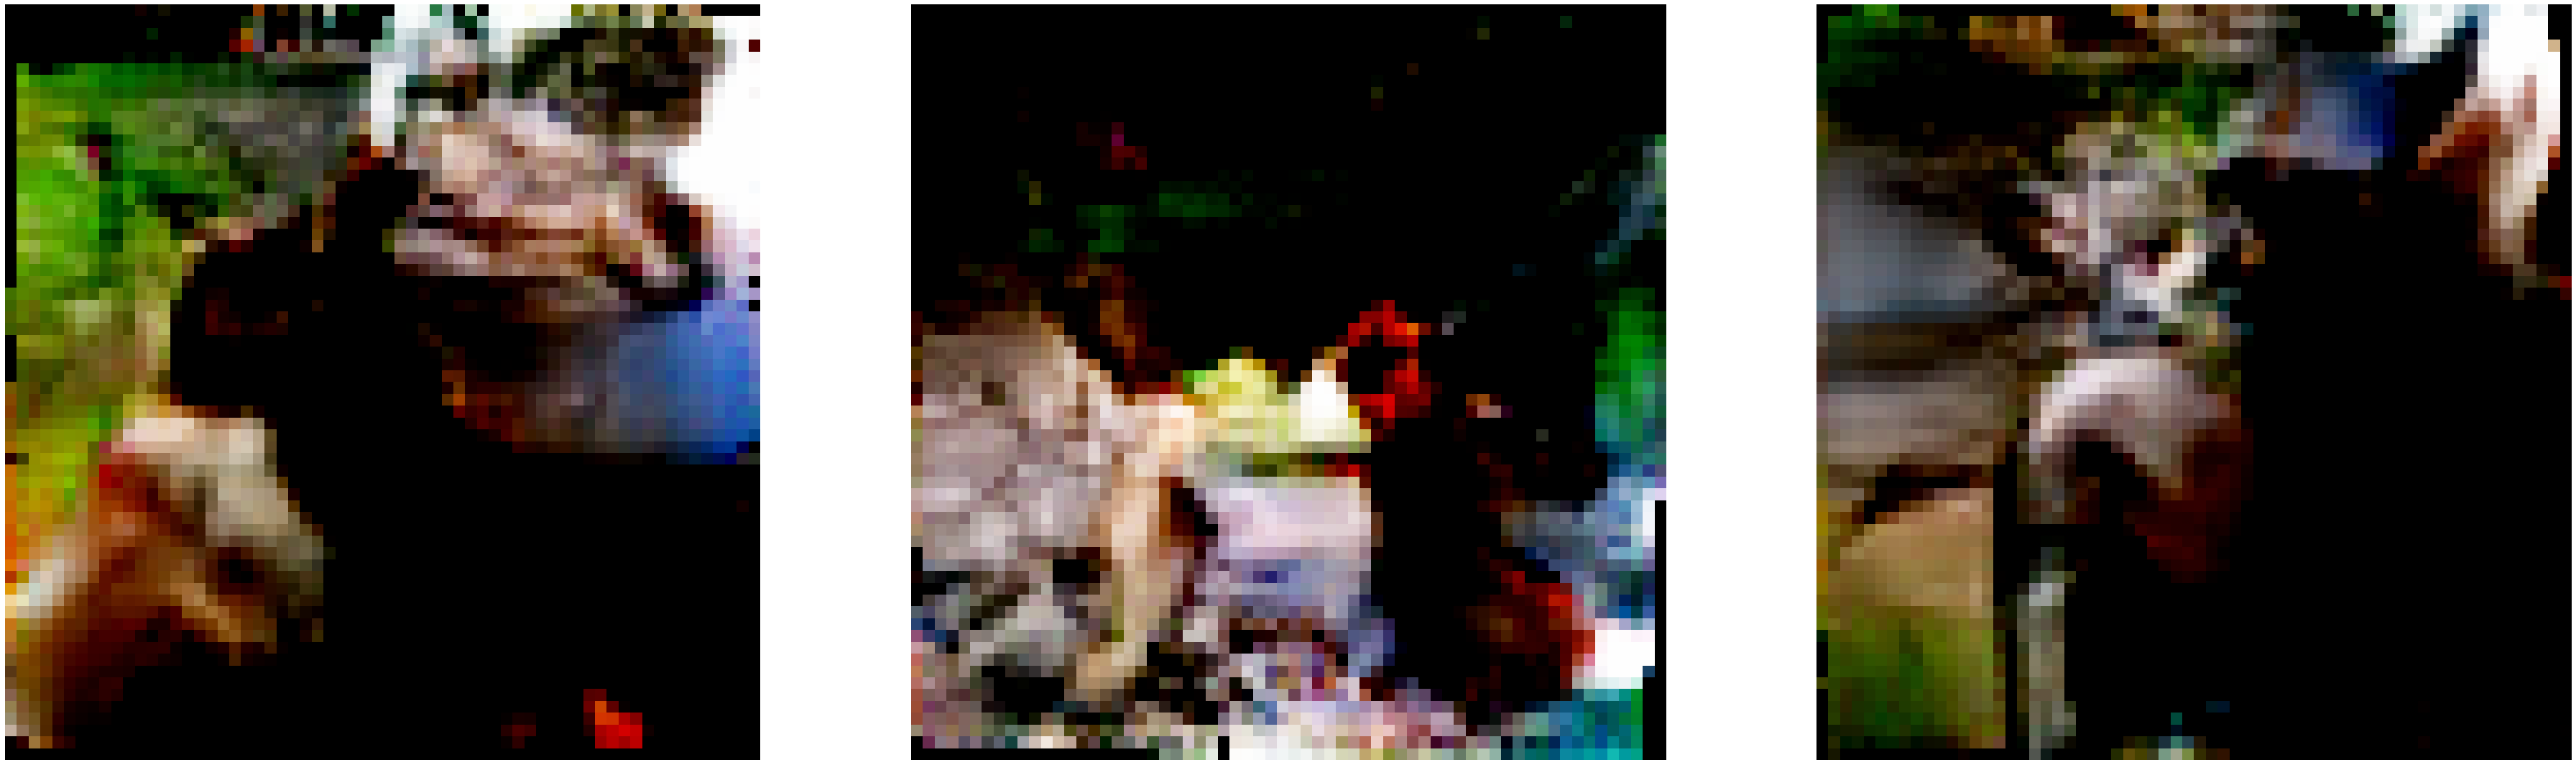

  0%|          | 0/644 [00:00<?, ?it/s]

[292/300][322/644] Loss_D: 0.0497 Loss_G: 1.0057
[292/300][644/644] Loss_D: 0.1260 Loss_G: 0.9486


  0%|          | 0/644 [00:00<?, ?it/s]

[293/300][322/644] Loss_D: 0.0225 Loss_G: 1.0568
[293/300][644/644] Loss_D: 0.1165 Loss_G: 7.5450


  0%|          | 0/644 [00:00<?, ?it/s]

[294/300][322/644] Loss_D: 0.0456 Loss_G: 0.9219
[294/300][644/644] Loss_D: 0.1123 Loss_G: 7.5012


  0%|          | 0/644 [00:00<?, ?it/s]

[295/300][322/644] Loss_D: 0.0132 Loss_G: 1.0694
[295/300][644/644] Loss_D: 0.0080 Loss_G: 0.7218


  0%|          | 0/644 [00:00<?, ?it/s]

[296/300][322/644] Loss_D: 0.0301 Loss_G: 1.1122
[296/300][644/644] Loss_D: 0.0619 Loss_G: 0.1736


  0%|          | 0/644 [00:00<?, ?it/s]

[297/300][322/644] Loss_D: 0.0128 Loss_G: 1.0902
[297/300][644/644] Loss_D: 0.1272 Loss_G: 6.9506


  0%|          | 0/644 [00:00<?, ?it/s]

[298/300][322/644] Loss_D: 0.0579 Loss_G: 1.0330
[298/300][644/644] Loss_D: 0.0129 Loss_G: 0.4985


  0%|          | 0/644 [00:00<?, ?it/s]

[299/300][322/644] Loss_D: 0.0244 Loss_G: 1.1507
[299/300][644/644] Loss_D: 0.0445 Loss_G: 6.3371


  0%|          | 0/644 [00:00<?, ?it/s]

[300/300][322/644] Loss_D: 0.0415 Loss_G: 0.9375
[300/300][644/644] Loss_D: 0.0067 Loss_G: 1.1779


In [16]:
for epoch in range(epochs):
    start = time.time()
    for ii, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):
        ############################
        # (1) Update D network
        ###########################
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)
        outputR = netD(real_images)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        outputF = netD(fake.detach())
        errD = (torch.mean((outputR - torch.mean(outputF) - labels) ** 2) + 
                torch.mean((outputF - torch.mean(outputR) + labels) ** 2))/2
        errD.backward(retain_graph=True)
        optimizerD.step()
        ############################
        # (2) Update G network
        ###########################
        netG.zero_grad()
        outputF = netD(fake)   
        errG = (torch.mean((outputR - torch.mean(outputF) + labels) ** 2) +
                torch.mean((outputF - torch.mean(outputR) - labels) ** 2))/2
        errG.backward()
        optimizerG.step()
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item()))
            
    
#     G_losses = []
#     D_losses = []
    if epoch % 10 == 0:
        plot_loss (G_losses, D_losses, epoch)
        show_generated_img(3)

    epoch_time.append(time.time()- start)

## Let's visualise generated results 

In [17]:
gen_z = torch.randn(32, nz, 1, 1, device=device)
gen_images = (netG(gen_z).to("cpu").clone().detach() + 1)/2
gen_images = gen_images.numpy().transpose(0, 2, 3, 1)

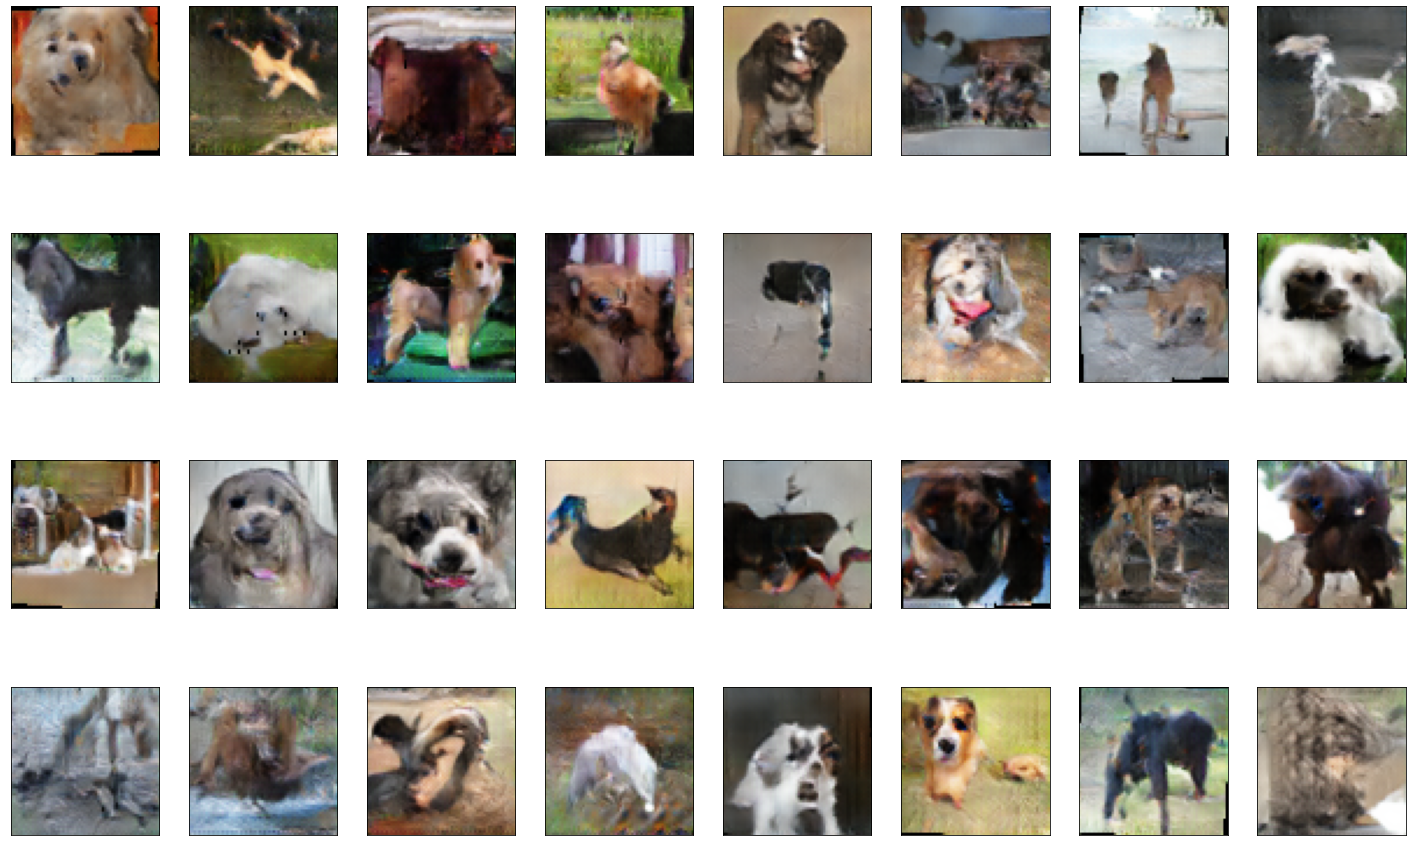

In [18]:
fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(gen_images):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow(img)

# Results and Conclusion

We can see that there are indeed features of dogs in the generated pictures. However, there are oddities and artifacts created possibly from the dimensions of the pictures and the limitations of the devices/dataset. Generated pictures may be discriminated visually, but with the quality of the pictures themselves, it may trick a human once every ten images. As there are eyes, ears, fur, nose and mouth, some pictures can trick the discriminator. 

As a whole, this model was a success because it does create dog-like images. With further training, time, available image dimensions, and stronger devices, creating dog images that can trick a human discriminator is not only possible but ALREADY possible with stable diffusion and other publically available models. This report was only made to show the architecture in its most basic form. 


## Make predictions and submit

In [19]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = (netG(gen_z) + 1)/2
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/home/jeffwa/Desktop/idlwk5/images.zip'

In [20]:
PATH1 = "modelG.pt"
PATH2 = "modelD.pt"
# Save
torch.save(netG.state_dict(), PATH1)
torch.save(netD.state_dict(), PATH2)

In [24]:
"""# Load
device = torch.device("cuda")
model = Generator()
model.load_state_dict(torch.load(PATH1))
model.to(device)"""

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Batch